In [2]:
## A section imports:
import pandas as pd
import sys
import seaborn as sns
sys.path.append('utilities')
import helpers as h
import matplotlib.pyplot as plt
import requests
import random
##B-section imports: 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from catboost import CatBoostRegressor, Pool


# A: FILE IO + EDA

# 1: Reading files from disk into memory
start by reading the file locations from file, then load the excel file, list the sheets and load them all into variables. Next load the y_test.csv file.

In [3]:
files = h.get_file_organization(True)

Key                                          File Path                                        Explanation
0    raw_data  c:\Python projects\regression task\evaluatie-2...  Training dataset in Excel format as downloaded...
1  y_testdata  c:\Python projects\regression task\evaluatie-2...  Training testdata as downloaded from mail in C...

In [4]:
excel_file = pd.ExcelFile(files['raw_data'])
X_train, X_test, y_train = [pd.read_excel(files['raw_data'], sheet_name= sheet) for sheet in excel_file.sheet_names]
# X_train, X_text, y_train =
y_test = pd.read_csv(files['y_testdata'])
excel_file.close()
assert(len(X_train) == len(y_train))

# 2: EDA - what data/columns do we have?

In [5]:
X_train.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size
0       2023        Mid-level       Full-time  Machine Learning Engineer      United States    In-person    United States            M
1       2023        Mid-level       Full-time             Data Scientist      United States    In-person    United States            M
2       2024           Senior       Full-time             Data Scientist     United Kingdom    In-person   United Kingdom            M
3       2024           Senior       Full-time             Data Scientist      United States       Remote    United States            M
4       2024           Senior       Full-time             Data Scientist     United Kingdom       Remote   United Kingdom            M

In [6]:
y_train.head(5)

salary_in_eur
0      188140.00
1      155480.00
2       36800.00
3       88113.92
4       59800.00

## 2.1 single df: 
We want to have a single df with y_train as the target column for easier plotting in our EDA phase. 

In [7]:
df = X_train.copy()
df['target'] = y_train

In [8]:
df.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size     target
0       2023        Mid-level       Full-time  Machine Learning Engineer      United States    In-person    United States            M  188140.00
1       2023        Mid-level       Full-time             Data Scientist      United States    In-person    United States            M  155480.00
2       2024           Senior       Full-time             Data Scientist     United Kingdom    In-person   United Kingdom            M   36800.00
3       2024           Senior       Full-time             Data Scientist      United States       Remote    United States            M   88113.92
4       2024           Senior       Full-time             Data Scientist     United Kingdom       Remote   United Kingdom            M   59800.00

## 2.2 Column inspection:
What is the range of values we're working with - at a first glance there seem to be quite some columns that might be suitable for ordinal encoding (e.g. company_size or experience_level). But for it to work properly we need to have clearly distinguished values in these columns. (e.g. S,M,L and not S,M,L, 100-1000, 1000-2500 for company_size)

In [9]:
df.nunique()
# we see that there is potential to use ordinal encoding for experience_level and company_size. We might consider employment_type and work_setting too if we can find a meaningful hierarchy there.

work_year                5
experience_level         4
employment_type          4
job_title              145
employee_residence      84
work_setting             3
company_location        73
company_size             3
target                2115
dtype: int64

In [10]:
for column in df.columns:
    if df[column].nunique() < 6:
        print(column, '\t', df[column].unique())

work_year 	 [2023 2024 2022 2020 2021]
experience_level 	 ['Mid-level' 'Senior' 'Entry-level' 'Executive']
employment_type 	 ['Full-time' 'Freelance' 'Contract' 'Part-time']
work_setting 	 ['In-person' 'Remote' 'Hybrid']
company_size 	 ['M' 'L' 'S']


I'm comfortable calling **experience_level** and **company_size** ordinal values and using ordinal encoding on them. There's a clear hierarchy in the unique values printed for these columns. 
I'm less convinced that **employment_type** and **work_setting** shoudl be treated in a similar way. 
- consider *Contract*: is that a full-time or part-time contract? 
- consider *Part-time*: what's the percentage? 
- consider *Hybrid*: What's the ratio between remote and in-person?

At this point we're curious as to why there's so many **company_location**, **job_title** and **employee_residence** values. 
- to be considered: are there **company_locations** that are hyperspecific (e.g. U.S. vs U.S. - Texas)?
- to be considered: are there **job_titles** that are synonyms (e.g. Lead Dev vs Lead developer) or similar (e.g. Docker vs Kubernetes)?

In [11]:
print(h.get_alphabetically(df, 'company_location'))
#no, there's no hyperspecificity in countries - but if we use one-hot encoding, we should make it easy for ourselves change the name of some countries
#   - remove ü
#   - all to lowercase
#   - remove spaces
#   - get rid of comma's 

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Bahamas' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'Canada'
 'Central African Republic' 'China' 'Colombia' 'Croatia' 'Czechia'
 'Denmark' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany'
 'Ghana' 'Gibraltar' 'Greece' 'Honduras' 'Hungary' 'India' 'Indonesia'
 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kenya' 'Korea, Republic of' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Malta' 'Mauritius' 'Mexico' 'Moldova, Republic of'
 'Netherlands' 'New Zealand' 'Nigeria' 'Oman' 'Pakistan' 'Philippines'
 'Poland' 'Portugal' 'Puerto Rico' 'Qatar' 'Romania' 'Russian Federation'
 'Saudi Arabia' 'Singapore' 'Slovenia' 'South Africa' 'Spain' 'Sweden'
 'Switzerland' 'Thailand' 'Türkiye' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Viet Nam']


In [12]:
jobs = h.get_alphabetically(df, 'job_title')
print(jobs, len(jobs))
#Hooray we've opened medusa's box and we found a pile of shit: 
#    'ML Ops Engineer' 'MLOps Engineer' ==> SAME THING
#   there's a bunch of titles that I don't even know what the bloody hell they do - and I'd consider it a miracle of the peeople involved know.

['AI Architect' 'AI Developer' 'AI Engineer' 'AI Product Manager'
 'AI Programmer' 'AI Research Engineer' 'AI Research Scientist'
 'AI Scientist' 'AI Software Engineer' 'Admin & Data Analyst'
 'Analytics Engineer' 'Analytics Engineering Manager'
 'Applied Data Scientist' 'Applied Machine Learning Engineer'
 'Applied Machine Learning Scientist' 'Applied Scientist'
 'Autonomous Vehicle Technician' 'Azure Data Engineer' 'BI Analyst'
 'BI Data Analyst' 'BI Developer' 'Big Data Architect'
 'Big Data Developer' 'Big Data Engineer' 'Business Data Analyst'
 'Business Intelligence' 'Business Intelligence Analyst'
 'Business Intelligence Data Analyst' 'Business Intelligence Developer'
 'Business Intelligence Engineer' 'Business Intelligence Lead'
 'Business Intelligence Manager' 'Business Intelligence Specialist'
 'Cloud Data Architect' 'Cloud Data Engineer' 'Cloud Database Engineer'
 'Compliance Data Analyst' 'Computational Biologist'
 'Computer Vision Engineer' 'Computer Vision Software Engine

In [13]:
print(h.get_alphabetically(df, 'employee_residence'))

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Belgium' 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina'
 'Brazil' 'Bulgaria' 'Canada' 'Central African Republic' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Honduras' 'Hong Kong' 'India'
 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Italy' 'Japan'
 'Jersey' 'Kenya' 'Korea, Republic of' 'Kuwait' 'Latvia' 'Lebanon'
 'Lithuania' 'Luxembourg' 'Malaysia' 'Malta' 'Mauritius' 'Mexico'
 'Moldova, Republic of' 'Netherlands' 'New Zealand' 'Nigeria' 'Oman'
 'Pakistan' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Russian Federation' 'Saudi Arabia' 'Serbia' 'Singapore'
 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'Tunisia' 'Türkiye' 'Uganda' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States

In [14]:
#NAN inspection:
print(df.isnull().sum())    #COOL, no nans. 

work_year             0
experience_level      0
employment_type       0
job_title             0
employee_residence    0
work_setting          0
company_location      0
company_size          0
target                0
dtype: int64


# 3 data preprocessing: 
we'll add some features that might be interesting to use further down the line.
rationalize the job_title - there are typos, synonyms in there. It should also be split in field/domain and title. 
clean up names of countries if used in OHE later. 

In [15]:
#We saw there are more values for employee_residence then there are for company_location. 
# A question we might try to explore: are foreign employees payed less?
df_processed = df.copy()
df_processed['employee_of_country']  = df_processed['employee_residence'] == df_processed['company_location']

In [16]:
#For jobs we saw that there's some redundancy: same jobs - different spelling. 
# let's address this quickly with the extractor utility.
df_processed[['field', 'title']] = df_processed['job_title'].apply(h.extractor).apply(pd.Series)
#tehre's probably more to do here, but this is a good enough start.


In [17]:
#Same for country data in employee_residence and company_location
cleanup_countries = {
    'republic of': '', 
    'ü': 'u',
    ',': '',
    ' ': '_'
    }
df_processed = h.cleanup_strings(df_processed, 'employee_residence', cleanup_countries)
df_processed = h.cleanup_strings(df_processed, 'company_location', cleanup_countries)

# 4: EDA - visualisations

## 4.1. do foreign employees earn less?

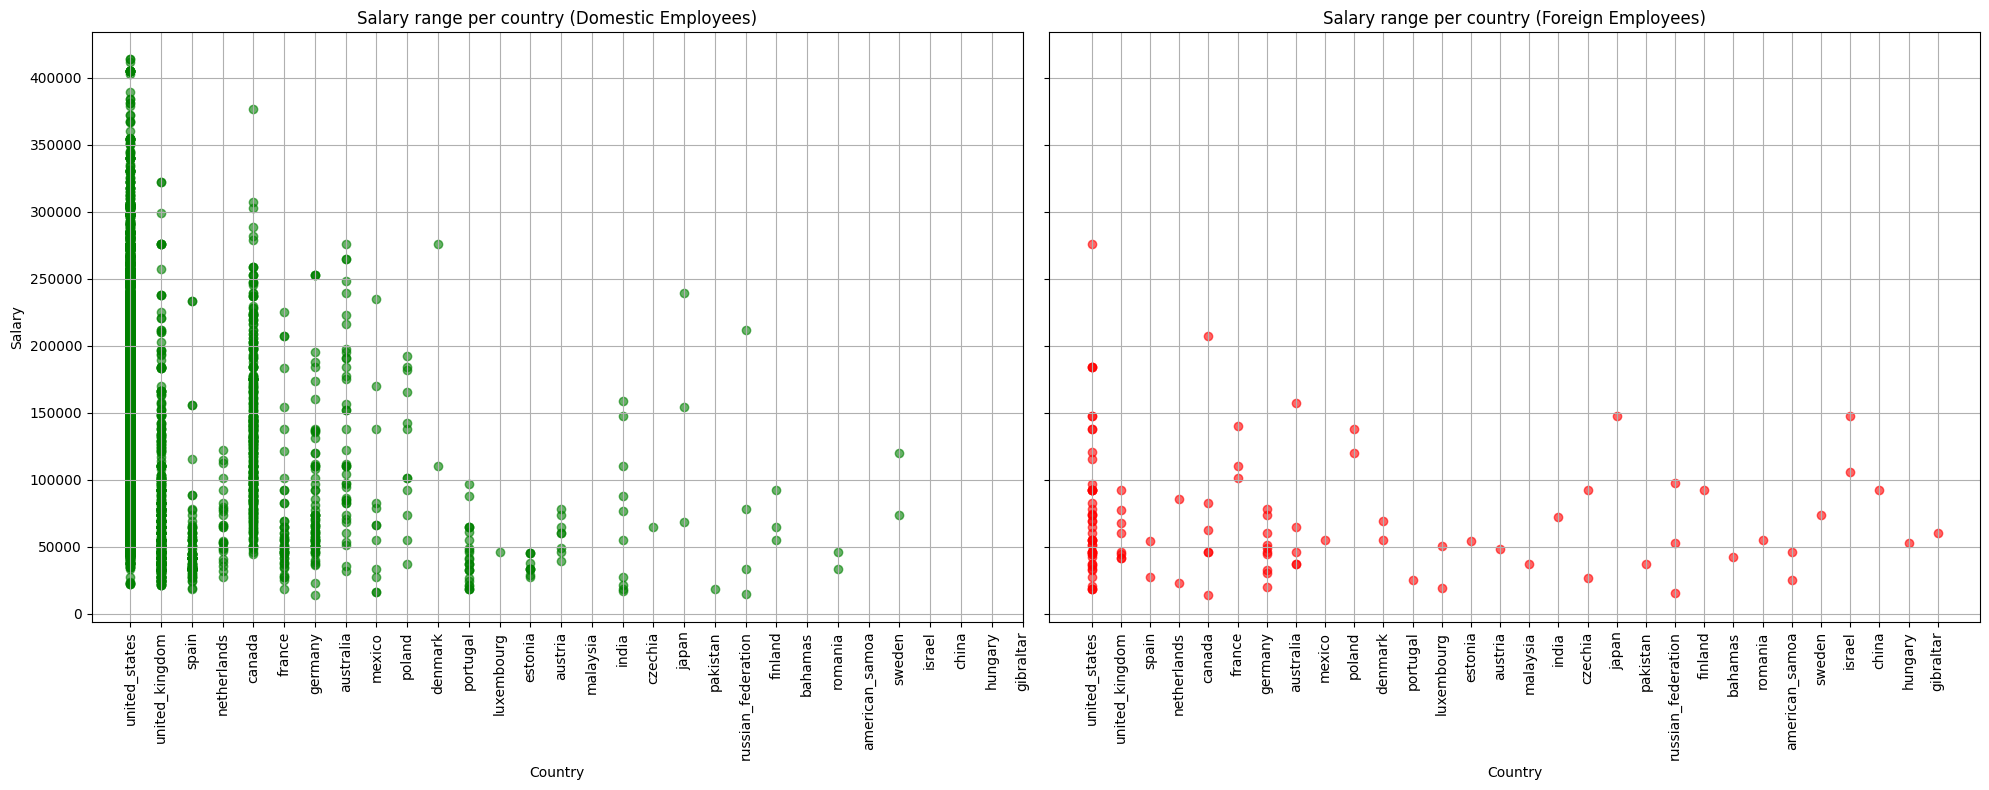

In [18]:
# Filter the data
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
df_filtered = df_processed[df_processed['company_location'].isin(countries_with_false)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for green dots (employee_of_country == True)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == True)]
    ax1.scatter([i] * len(country_data), country_data['target'], color='green', alpha=0.6)

# Plot for red dots (employee_of_country == False)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == False)]
    ax2.scatter([i] * len(country_data), country_data['target'], color='red', alpha=0.6)

# Customize the plots
ax1.set_title('Salary range per country (Domestic Employees)')
ax1.set_xlabel('Country')
ax1.set_ylabel('Salary')
ax1.set_xticks(range(len(df_filtered['company_location'].unique())))
ax1.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax1.grid(True)

ax2.set_title('Salary range per country (Foreign Employees)')
ax2.set_xlabel('Country')
ax2.set_xticks(range(len(df_filtered['company_location'].unique())))
ax2.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

This scatterplot does suggest so, but it's easier to compare country side by side.
A violinplot would be nice, but it does funky things, boxplot does not show distribution as detailed as a boxenplot does, so we go for the latter. 

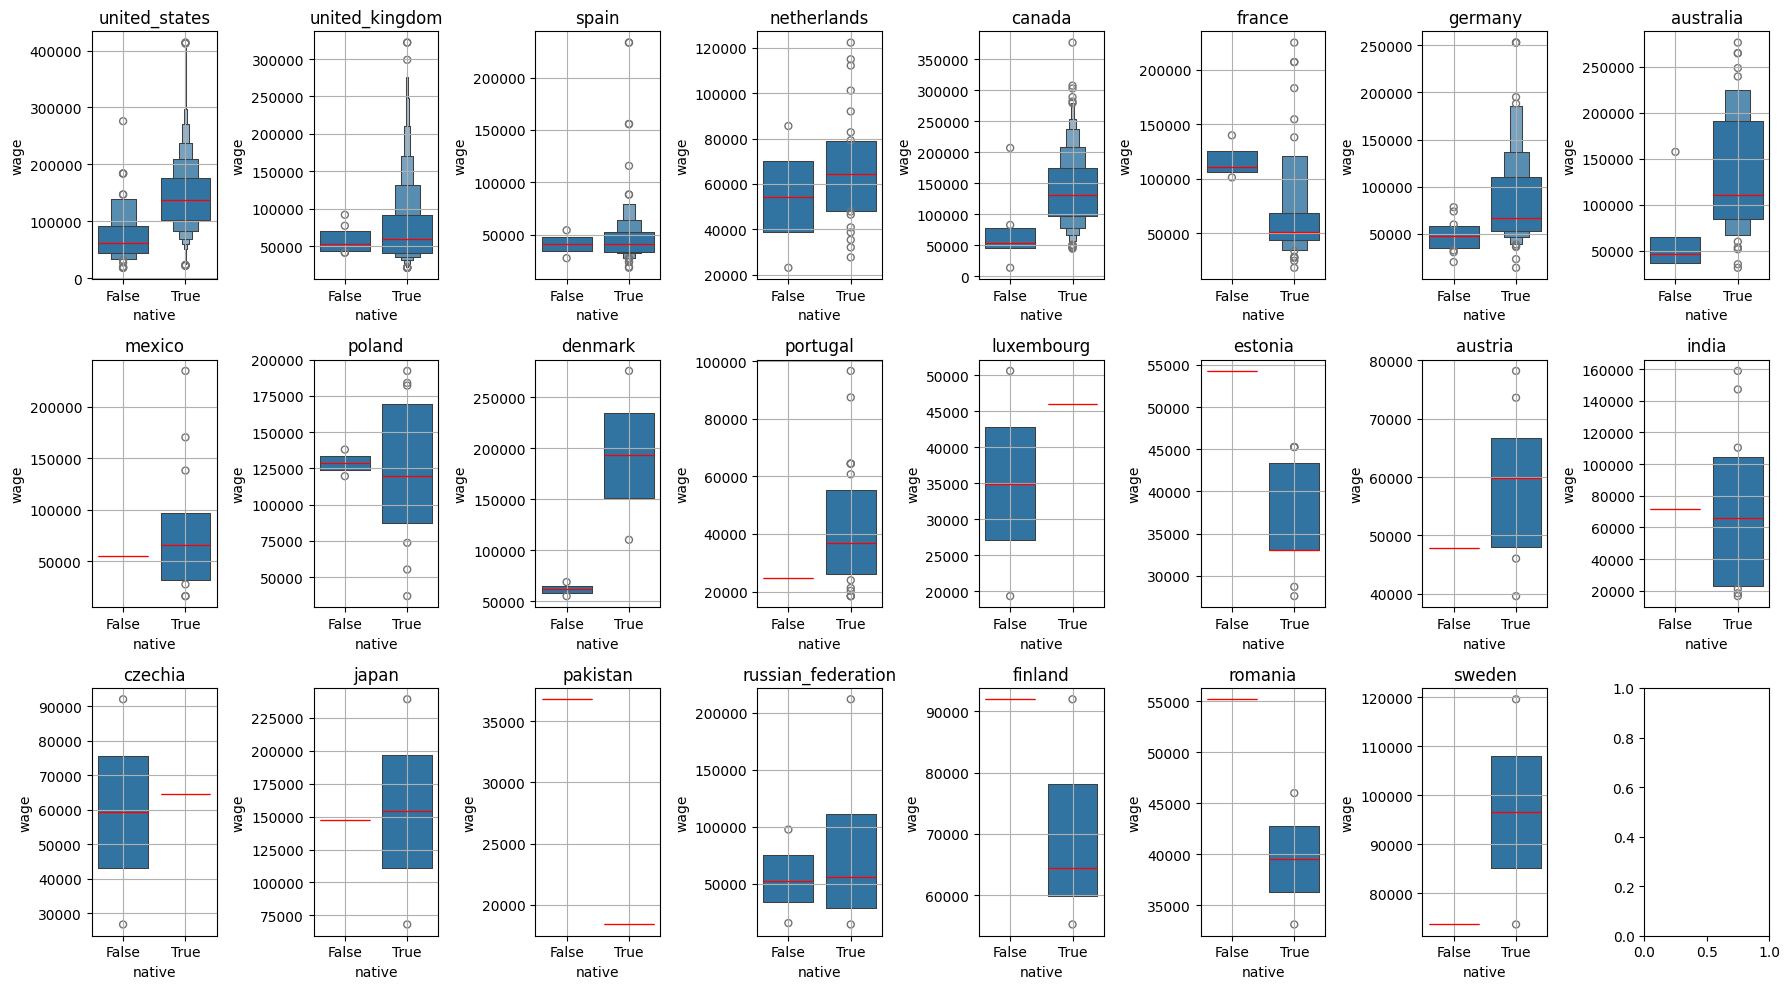

In [19]:
#Share Y-axis in boxplots: (1 or 0)
y_setting = 0       #zero = autoscale per subplot, 1 = shared y axis. 
plottype = 'boxen'  #box or boxen
##########

# Filter the data based on employee_of_country; the country should have both true and false to be interesting in this plot;
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
countries_with_true = df_processed[df_processed['employee_of_country'] == True]['company_location'].unique()
relevant_countries = list(set(countries_with_false) & set(countries_with_true))
df_filtered = df_processed[df_processed['company_location'].isin(relevant_countries)]

# Get the unique countries
unique_countries = df_filtered['company_location'].unique()
#print(len(unique_countries))

# Create the figure and subplots
y_axis_setting = 'all' if y_setting == 1 else None
fig, axes = plt.subplots(3, 8, figsize=(18, 10), sharey=y_setting)     #there are 30 countries that have foreign employees, 23 that have both this is what I'm interested in here, so 3by10
axes = axes.flatten()

# Plot for each country
for i, country in enumerate(unique_countries):
    ax = axes[i]
    country_data = df_filtered[df_filtered['company_location'] == country]
    # Create boxplot with values for country == country_data
    if plottype == 'boxen':
        sns.boxenplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False, line_kws={'color': 'red'})
    else:
        sns.boxplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False)
    ax.set_title(country)
    ax.set_xlabel('native')
    ax.set_ylabel('wage')

    ax.grid(True)

plt.tight_layout()
plt.show()

Some countries are more paritar than others. For example: Denmark has a very high unequality, whereas Spain has a very similar boxenplot (bar the outliers). This could be due to different job functions being filled out in different countries, at this stage of the EDA, we should put a pin in that idea and go to check the numerical distribution of jobs per country/function using barcharts and grids. If the grid shows us the ratios are similar between countries, then we can create more detailed boxenplots for Spain vs Denmark vs United States vs Japan... and a few others to see if certain job titles are not reachable for non-native employees. If the numbers are too low, then we have to conclude that there's not enough samples to make a statement about this. 

## 4.2. What's the distribution of jobs per country: (barchart)

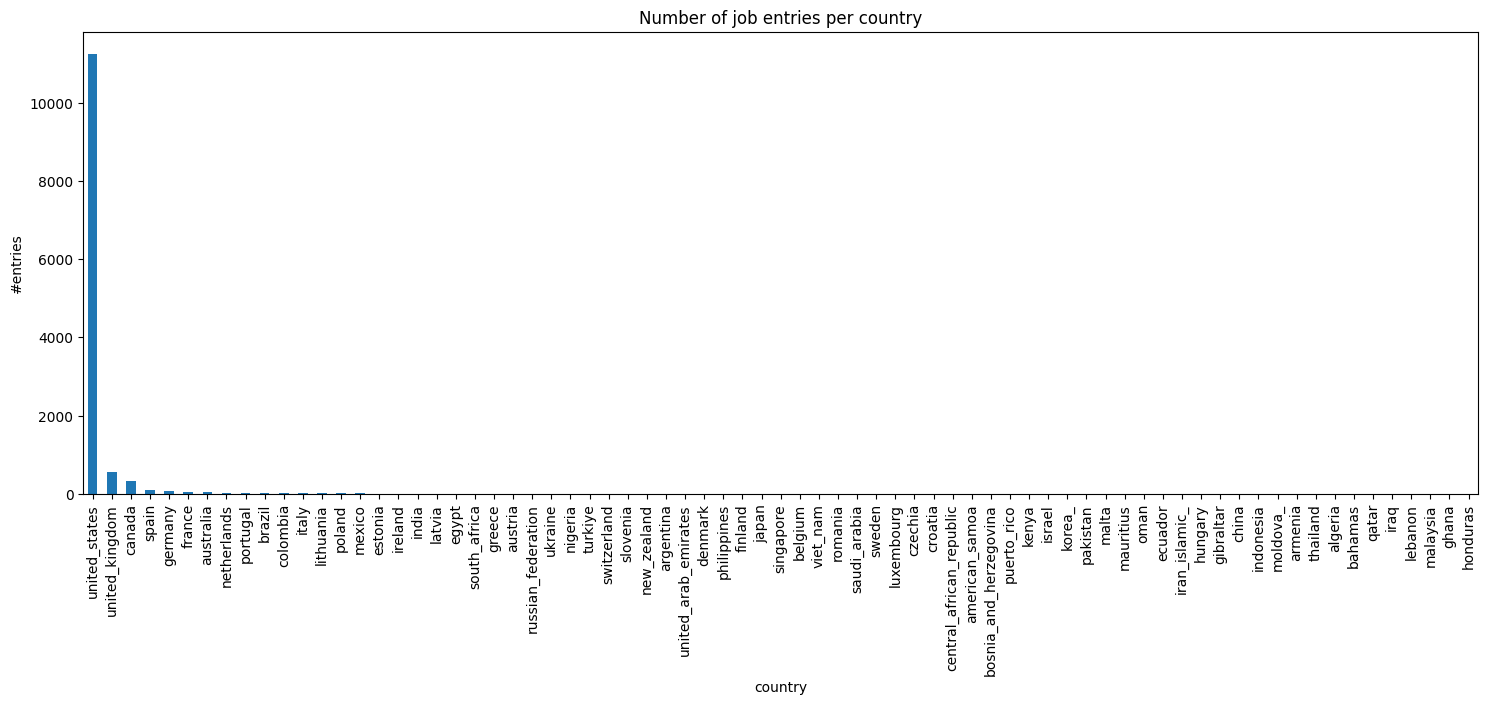

In [20]:
country_counts = df_processed['company_location'].value_counts()
plt.figure(figsize=(18, 6))
country_counts.plot(kind='bar')
plt.xlabel('country')
plt.ylabel('#entries')
plt.title('Number of job entries per country')
plt.show()

So the listings in the US are throwing off a lot, we need to keep this in mind as we continue making other visualizations. For the model it shouldn't matter too much. You could consider LOG visualizations, but they are not intuitive enough. In stead split it up: US vs the rest (one plot), the rest (detailled plot). This already circles back to the previous boxenplots made, we see that Denmark is not really representative - so investigating the titles is probably not worth it due to too little samples.

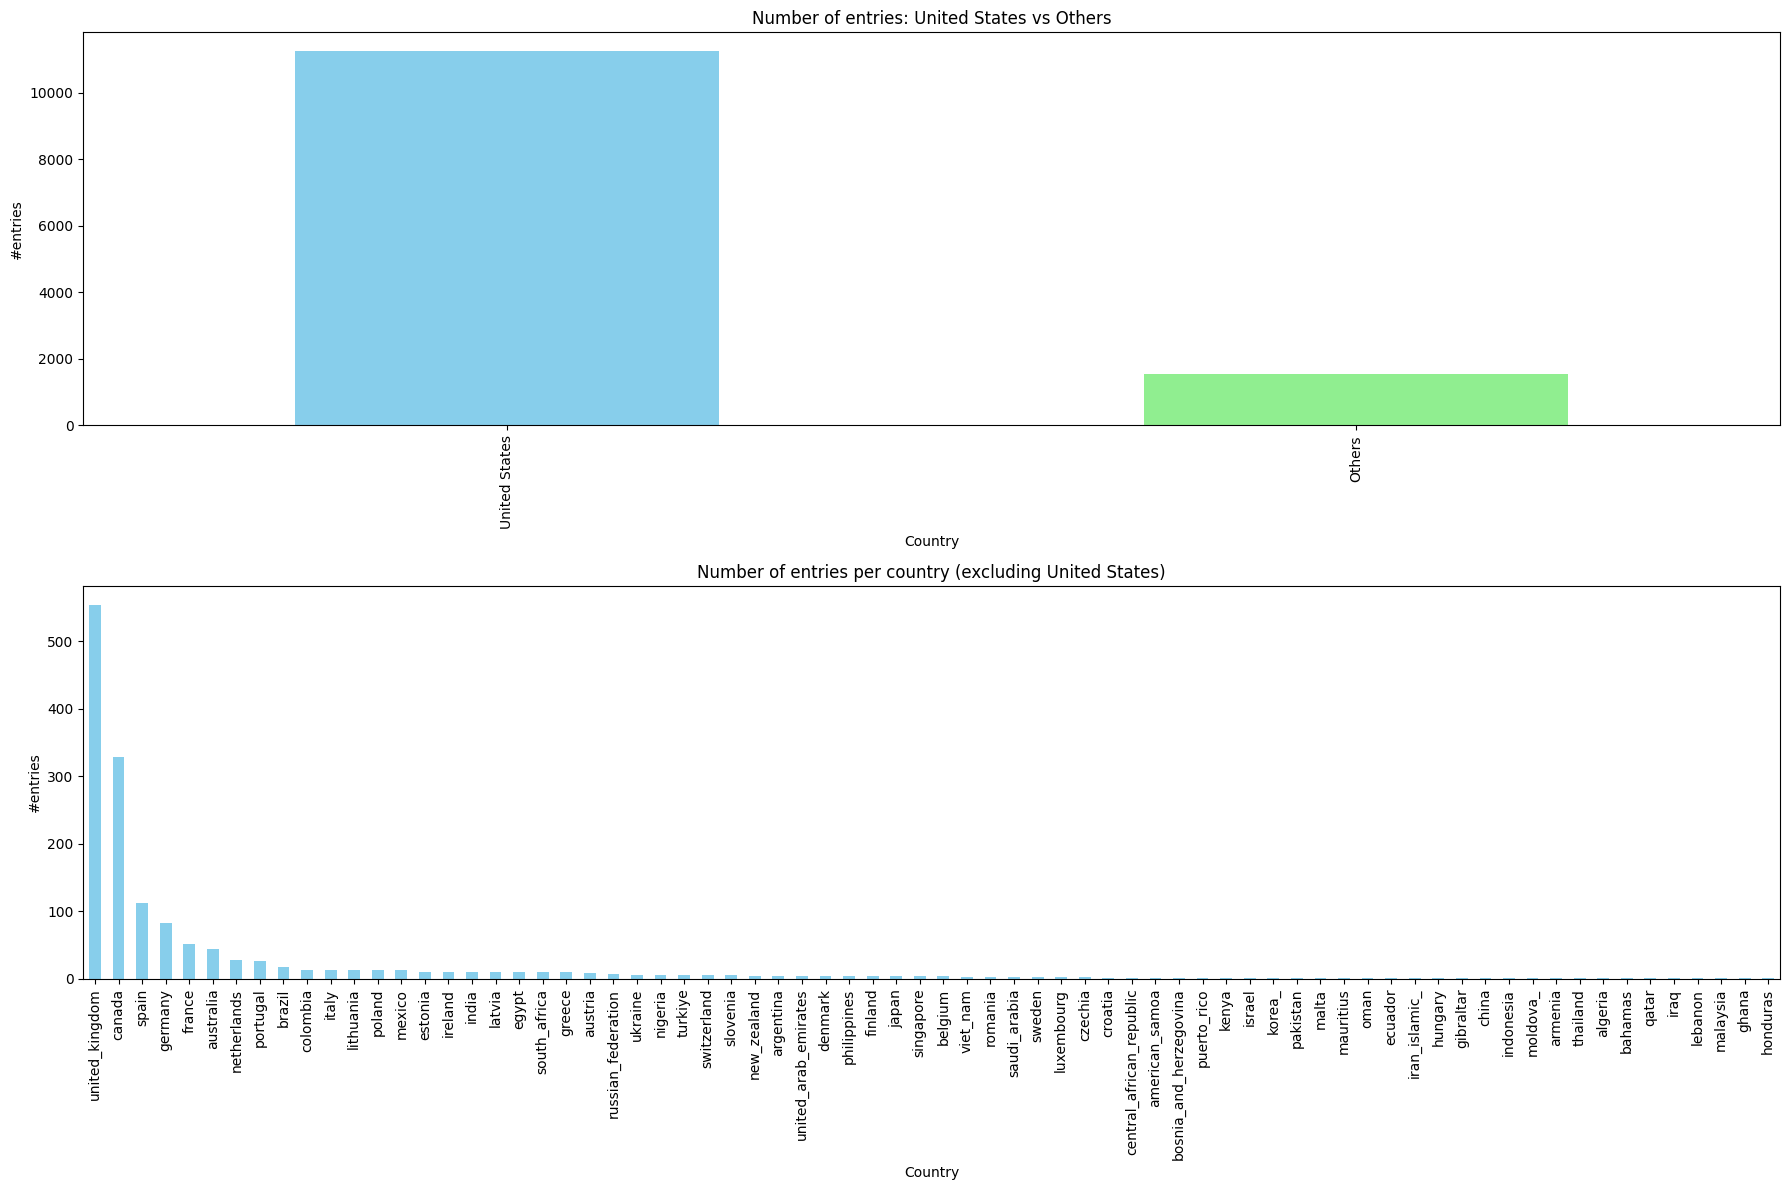

In [21]:
us_count = country_counts.get('united_states', 0)
other_counts = country_counts.drop('united_states').sum()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
first_plot_data = pd.Series({'United States': us_count, 'Others': other_counts})
first_plot_data.plot(kind='bar', color=['skyblue', 'lightgreen'], ax=ax1)
ax1.set_xlabel('Country')
ax1.set_ylabel('#entries')
ax1.set_title('Number of entries: United States vs Others')
other_country_counts = country_counts.drop('united_states')
other_country_counts.plot(kind='bar', color='skyblue', ax=ax2)
ax2.set_xlabel('Country')
ax2.set_ylabel('#entries')
ax2.set_title('Number of entries per country (excluding United States)')
plt.tight_layout()
plt.show()

even after combining all the data of non-us countries, we see that the dataset still heavily favours the United States. 

In [22]:
df_processed.loc[df_processed['company_location'] == 'honduras']  #and then still we see that some countries only have a single entry

work_year experience_level employment_type             job_title employee_residence work_setting company_location company_size   target  employee_of_country    field         title
12551       2020        Mid-level       Full-time  Product Data Analyst           honduras    In-person         honduras            S  18400.0                 True  Product  Data Analyst

by the lookks of it, countries like Hondurs, Oman, only have one listing... that's problematic for a train test split... we might just throw a bunch of countries together if there's no big difference in their wages. repeat the above plot and add a second y-axis to show the median and average wage for each country. 

## 4.3. What's the amount of values we have per country/field and country/title?
For this visualization we'll make a kind of heatmap with x-y axis. Color intensity is the amount of rows at the xy-intersect.
- We're going to hide 0 values using a mask to not overload it visually with a bund of zeros; 
- Also

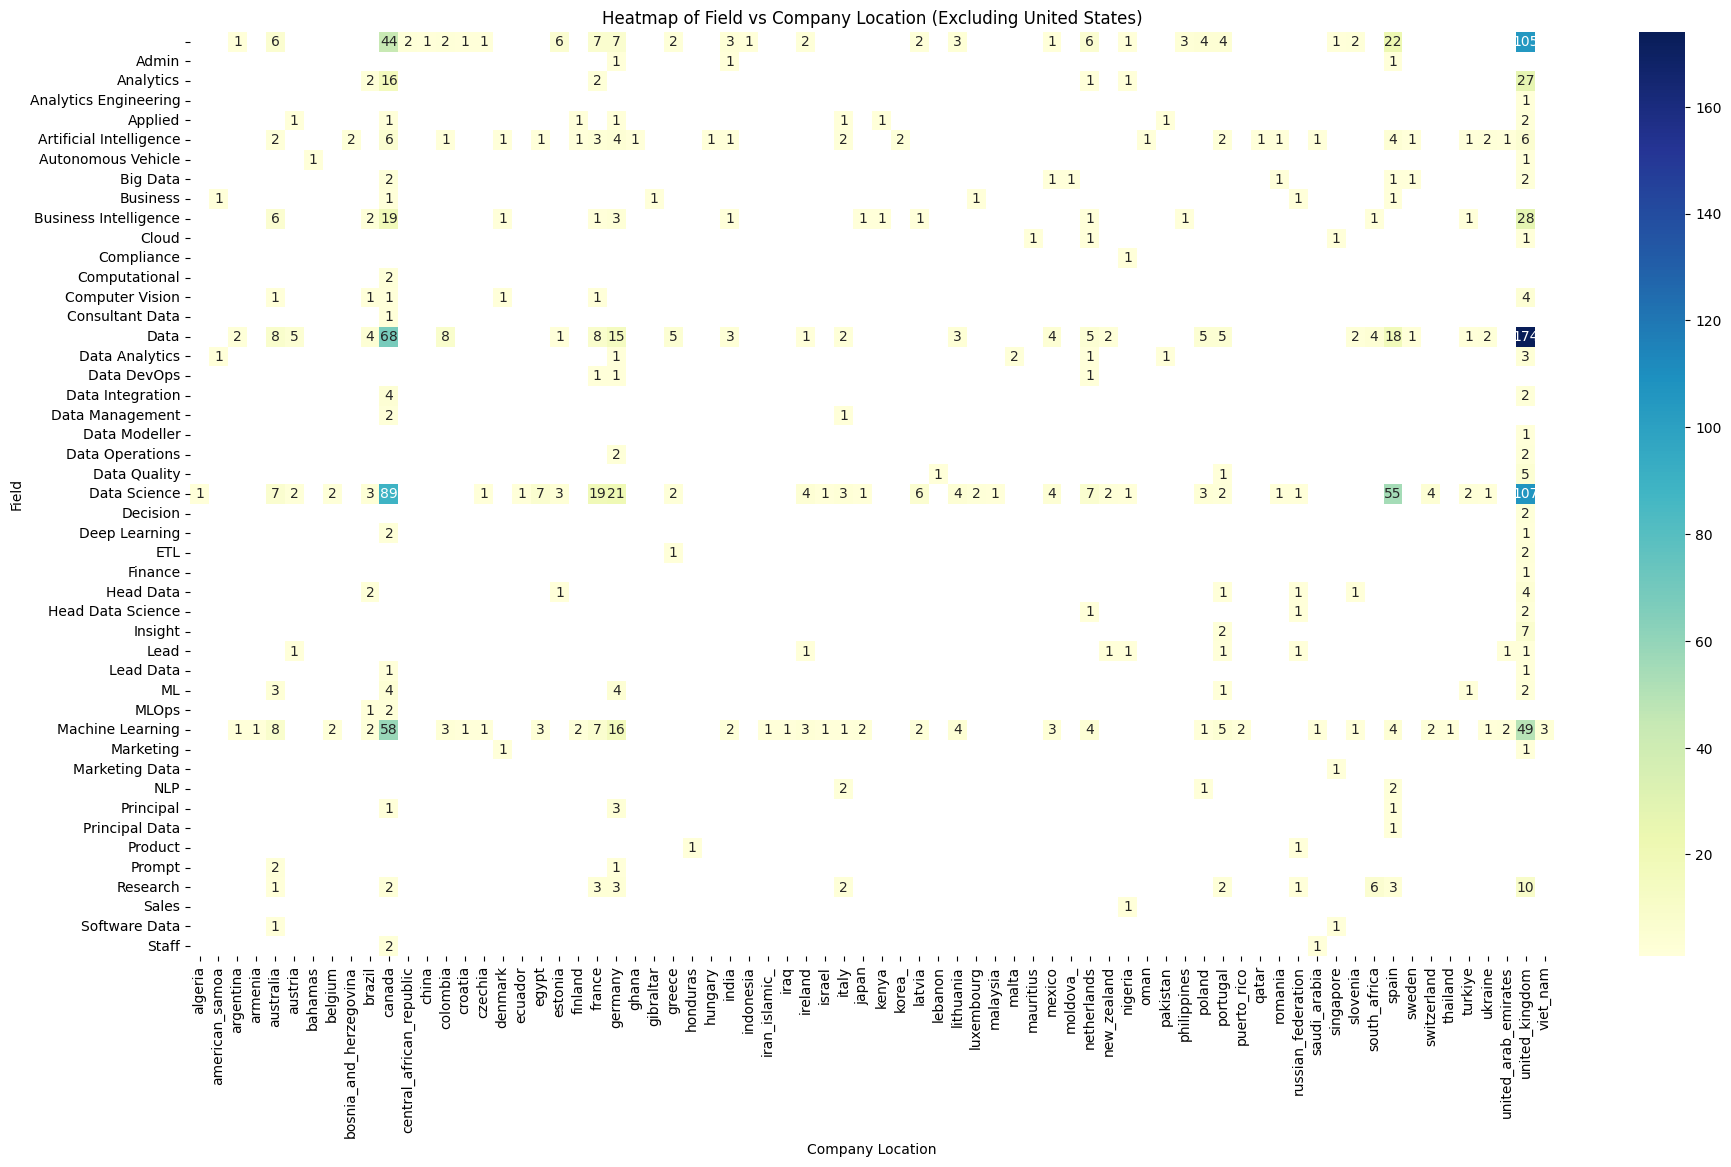

In [23]:
# Create a pivot table
pivot_table = df_processed.loc[df_processed['company_location'] != 'united_states'].pivot_table(index='field', columns='company_location', aggfunc='size', fill_value=0)
#hide zeros: 
mask = pivot_table == 0
# Create the heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", mask = mask)

# Set the labels
plt.xlabel('Company Location')
plt.ylabel('Field')
plt.title('Heatmap of Field vs Company Location (Excluding United States)')

# Show the plot
plt.show()

We look back at Denmark and see there are only four fields that have a listing: Marketing, Computer Vision, Business Intelligence, AI. All four of these fields hold only one listing - The pay discrepancy seen in the boxenplots might just be explained by the overall low number of listings in various fields. Because of this we will not further investigate wage inequality as the low number of listings makes it difficult to make meaningful statements. 

# 5 Grouping countries
We want to group countries into categories, there are a few ways to do this: 
1) Group based on geography (e.g. Europe, Asia, Africa, etc.): We have to ask ourselves "does this make sense for the wage?" i.e. is the wage tied to the geography of the country? If yes, then we can group by geography. If not, then we should look for another measure. We can use some common sense here: Mexico and Canada neighbour the US. However we see extremely divergent wages. (Boxenplot). So No, we're not going to group based on geography. 
2) GDP: We can group countries by GDP. This is a good measure because it is a good proxy for the wealth of a country (and the cost of living). We need to combine data from another source to make this work (World Bank or something). However, GDP or GDP per capita is a number - not a group so we still need to group them together based on some kind of clustering
3) World Bank Income Classification: this reduces the country dataset to easier to handle categories: Low, Lower-middle, Upper-middle, High-income countries. This is interesting for a few reasons: 
    - prevents feature inflation and long compute times. 
    - World Bank did studies on this and we can use their results. Better than winging it ourselves with the risk of making mistakes. (besides, with this dataset we only have income dat for IT jobs, this does not allow us direclty to make a statement for the overall income streams in a country)

To pull of the latter we need requests and need to download the data from the world bank: 

* WB Blogpost: https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025 
* downloadable dataset: https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls 

We'll also need to do some kind of fuzzy matching (rapidfuzz, Levenshtein distance,....) When using this kind of fuzzy matching keep in mind to reduce some errors by preprocessing all countries in the same way!




## 5.1. Downloading and processing World Bank data

In [24]:
dataset_url = 'https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls'
r = requests.get(dataset_url)
dest = "data/raw/OGHIST.xls"
with open(dest, "wb") as f:
    f.write(r.content)

In [25]:
income_df = pd.read_excel(dest, sheet_name='Country Analytical History', header= 5)   #year is in row 5
income_df = income_df.dropna(subset=['Unnamed: 0'])[['Unnamed: 0', 'Data for calendar year :', 2021]]
income_df = income_df.rename(columns={
    'Unnamed: 0': 'countrycode', 
    'Data for calendar year :': 'country',
    2021: 'rating'
    })

In [26]:
income_df = h.cleanup_strings(income_df, 'country', cleanup_countries)

In [27]:
income_df.sample()

countrycode            country rating
96         IRN  iran_islamic_rep.     LM

## 5.2 fuzzy matching: alligning both dataframes

In [28]:
df_processed = h.assign_country_codes(df_processed, income_df, 'company_location', 'country', 'countrycode', 'comp_location_WBI_code')
df_processed = h.assign_country_codes(df_processed, income_df, 'employee_residence', 'country', 'countrycode', 'employee_residence_WBI_code')

Fuzzy matching is done, I want to check if there are mistakes and manually correct these: 

Initially the code showed mistakes for egypt, korea_ (we're assuming south), czechia. All the rest is fine. The cause of the error is a high distance in the scoring algorithm. i'm not going to update the alghoritm - in stead just add these to the code as extra checks. Reason for this is that other countries are fine and an update to the algo might throw those off. The added code will use basic string matching and update the relevant rows. 

In [29]:
unique_rows = df_processed[['company_location', 'comp_location_WBI_code']].drop_duplicates()
unique_rows.sample(5)

company_location comp_location_WBI_code
554            latvia                    LVA
6580          algeria                    DZA
2316      switzerland                    CHE
5606         viet_nam                    VNM
6917         moldova_                    MDA

In [30]:
df_processed.sample(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size    target  employee_of_country             field              title comp_location_WBI_code employee_residence_WBI_code
5416        2024           Senior       Full-time             Data Scientist      united_states    In-person    united_states            M  156400.0                 True      Data Science     Data Scientist                    USA                         USA
2089        2023           Senior       Full-time          Applied Scientist      united_states       Remote    united_states            M  176640.0                 True                    Applied Scientist                    USA                         USA
11439       2024           Senior       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  236440.0                 True  Machine Learning           Engineer                    USA                         USA
4998        2023        Executive       Full-time             Data Scientist      united_states       Remote    united_states            M  229632.0                 True      Data Science     Data Scientist                    USA                         USA
12730       2022           Senior       Full-time              Data Engineer      united_states       Remote    united_states            M  132480.0                 True              Data           Engineer                    USA                         USA

In [31]:
df_processed.loc[df_processed['comp_location_WBI_code'].isna()]  #GOOD! all company_location coutnries have a code assigned matching the WBI data.

Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, employee_residence, work_setting, company_location, company_size, target, employee_of_country, field, title, comp_location_WBI_code, employee_residence_WBI_code]
Index: []

In [32]:
df_processed.loc[df_processed['employee_residence_WBI_code'].isna()]  #GOOD! all employee_residence coutnries have a code assigned matching the WBI data.


Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, employee_residence, work_setting, company_location, company_size, target, employee_of_country, field, title, comp_location_WBI_code, employee_residence_WBI_code]
Index: []

## 5.4 Add income category of World Bank to df: 
fuzzy matching alligned both dataframes; now add the income code of the World Bank for both columns! The good thing is now that we found a way to ditch all the different countries and replace them by one column which makes sense to use an Ordinal Encoder on!! :)

In [33]:
rating_map = income_df.set_index('countrycode')['rating'].to_dict()
#for the country location: 
df_processed['location_income_category'] = df_processed['comp_location_WBI_code'].map(rating_map)
#for the employee residence:
df_processed['residence_income_category'] = df_processed['employee_residence_WBI_code'].map(rating_map)


In [34]:
df_processed.sample(6)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size    target  employee_of_country             field               title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category
7238        2024      Entry-level       Full-time          Research Engineer      united_states    In-person    united_states            M  128800.0                 True          Research            Engineer                    USA                         USA                        H                         H
5559        2024           Senior       Full-time               Data Analyst      united_states    In-person    united_states            M   78660.0                 True                          Data Analyst                    USA                         USA                        H                         H
7913        2022        Mid-level       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  138000.0                 True  Machine Learning            Engineer                    USA                         USA                        H                         H
1387        2024           Senior       Full-time         Research Scientist      united_states    In-person    united_states            M  256404.0                 True                    Research Scientist                    USA                         USA                        H                         H
11361       2023           Senior       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  158424.0                 True  Machine Learning            Engineer                    USA                         USA                        H                         H
5935        2024           Senior       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  197800.0                 True  Machine Learning            Engineer                    USA                         USA                        H                         H

# 6: Further visualisations:
Listings per country where too sparse to really do something meaningful with - I opted to use studies by the World Bank to allow Ordinal encoding at a later stage. Right now I need to make a few more visualisation on the actual wages. Some questions I want to see answered: 
1) Did wage change over time (work_year + target)
2) How are wages evolving in each different country (we replaced countrycodes by income categories in step 5). 
3) Relation of wage and field. 
4) Pick a field with a lot of different listings and see if title makes a difference. 
5) In the overall dataset, does company size matter in relation to wage? 
6) In the overall dataset, does experience matter in relation to wage? 
7) What is the impact of on vs off-site work?
8) What is the impact of employment duration( half-time/full-time)
9) Is exerperience equally distributed across company sizes?

before we go there, let's make a few high level plots to see how the data is distrubuted. We already know USA is the biggest country. What about other columns? 

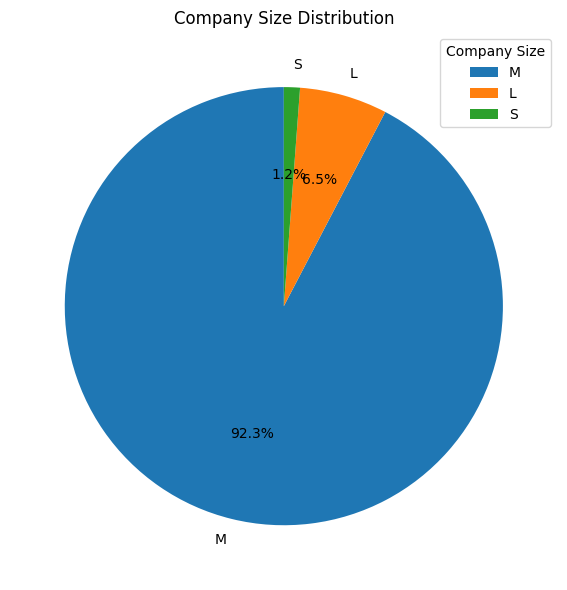

In [35]:
# company size distribution?
company_size_counts = df_processed['company_size'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Company Size Distribution')
plt.legend(company_size_counts.index, title='Company Size', loc='best')
plt.tight_layout()
# >> heavily in favor of medium sized companies.

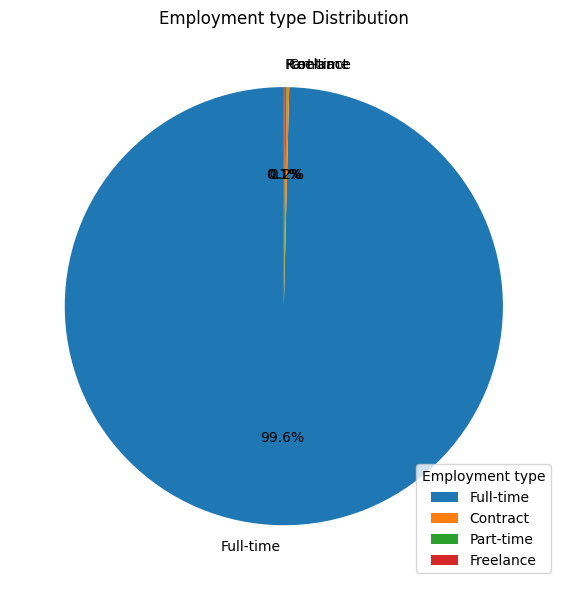

In [36]:
# Employment type distribution?
company_size_counts = df_processed['employment_type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Employment type Distribution')
plt.legend(company_size_counts.index, title='Employment type', loc='best')
plt.tight_layout()
# >> Extremely in favor of full-time contract.!!

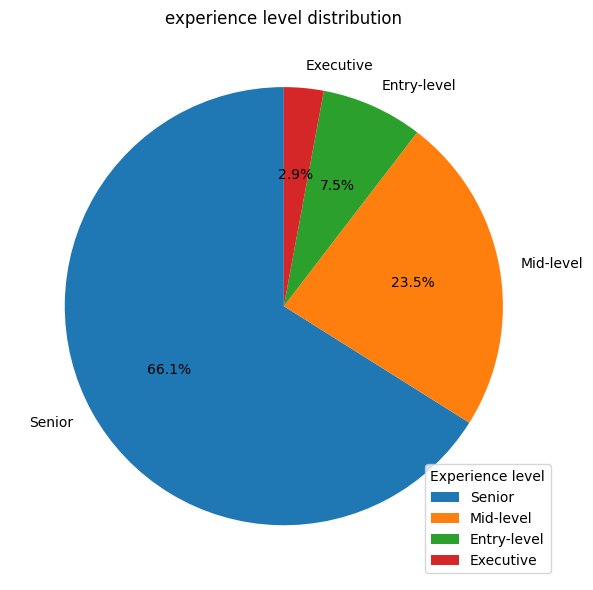

In [37]:
# Employment experience level distribution?
company_size_counts = df_processed['experience_level'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('experience level distribution')
plt.legend(company_size_counts.index, title='Experience level', loc='best')
plt.tight_layout()
# >> quite in favor of senior positions.

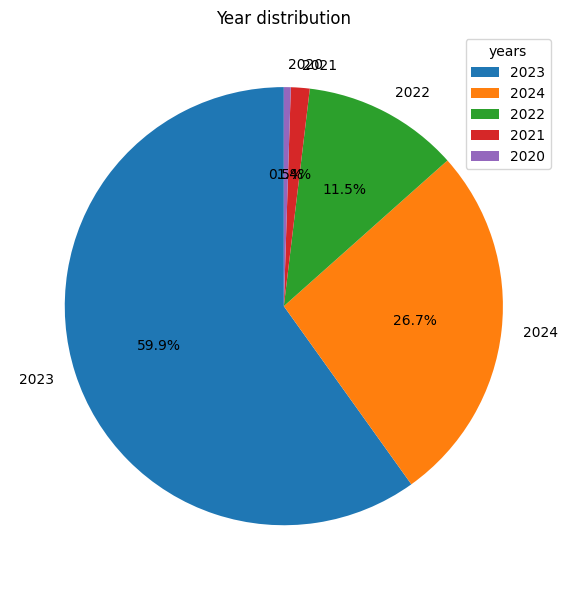

In [38]:
# workyear distribution?
company_size_counts = df_processed['work_year'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Year distribution')
plt.legend(company_size_counts.index, title='years', loc='best')
plt.tight_layout()
# >> quite in favor of more recent years; however 1/8th of the data is older than 2023!!! (impact of inflation might be visible)

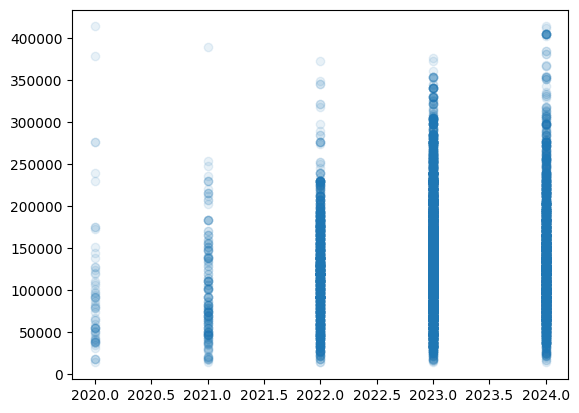

In [39]:
plt.scatter(df_processed['work_year'], df_processed['target'], alpha=0.1)

## 6.1. Wage evolution over time: 

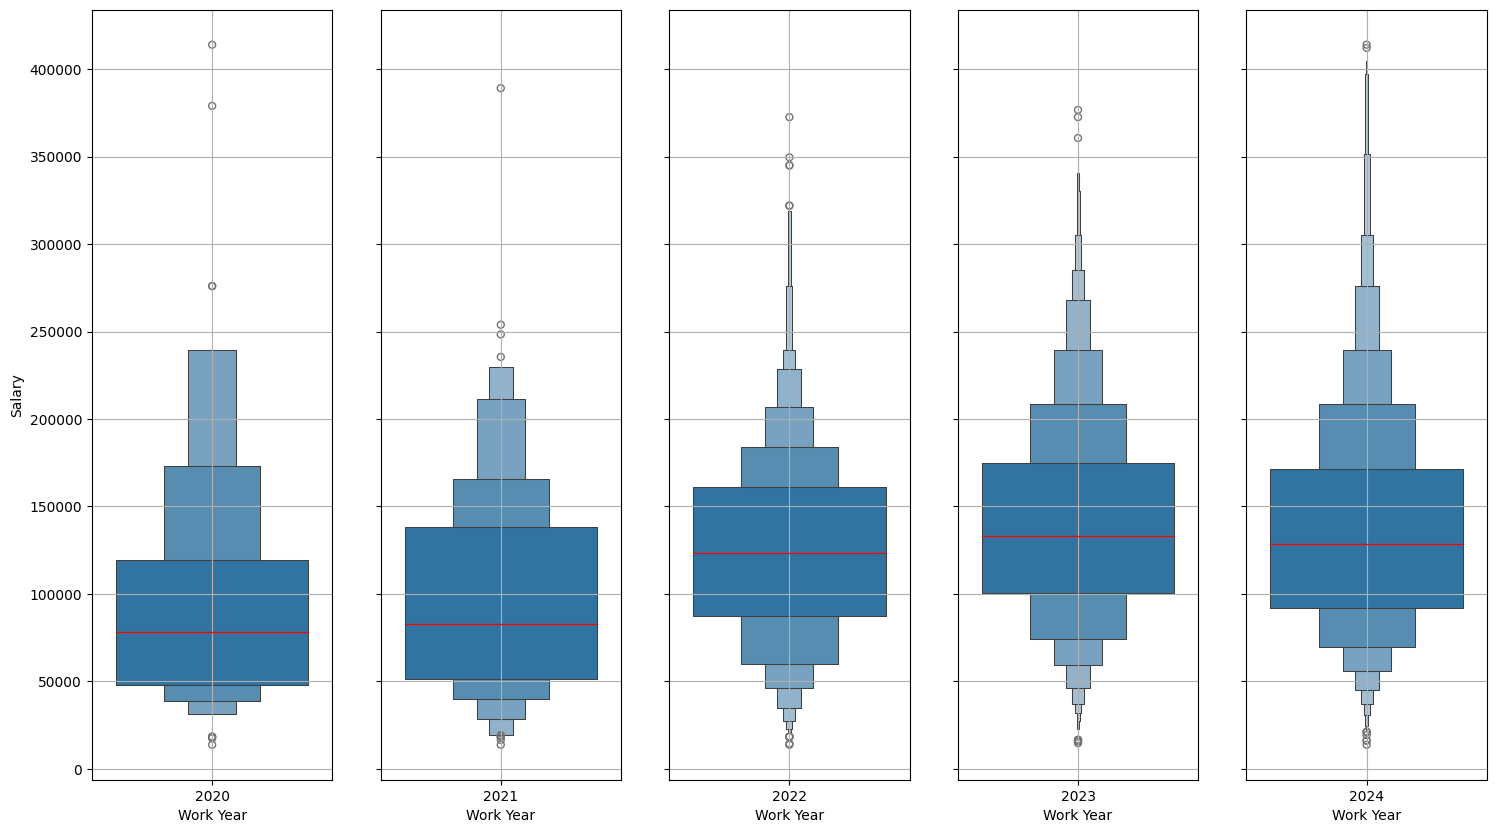

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[df_processed['work_year'] == year], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work Year')
    ax.set_ylabel('Salary')
    ax.grid(True)
plt.show()

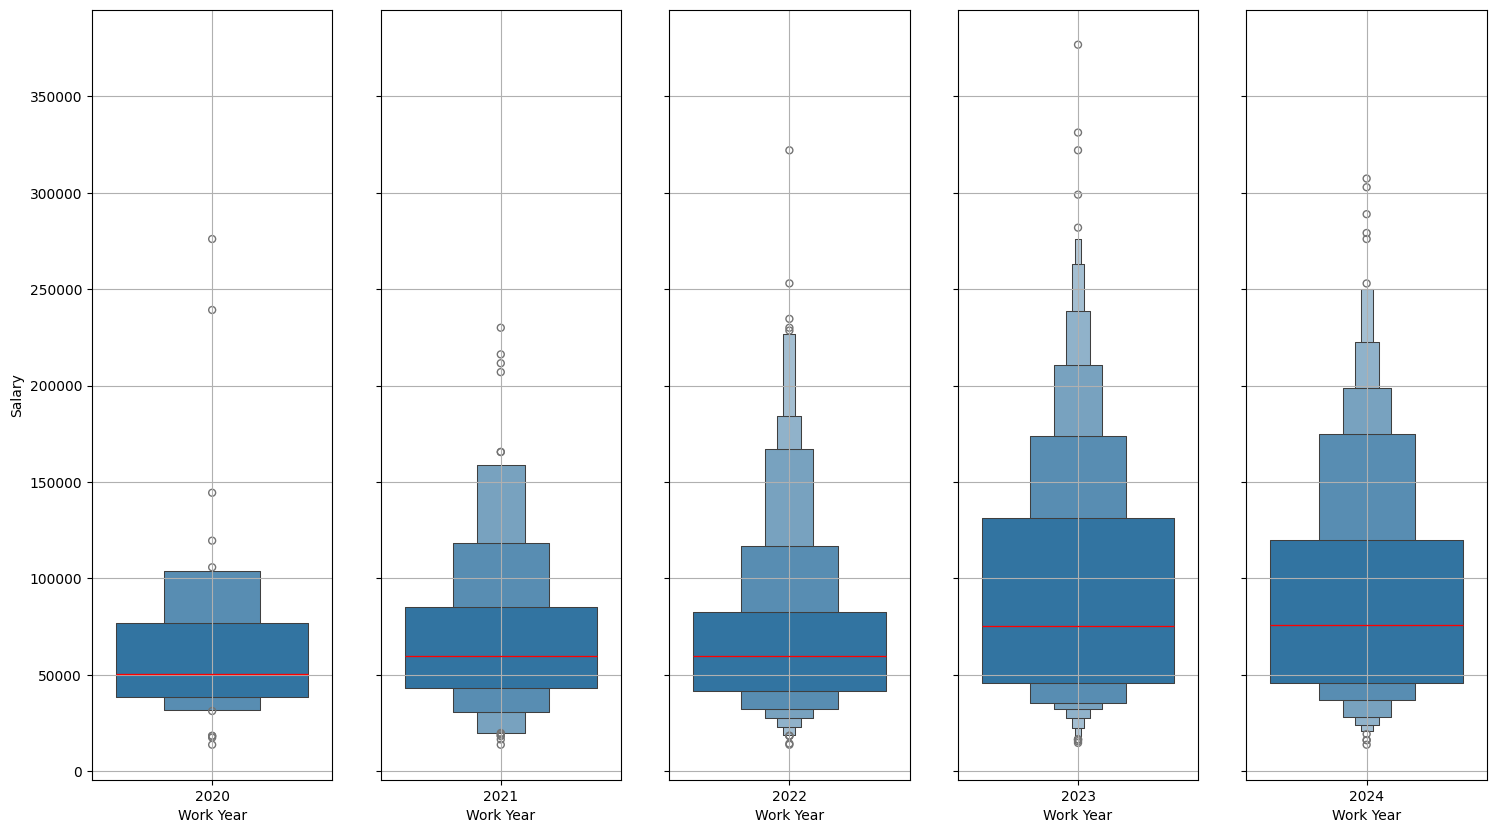

In [41]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[(df_processed['work_year'] == year) & (df_processed['comp_location_WBI_code'] != 'USA')], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work Year')
    ax.set_ylabel('Salary')
    ax.grid(True)
plt.show()

6.1 Answer ==> YES in the overall dataset wage changed significantly over time. We can see the effect very clear for the full dataset (first boxenplot); when we ommit wages paid in the USA we see that the overal conclusion remains, but is less pronounced. Overall I'd say work year is a significant factor in determining the target.

The countrycode seems to be a factor too. Let's see how important it is with a linechart/timeseries setup. 

## 6.2. Country wage evolution over time

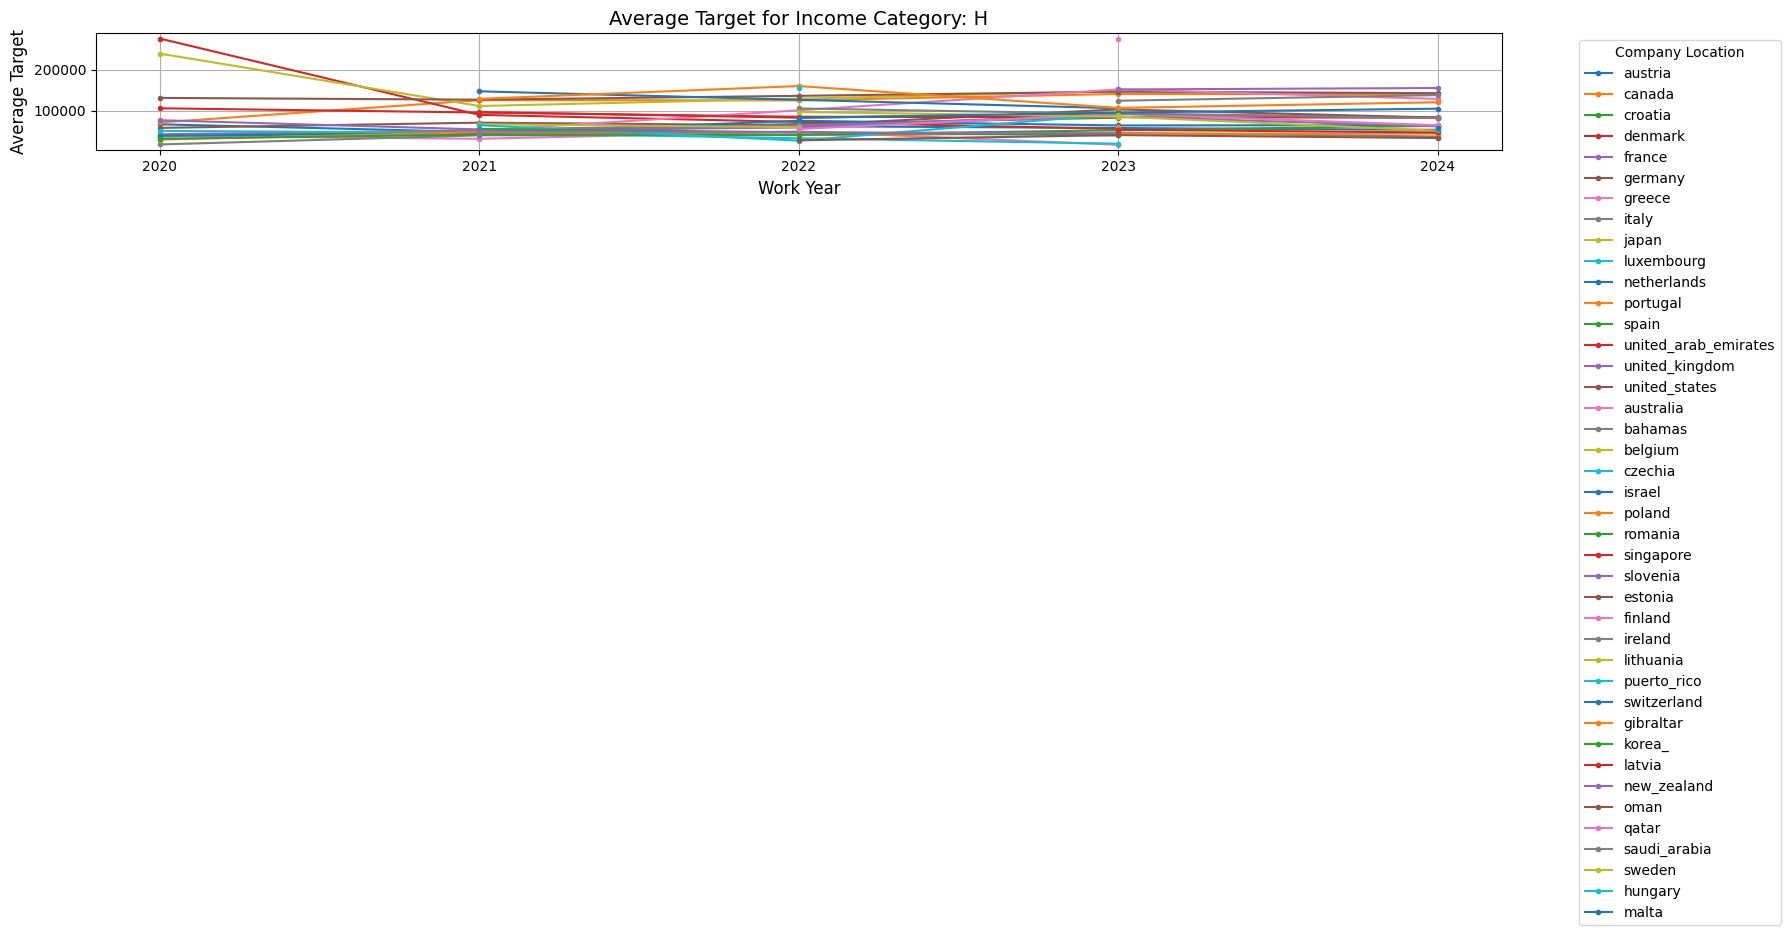

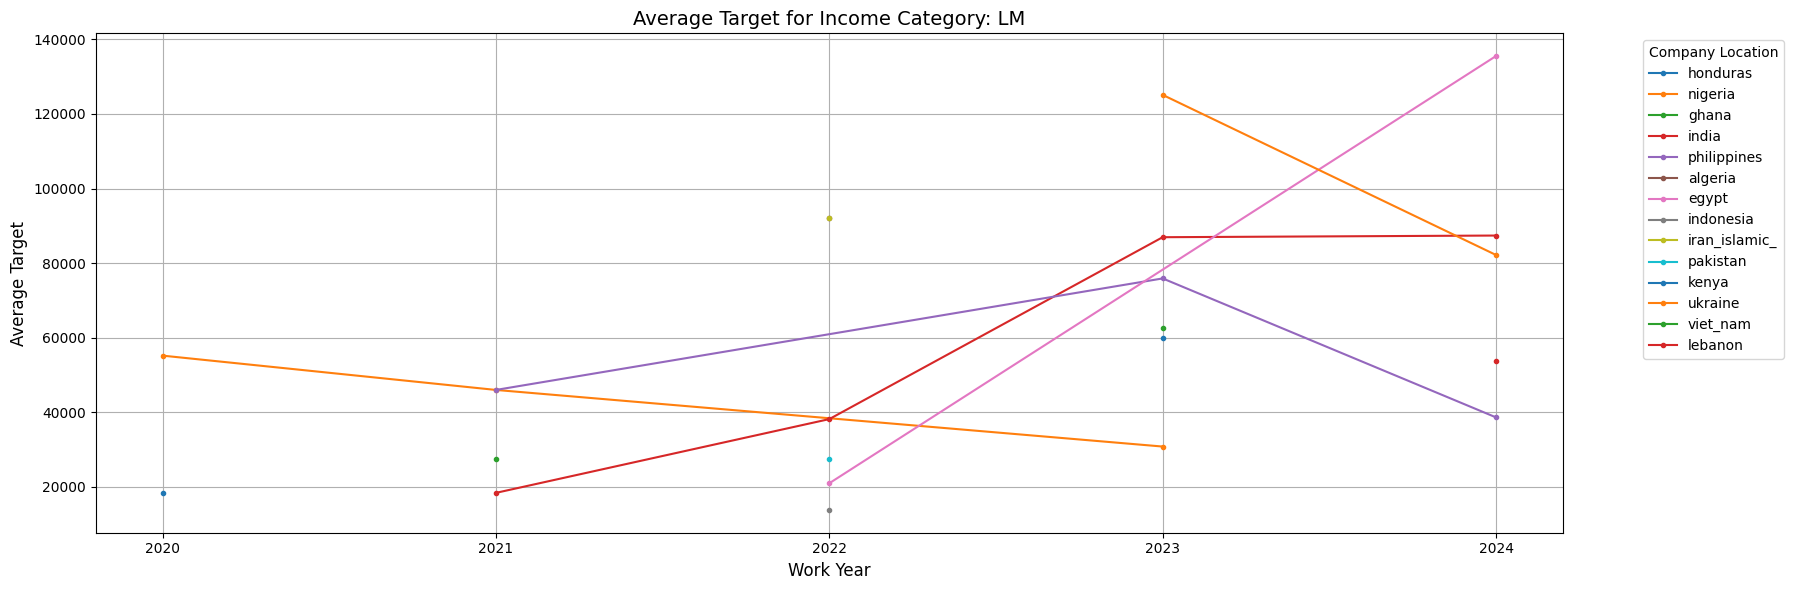

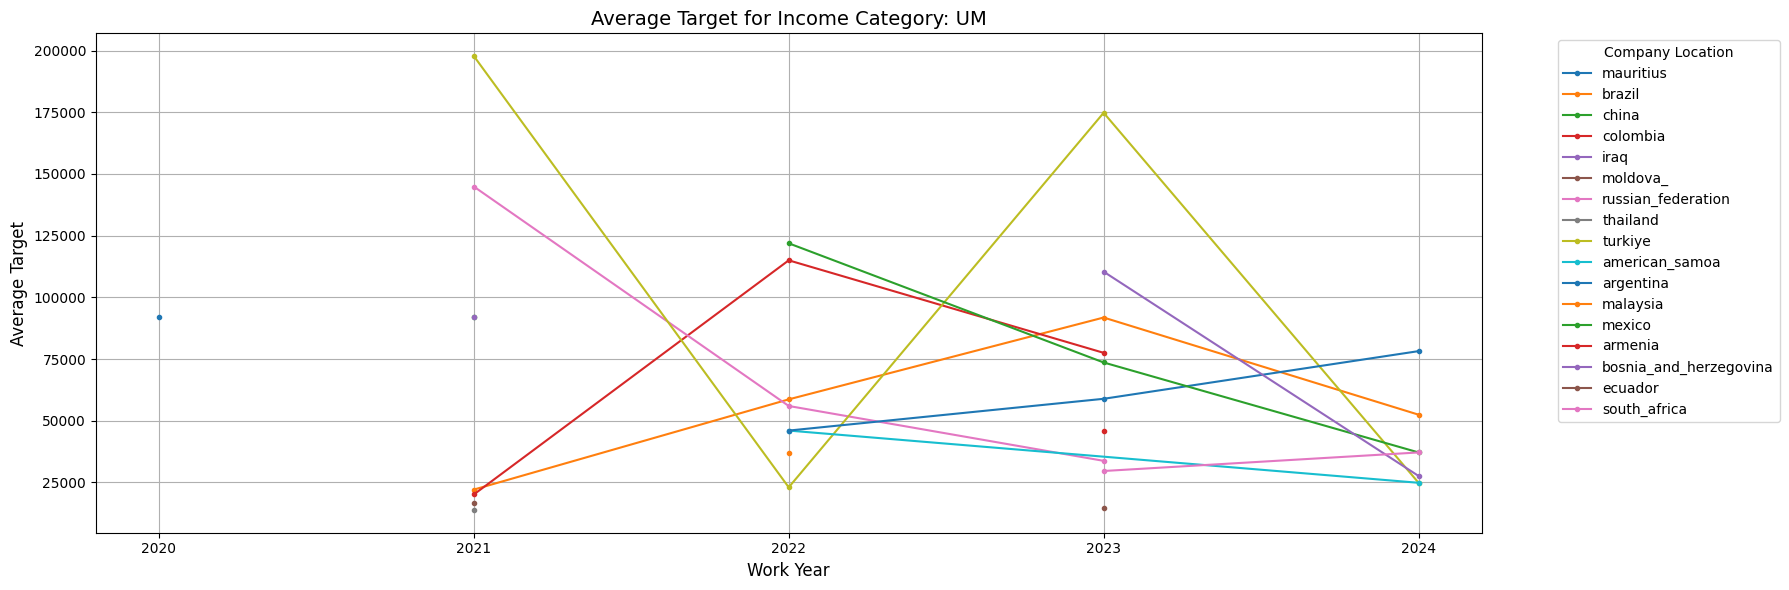

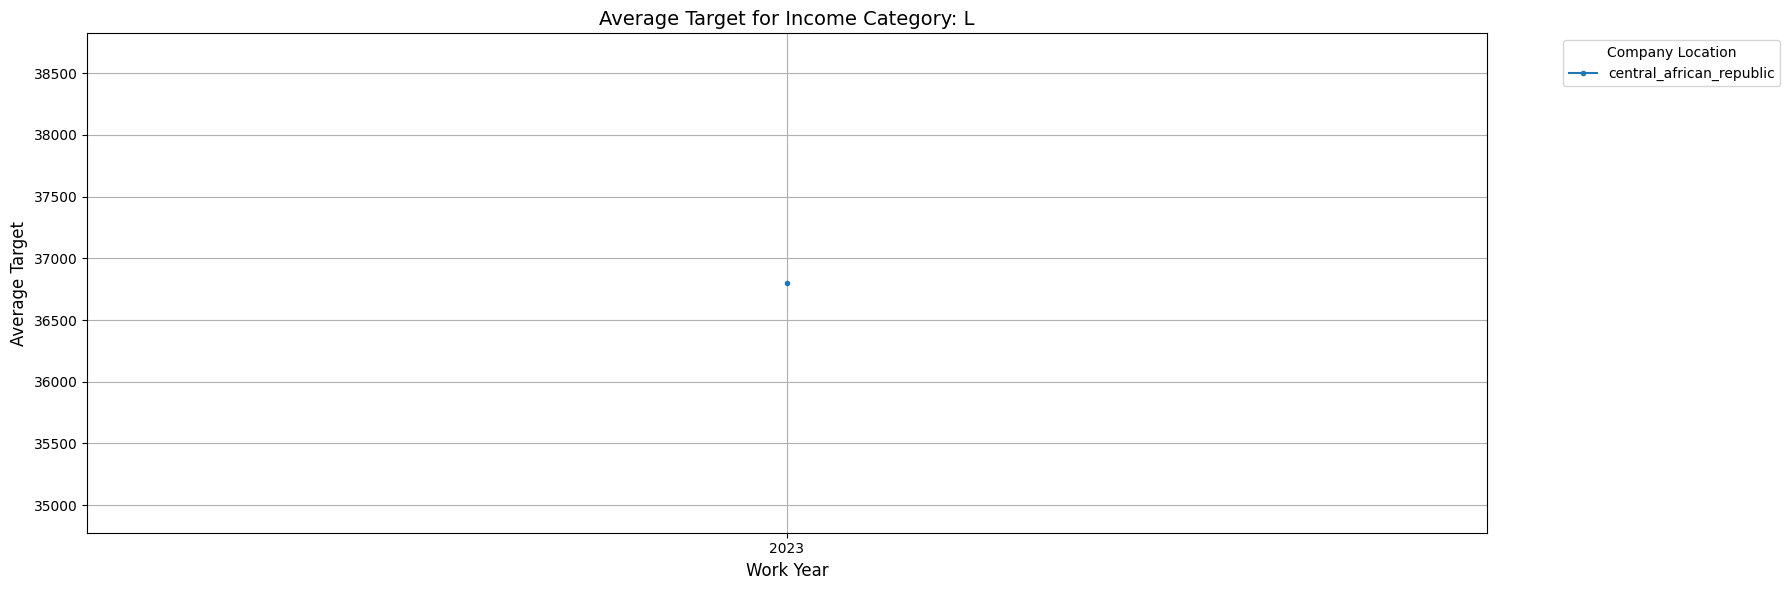

In [42]:
average_target = df_processed.groupby(['work_year', 'company_location', 'location_income_category'])['target'].mean().reset_index()

# Create separate plots for each 'location_income_category'
for category in df_processed['location_income_category'].unique():
    # Filter data for the current category
    category_data = average_target[average_target['location_income_category'] == category]
    
    # Initialize the plot
    plt.figure(figsize=(18, 6))
    
    # Iterate over each unique 'company_location'
    for location in category_data['company_location'].unique():
        location_data = category_data[category_data['company_location'] == location]
        plt.plot(
            location_data['work_year'],
            location_data['target'],
            marker='.',
            label=location
        )
        unique_years = category_data['work_year'].unique()
        plt.xticks(ticks=unique_years, labels=unique_years)
    # Customize the plot
    plt.title(f'Average Target for Income Category: {category}', fontsize=14)
    plt.xlabel('Work Year', fontsize=12)
    plt.ylabel('Average Target', fontsize=12)
    plt.legend(title='Company Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

some observations: 
1) the average wage for countries in the high-income category are less volatile than in any of the other categories. If we go back to the gridplot we can mostly explain this by there being more entries. 
2) High and Upper Middle countries seem to have quite some overlap - this could mean that we should keep the country added!!!! (we'll need to experiment with this)
3) A lot of countries are in the high income category - but even there we see a small upward trend. 

The best guess is to make two models and compare them using the RMSE (one with countries in OHE and one without the countries) - and see what performs best. 

## 6.3 Wages per field and per title
In an earlier phase we split up the job title in two parts: the field and the title (e.g. Data Science Developer became: field = data_science and title = developer). This was also done with the idea to reduce the need for too many columns when performing OHE on this. For now I quickly want to see how the wage distribution is per field per income category by country. We'll use a scatterplot. We've established that the year is important across the whole dataset, so we'll focus on a single year. Horizontal boxplots would work nicely for this. 

In [43]:
year = df_processed.work_year.value_counts().idxmax()
#most for 2023, let's use that as our focus year. 

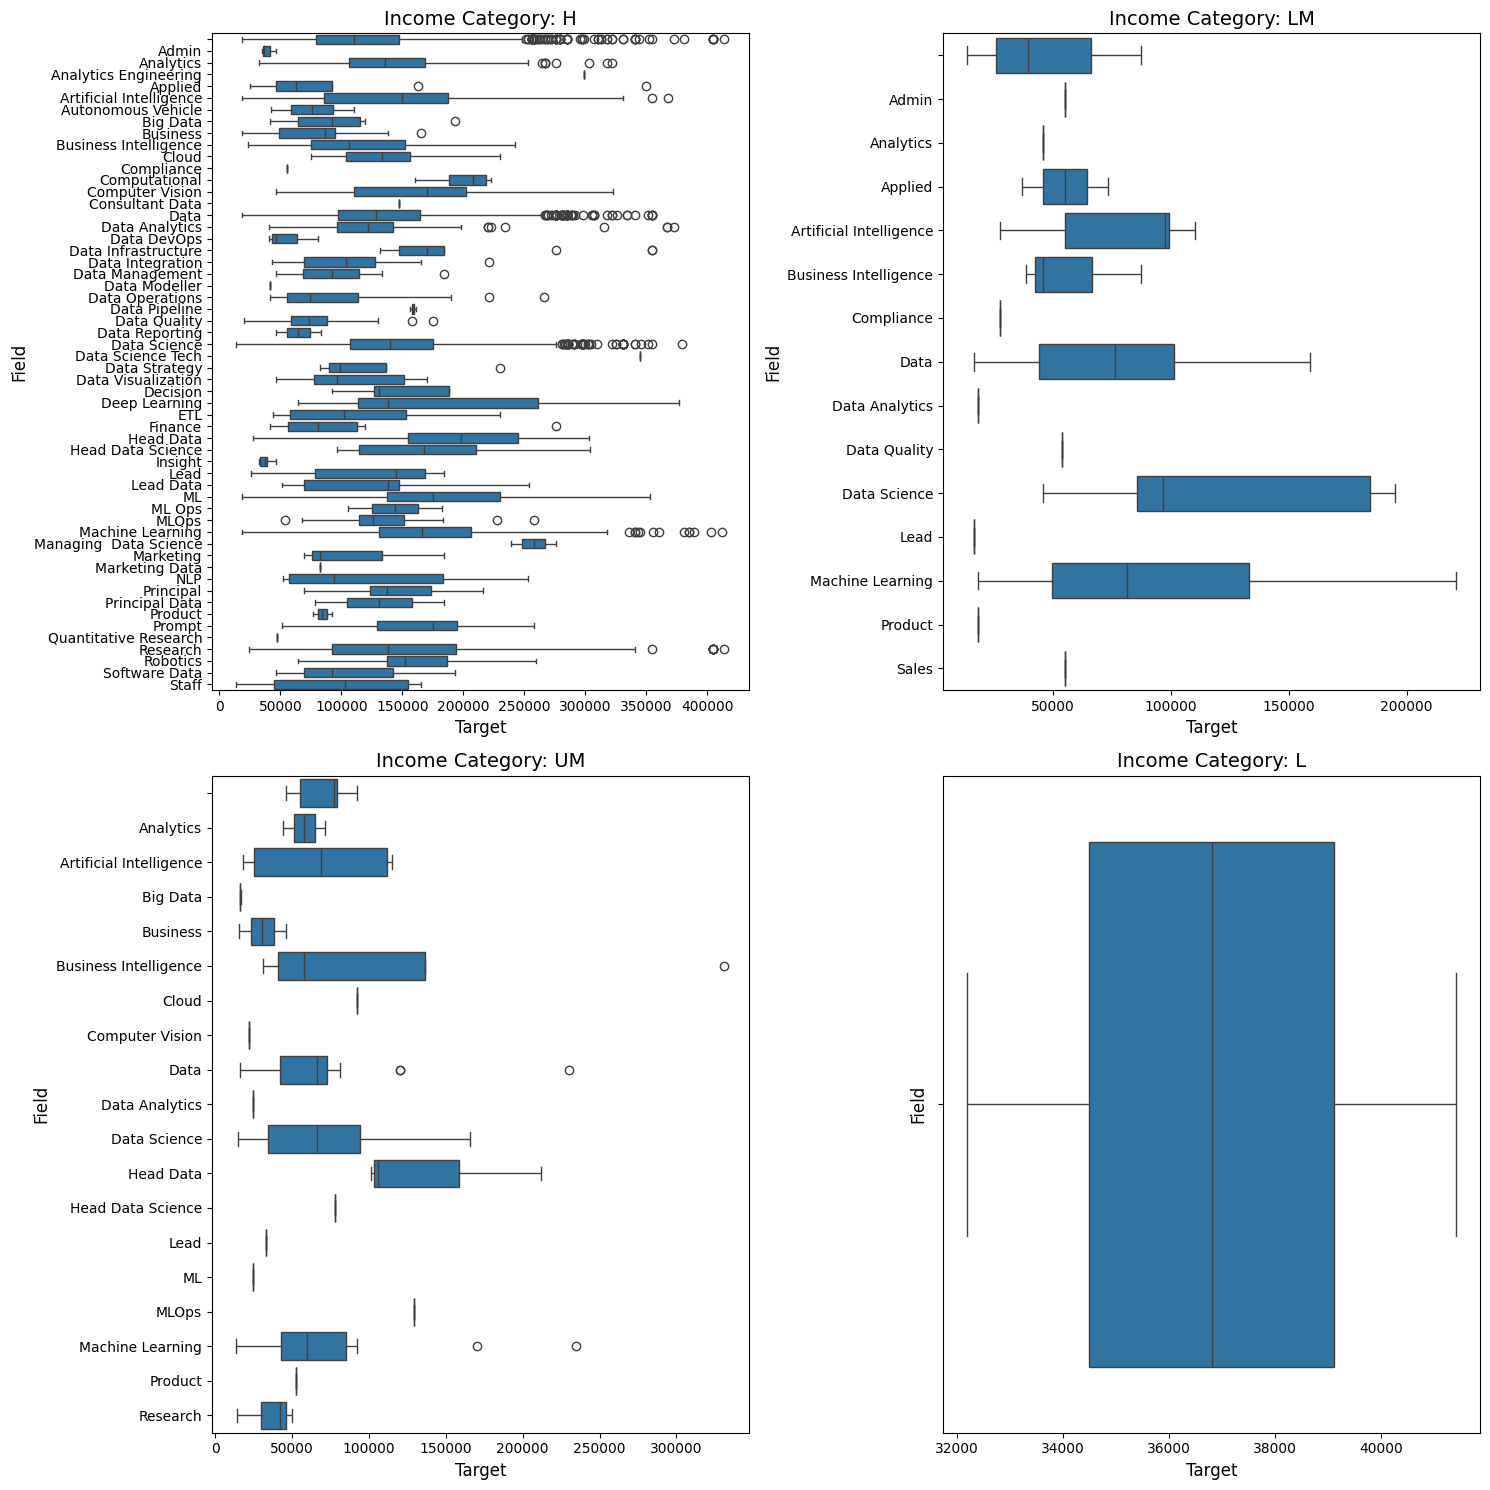

In [84]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[df_processed['location_income_category'] == category].sort_values(by='field')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='field',
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Field', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

For similar fields the split in H, UM, LM and L income categories seems to make sense - so the data provided from the WBI file is actually more usefull than the previous lineplots showed. 

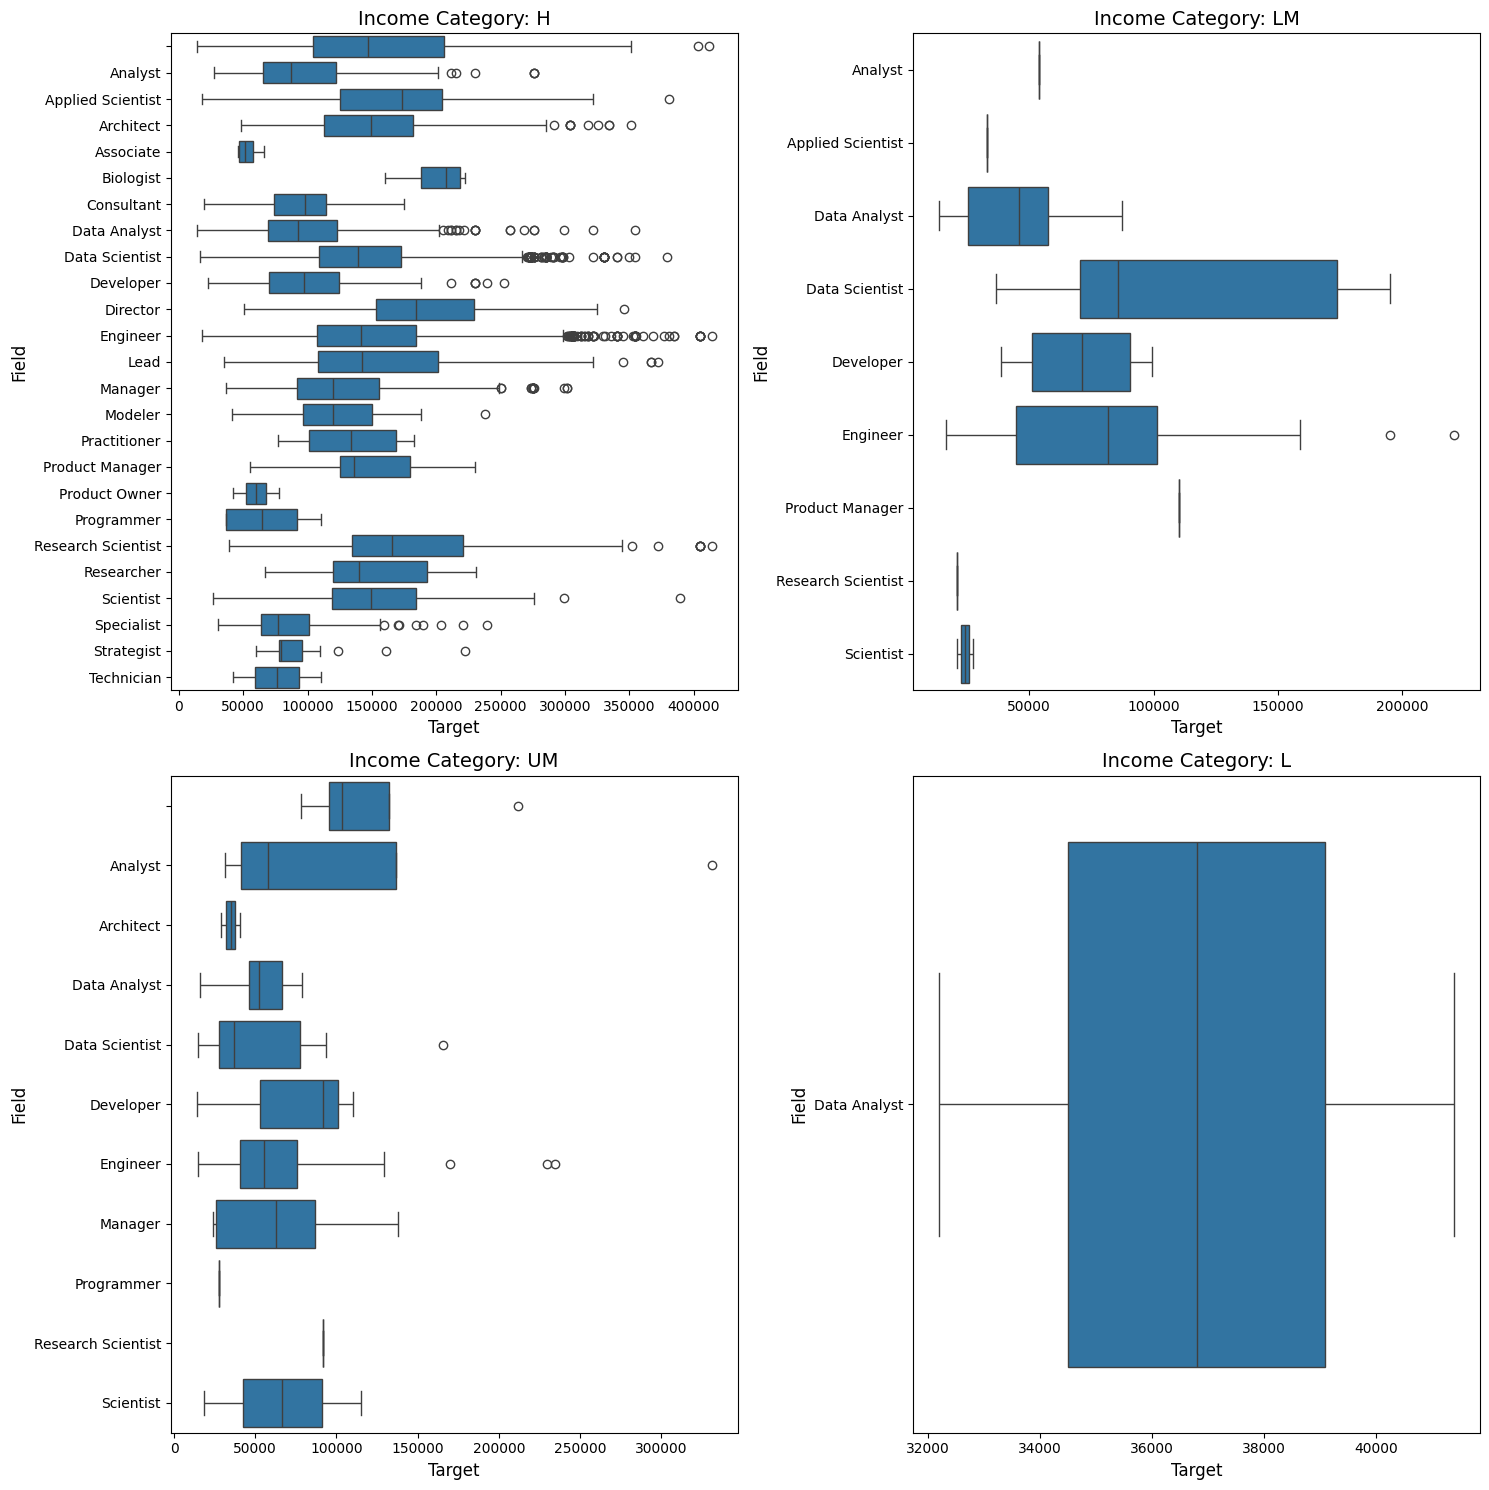

In [85]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[df_processed['location_income_category'] == category].sort_values(by='title')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='title',
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Field', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

## 6.4 Wages per level in a given field

In [45]:
topfield = df_processed.query("work_year == @year").field.value_counts().idxmax()
topfield

'Data'

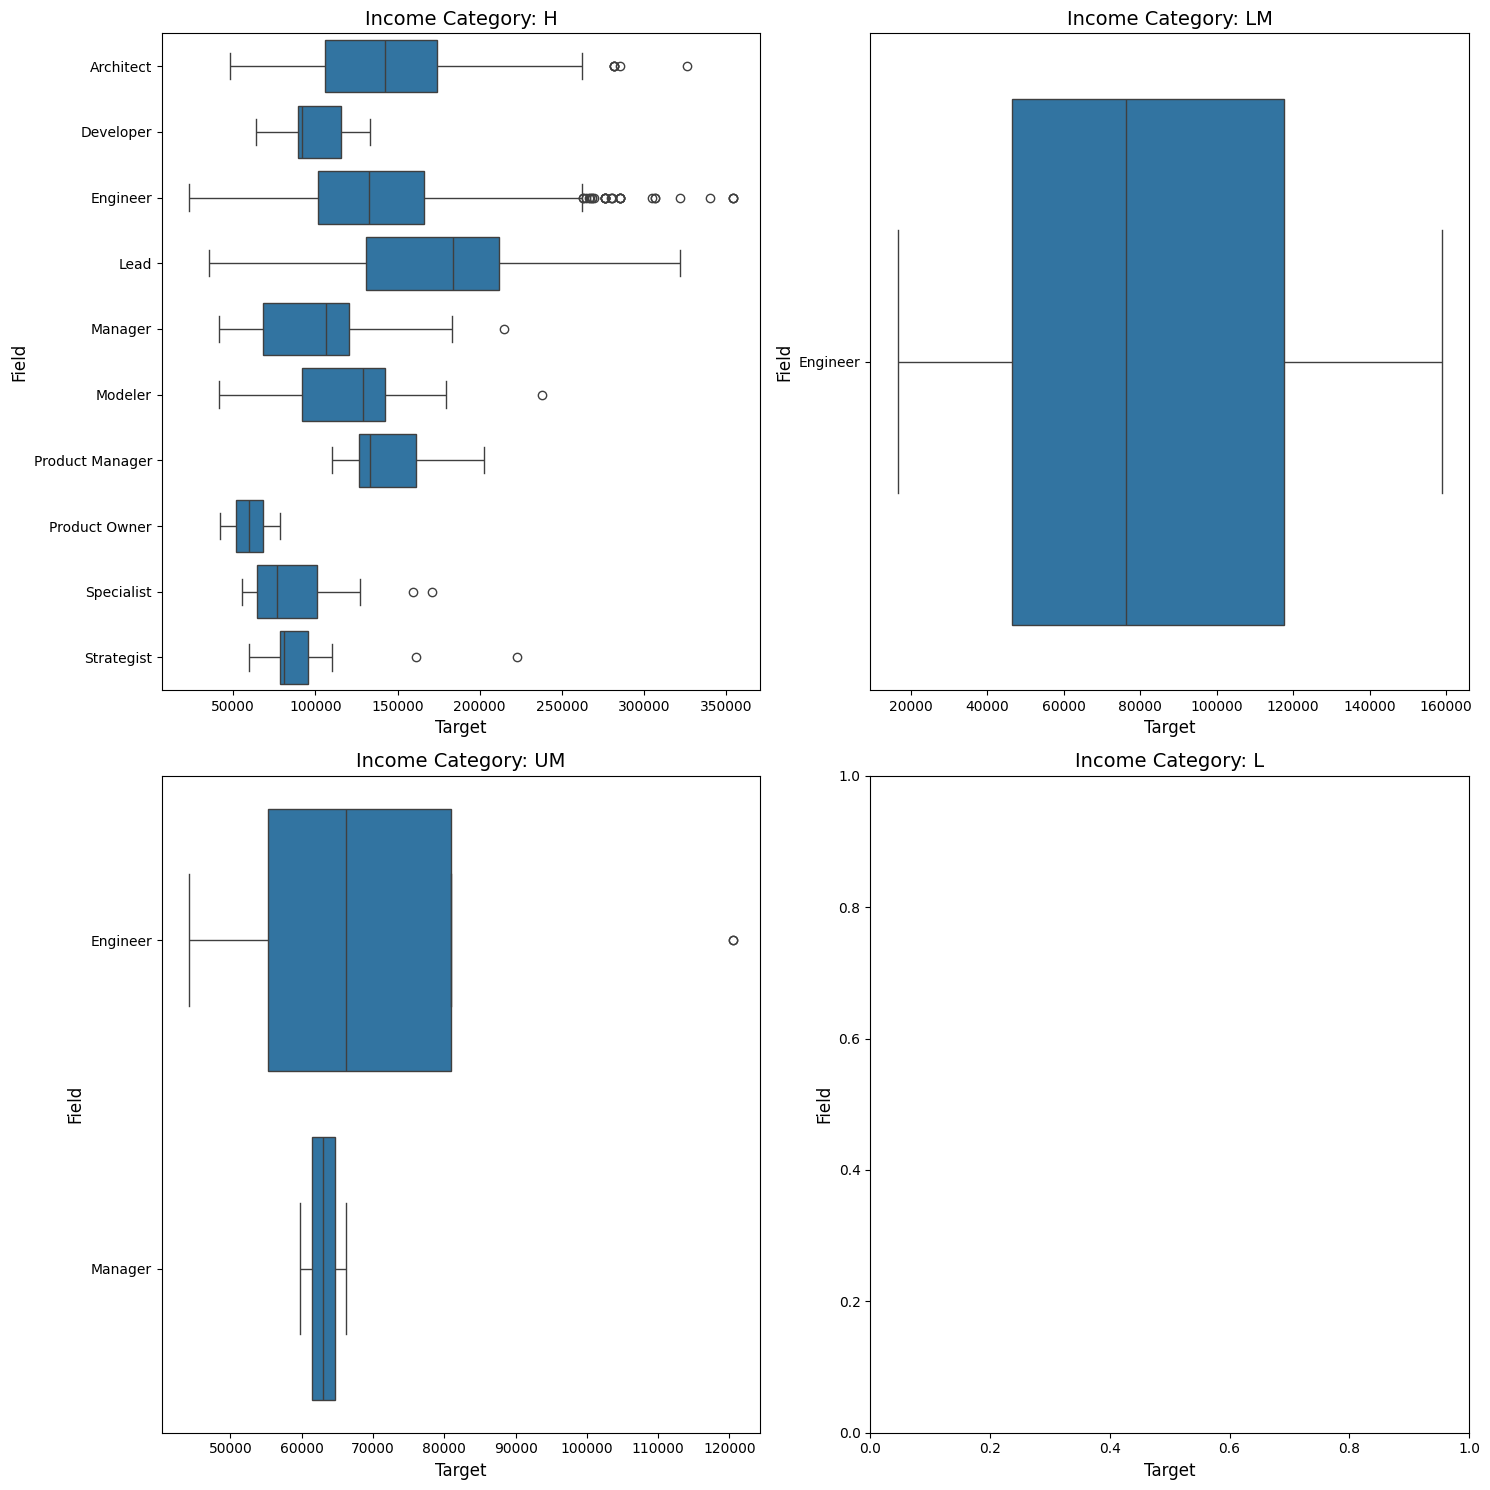

In [46]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[
        (df_processed['location_income_category'] == category) & 
        (df_processed['field'] == topfield) &
        (df_processed['work_year'] == year)
        ].sort_values(by='title')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='title',  # Replace 'field' with the actual column name
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Field', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## 6.5 Company Size vs Wage
so far we have established that the following factors contribute to the wage determination: 
- work_year (base feature)
- country (base feature)
- field (engineered feature)
- title (engineered feature)

To see if there's a correlation betwene company size and wage we'll need to look for a large enough subset with features that are similar to the ones above. 

In [47]:
#these are all the keys i want to grluop by on for all of the next questions I want to answer. For each questin I just remove one of the strings as part of my call to the make_clusters function.
groupbykeys = ['work_year', 'company_location', 'title', 'field', 'employment_type', 'experience_level', 'company_size', 'work_setting']  

In [48]:
key_for_question = 'company_size'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type experience_level work_setting  count
849       2023    united_states        Engineer              Data       Full-time           Senior    In-person    753
798       2023    united_states  Data Scientist      Data Science       Full-time           Senior    In-person    685
884       2023    united_states        Engineer  Machine Learning       Full-time           Senior    In-person    579
799       2023    united_states  Data Scientist      Data Science       Full-time           Senior       Remote    420
777       2023    united_states    Data Analyst                         Full-time           Senior    In-person    355

we have a few good ones to use with constraints as follows: 
- year = 2023 (logical, we have most data for 2023)
- company_location = united_states (logical, we have most data for USA)
- title = Engineer
- field = Data
- Employment_type = Full-time
- work_setting = In-person
- Experience_level = Senior

We'll use these constraints to plot the wage in function of the company size.


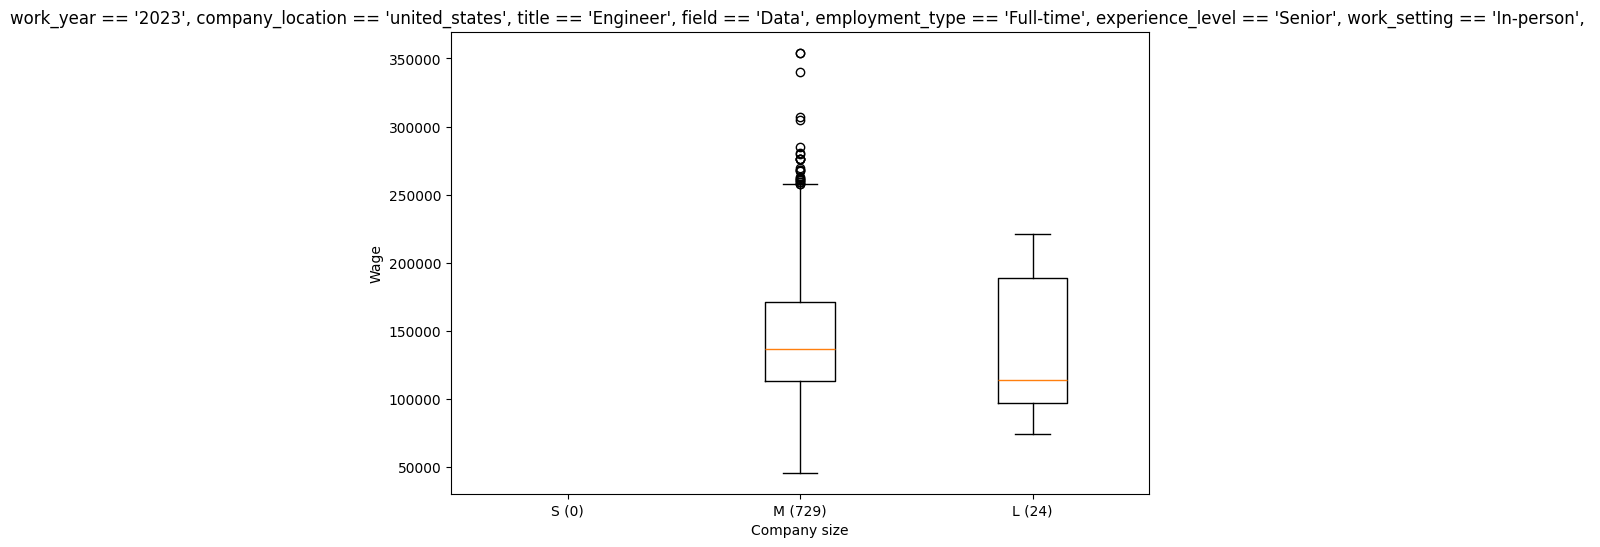

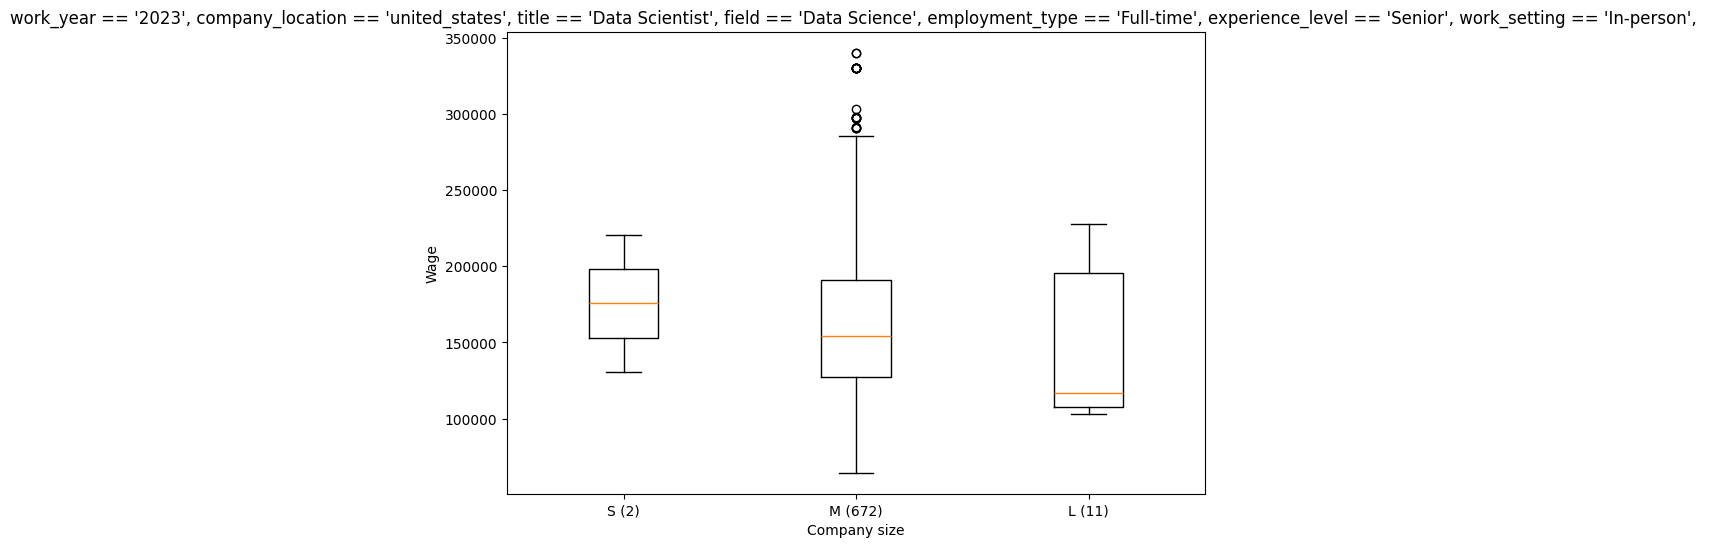

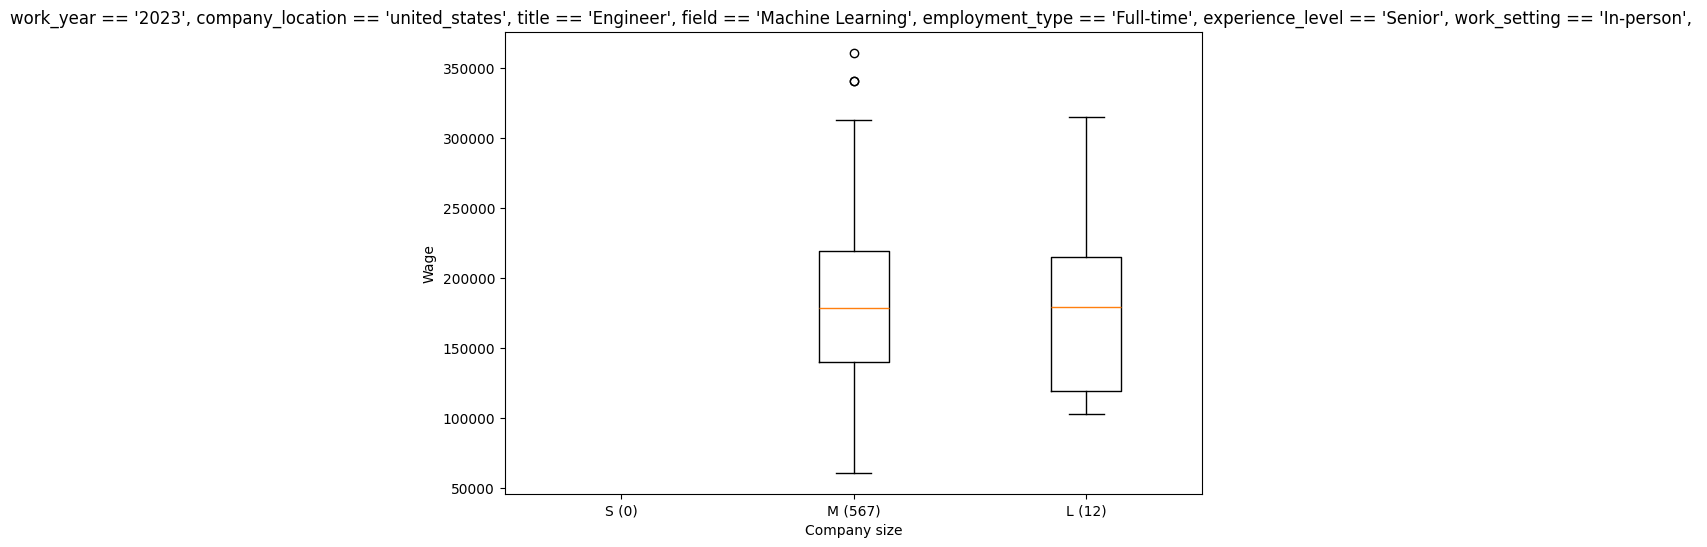

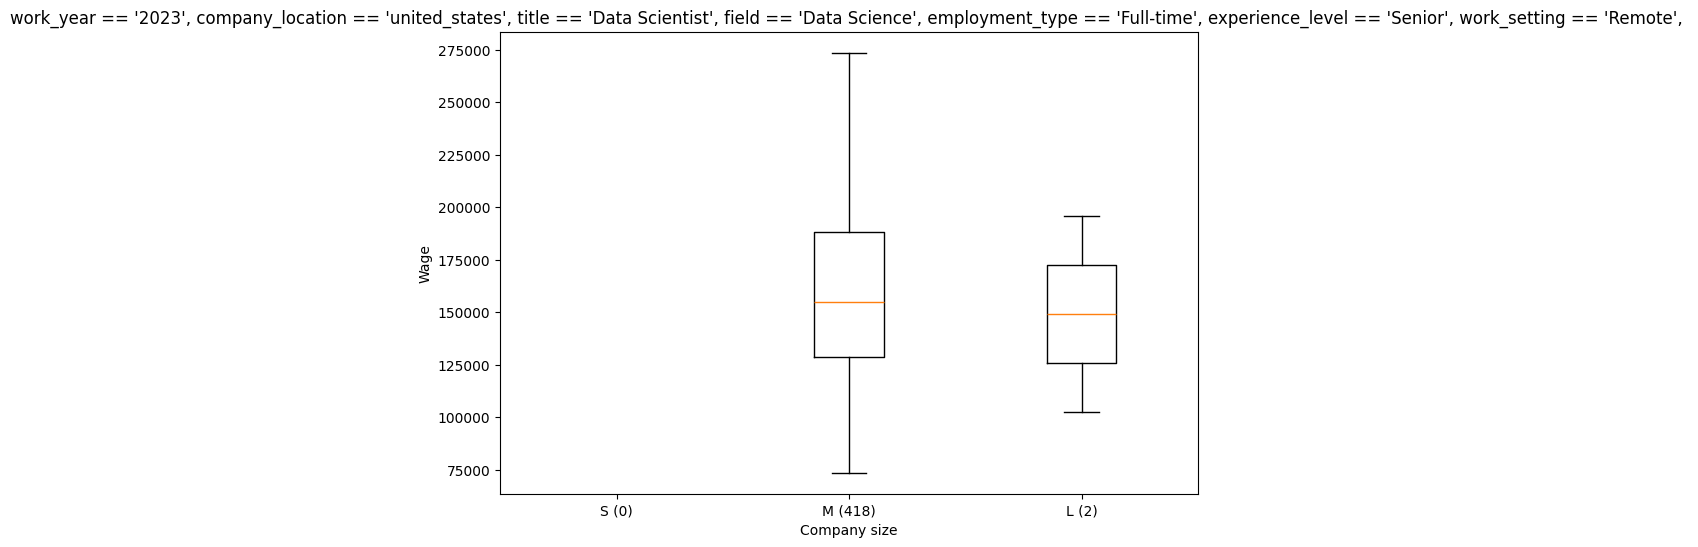

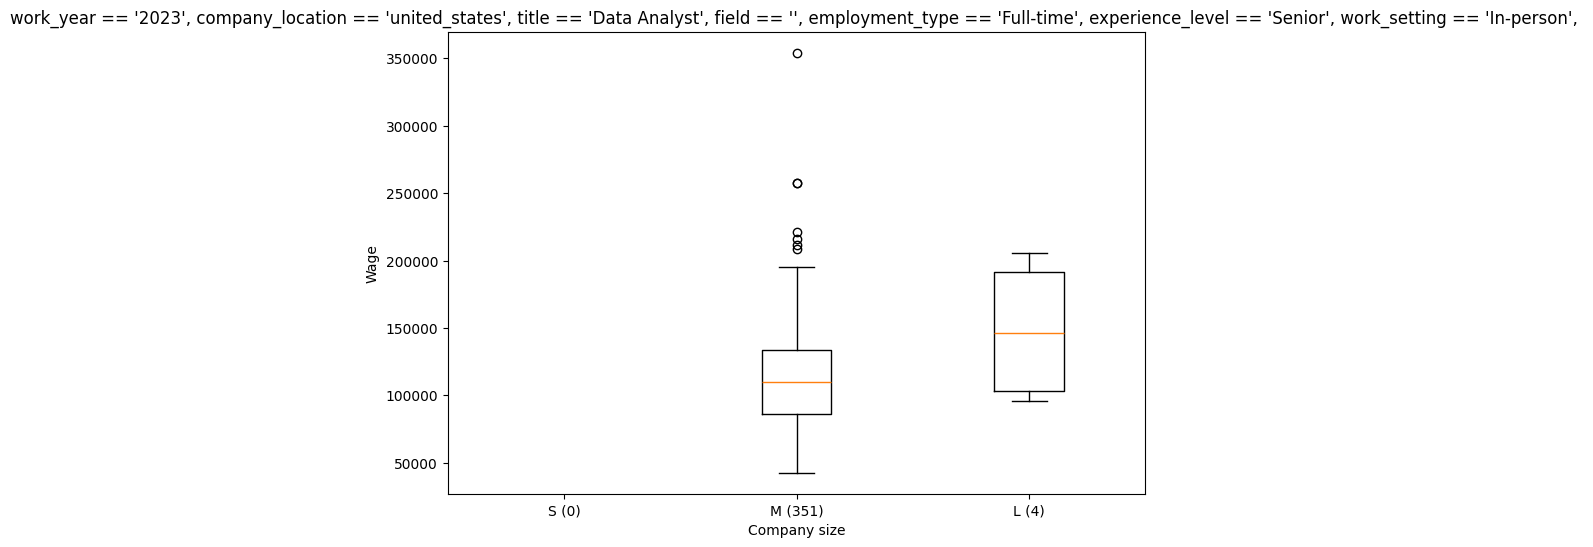

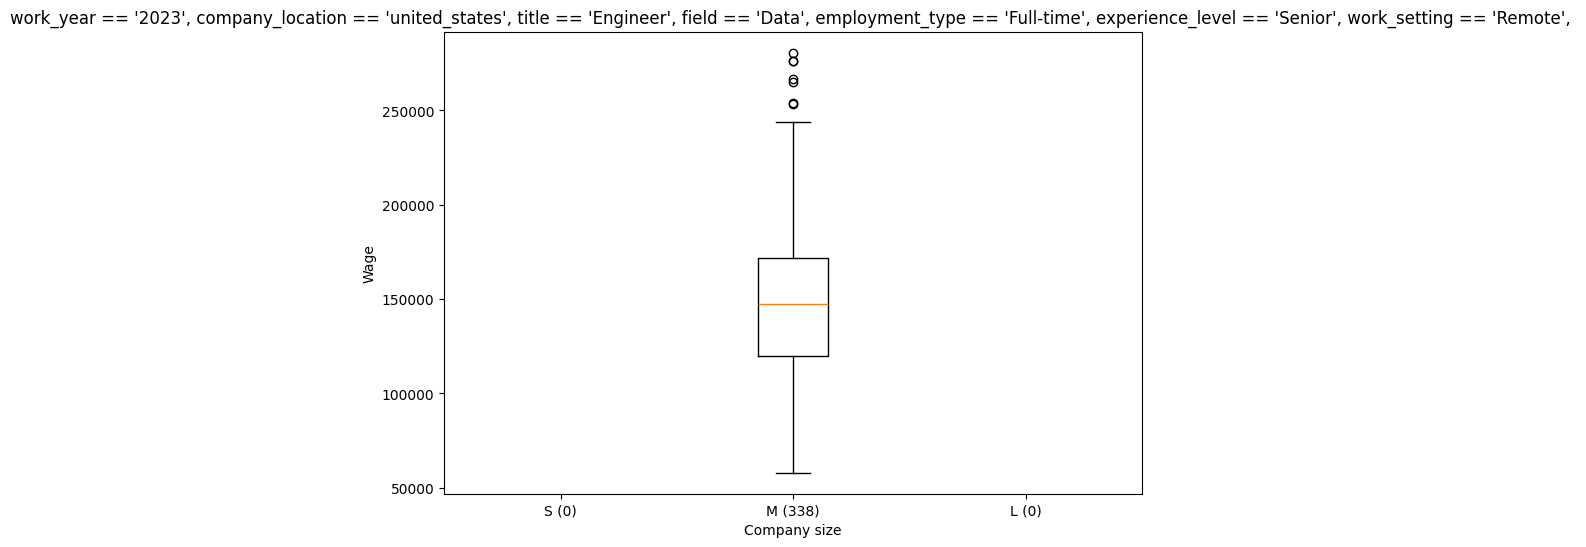

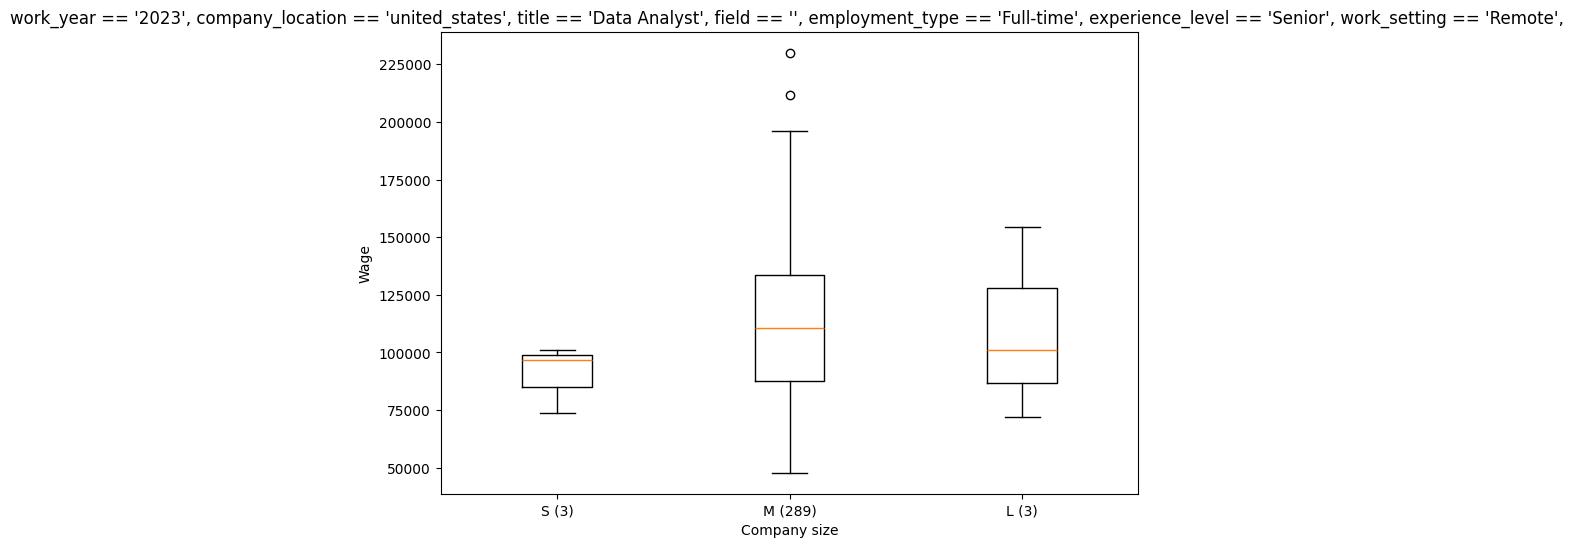

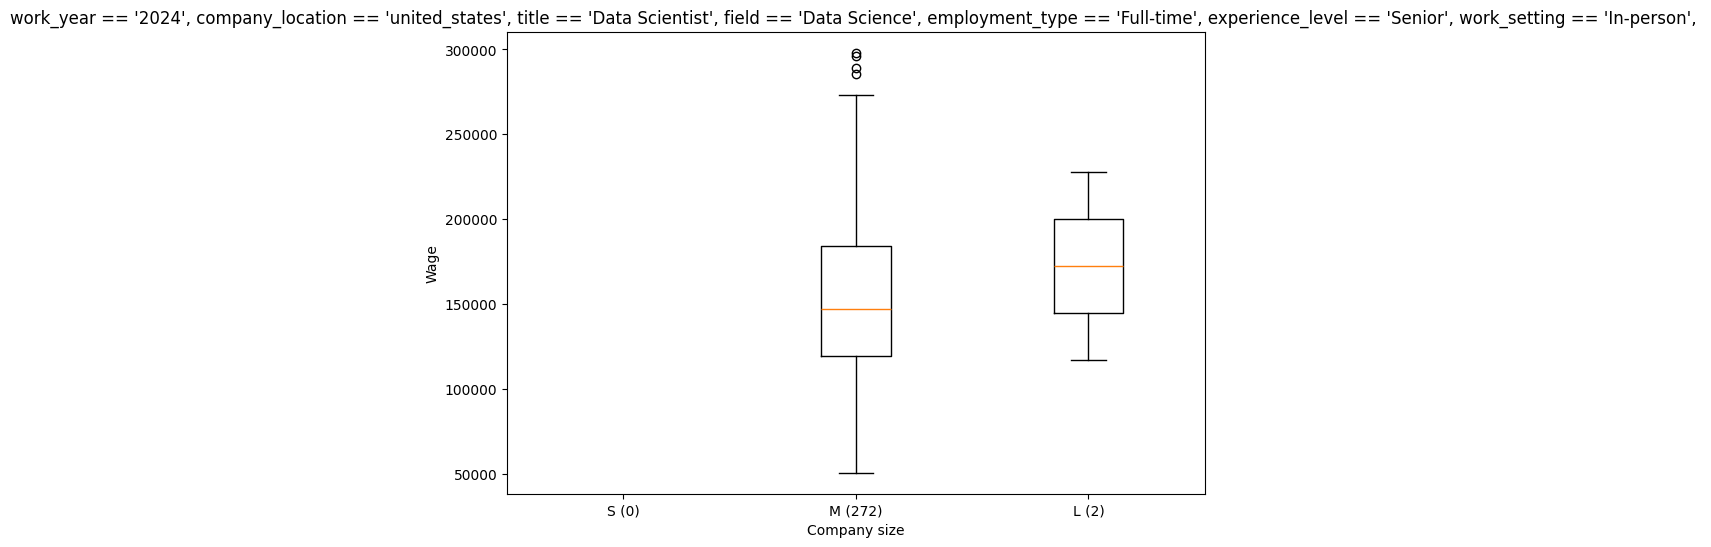

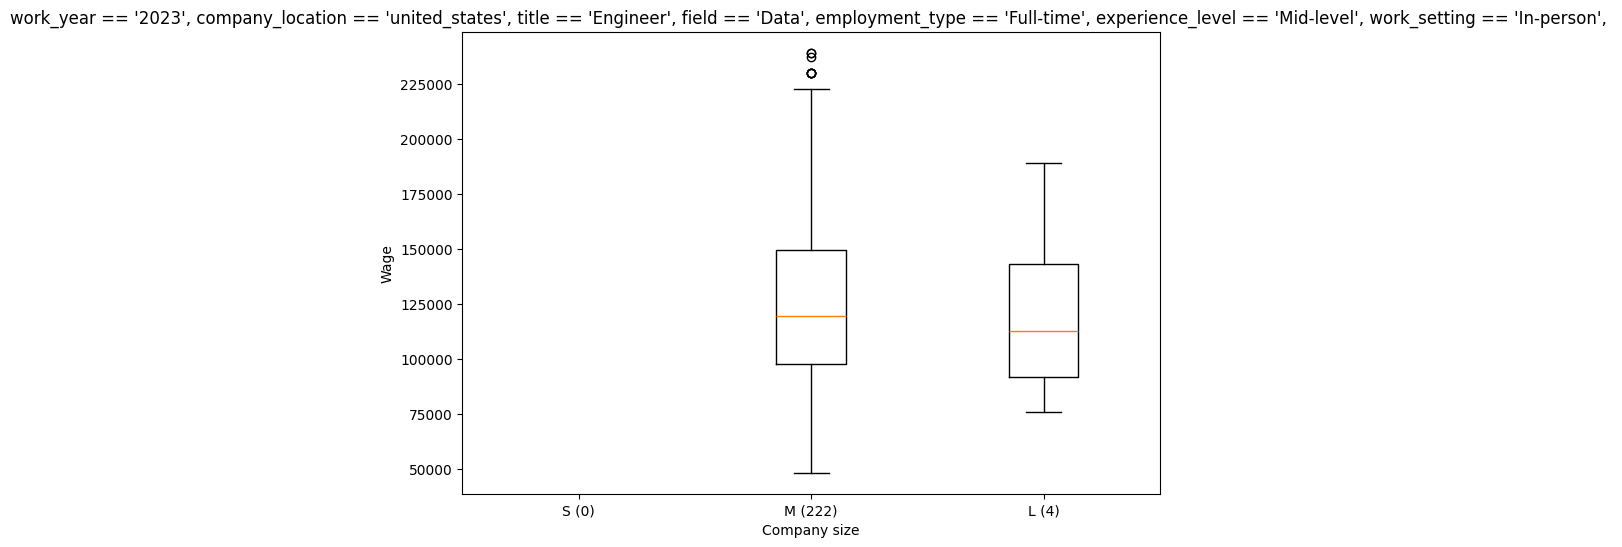

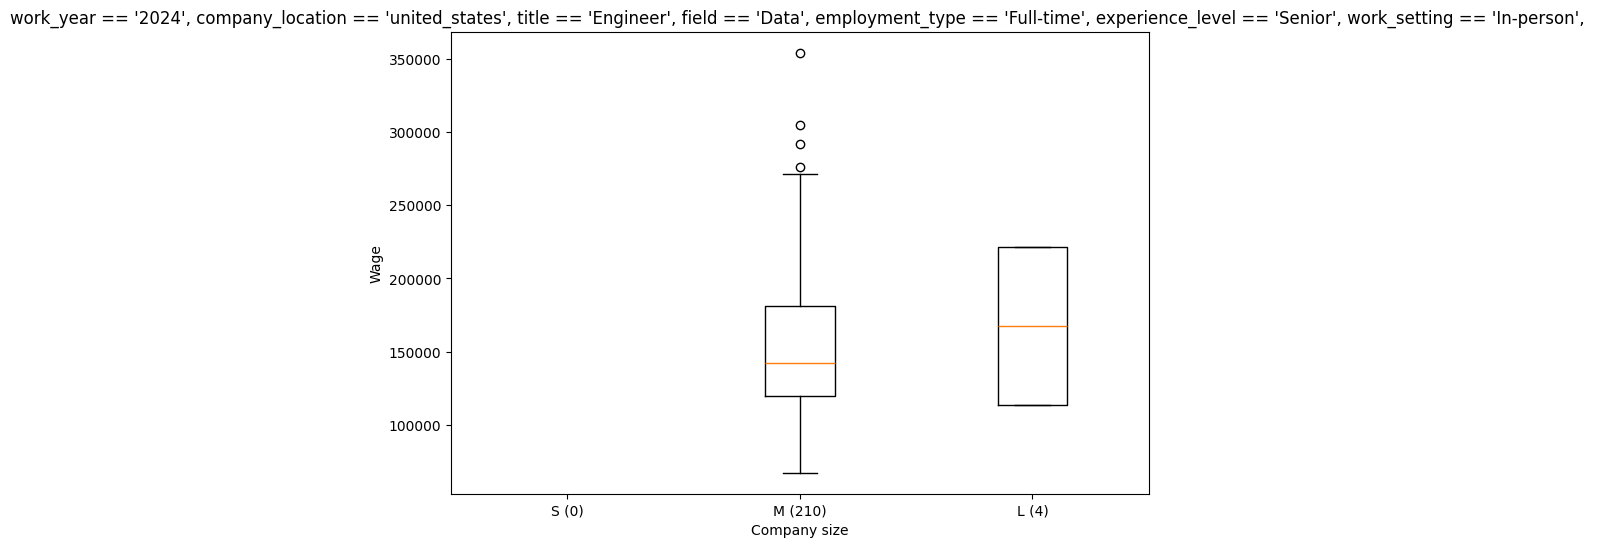

In [49]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()
    


so far I'm not convinced that the company size is an important factor - there seems to be a very irregular patter in here with sometimes the Large companies paying the best, other times, Small or Medium sized companies paying the best. We'll conclude this subquestion with a random search of the dataset to see if this statement holds truth outside the top ten! The constraint for this to be meaningful is that there should be at least a hundred listings (number pulled out of thin air)

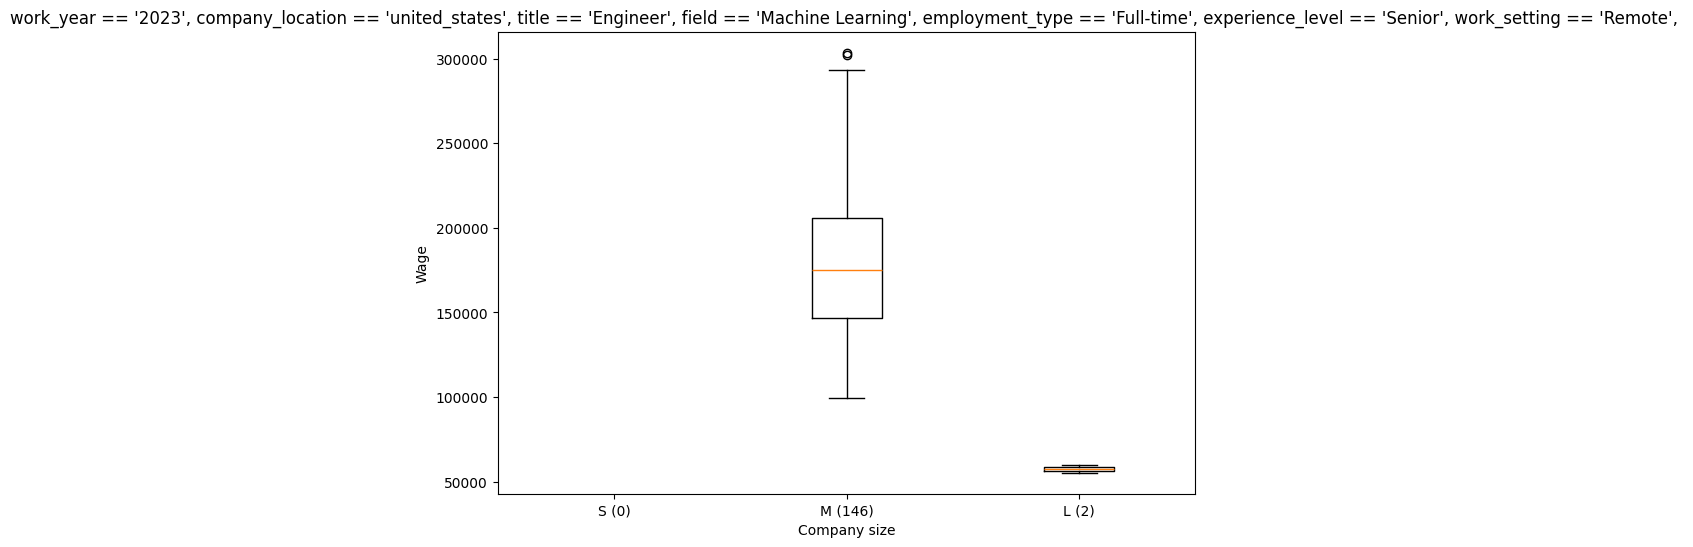

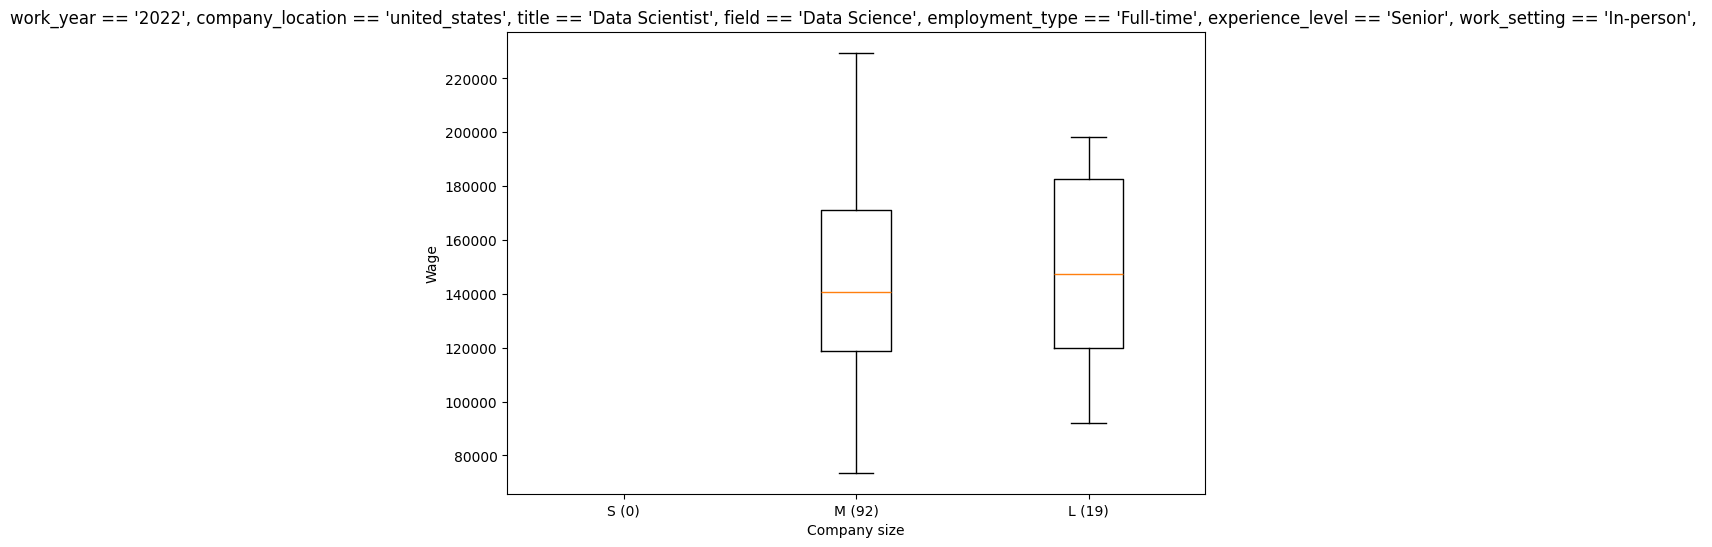

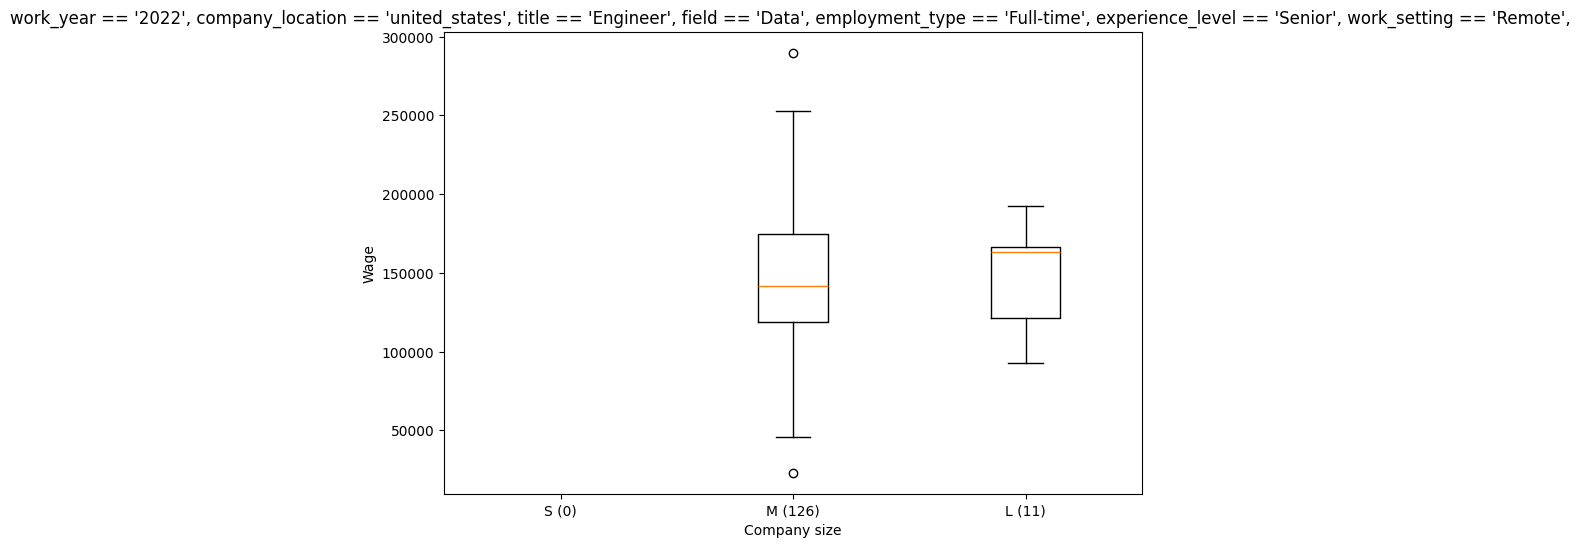

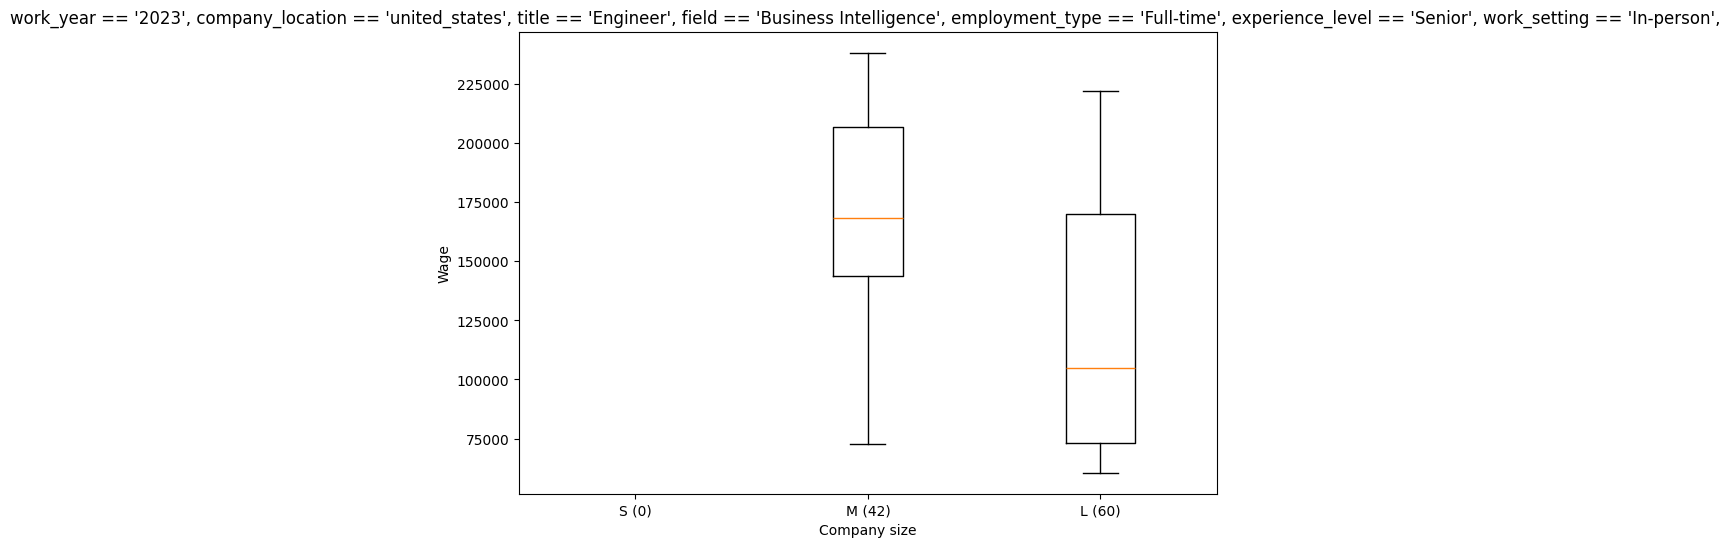

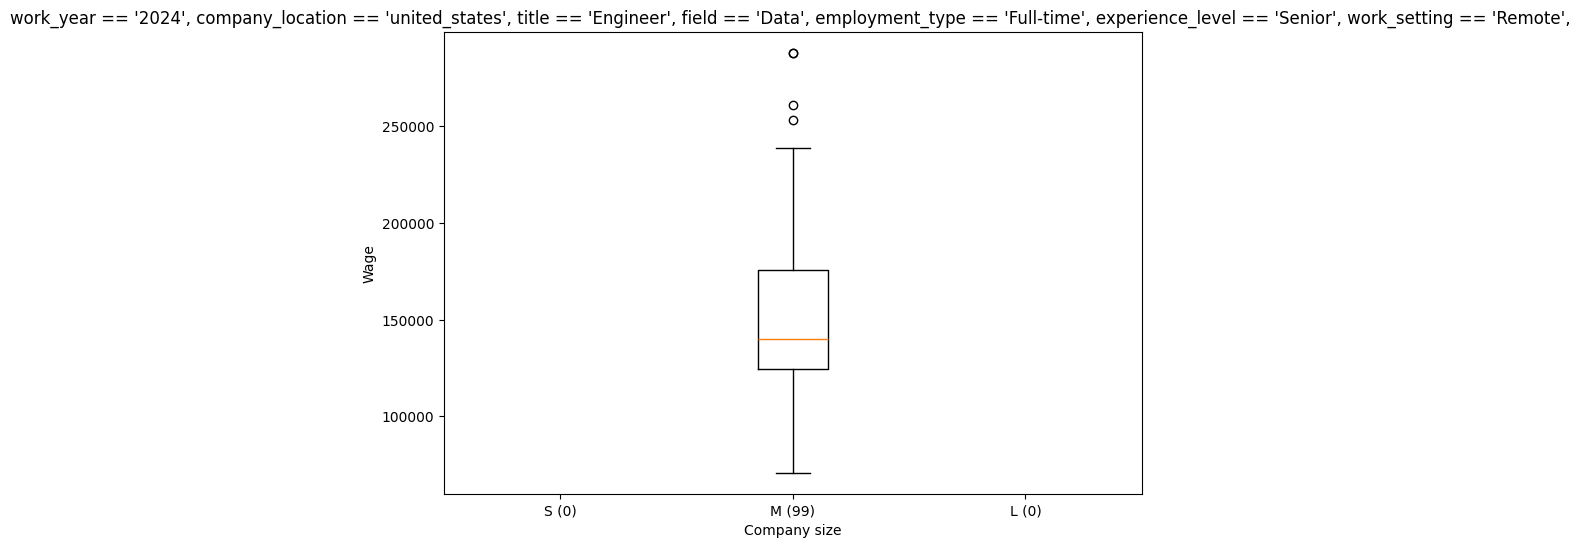

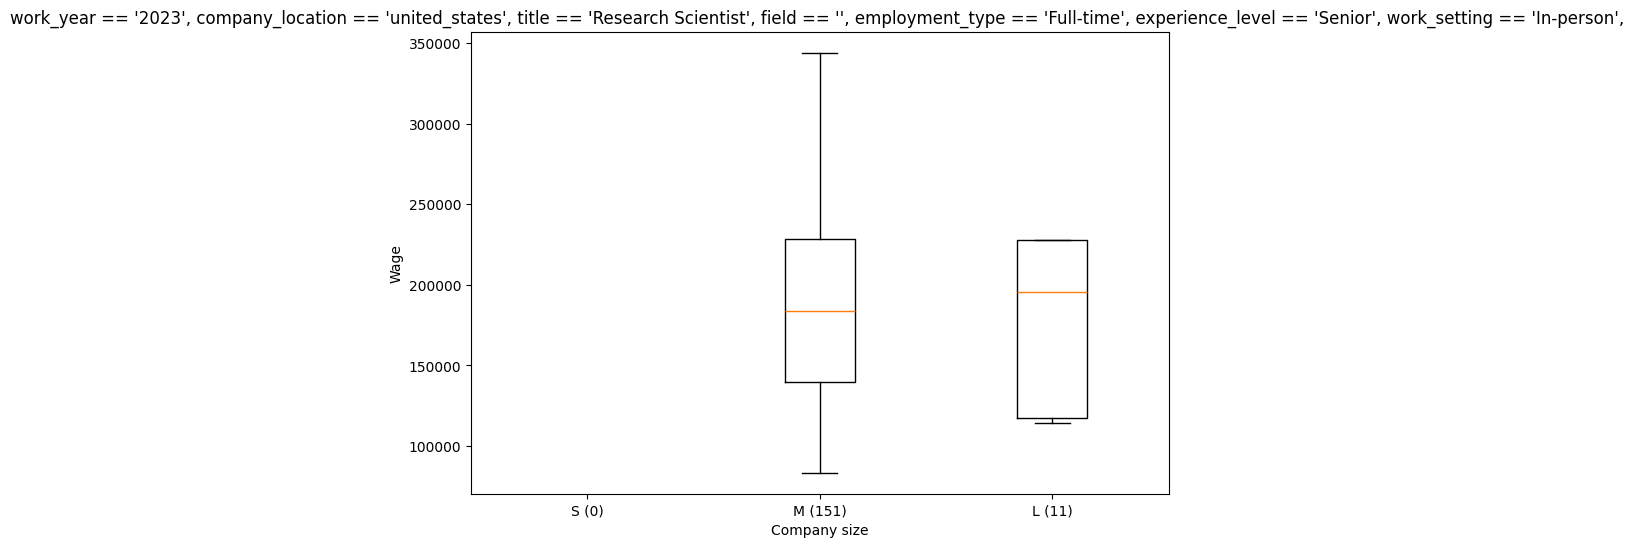

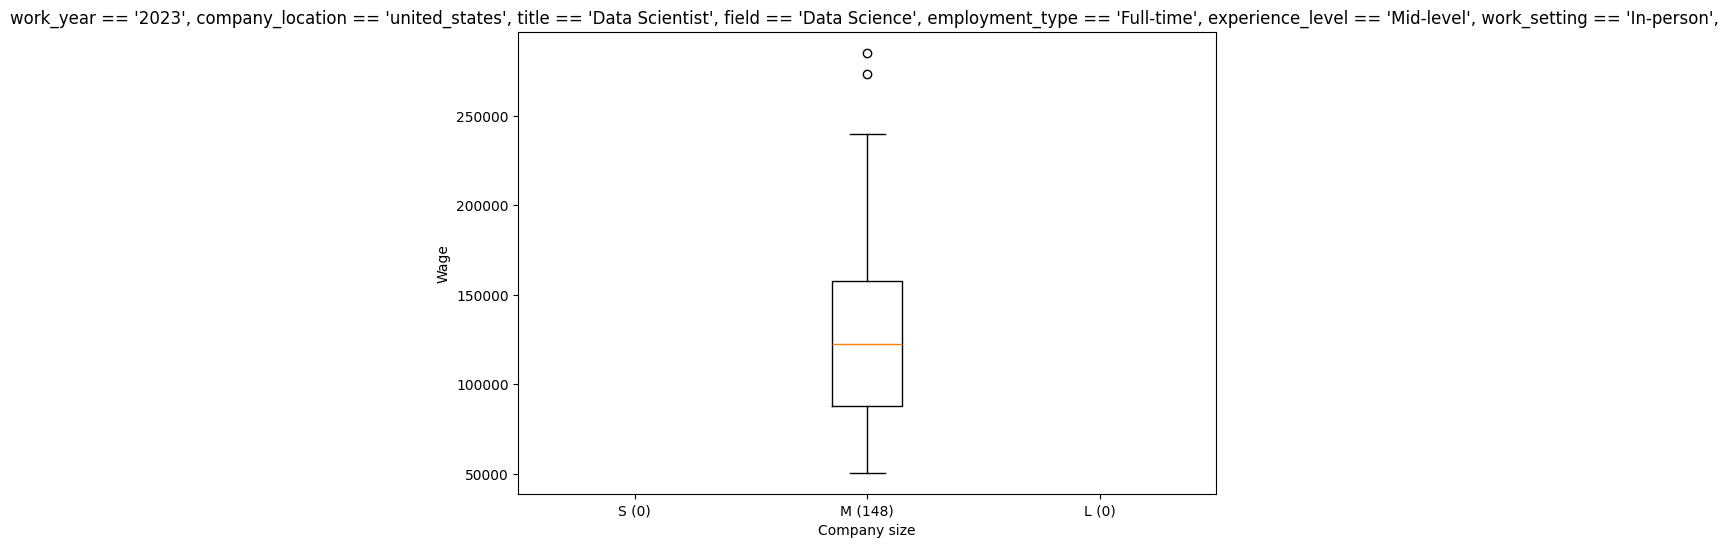

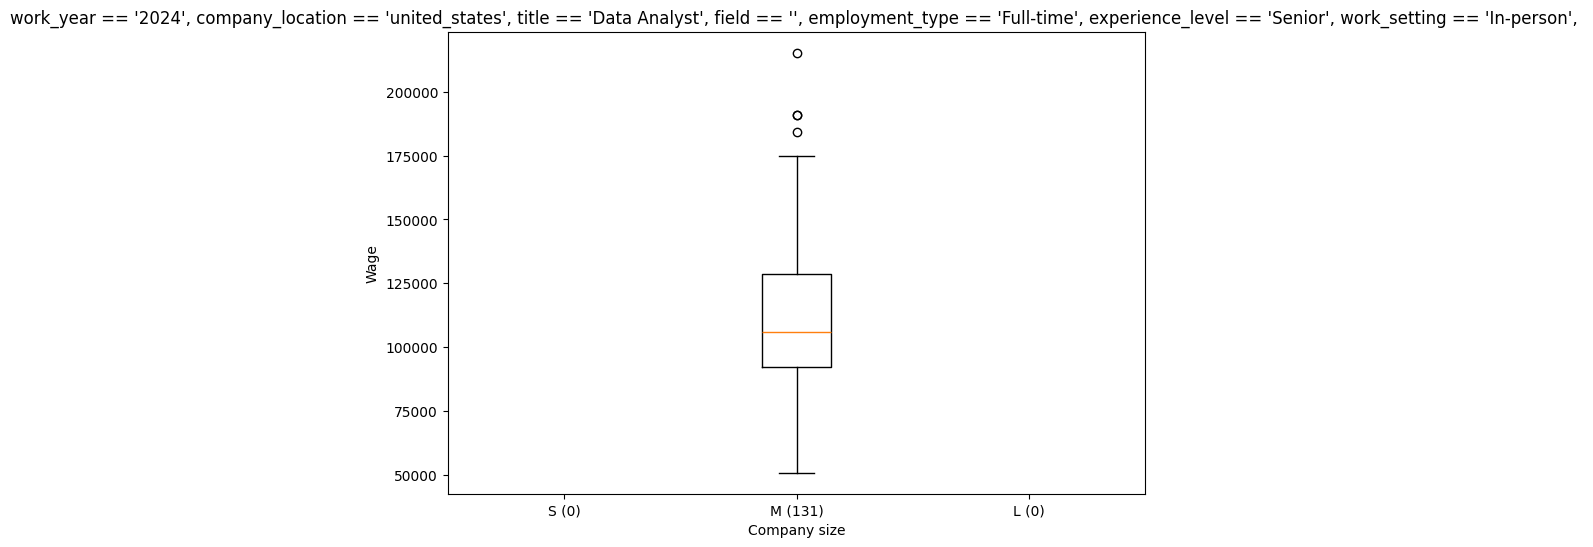

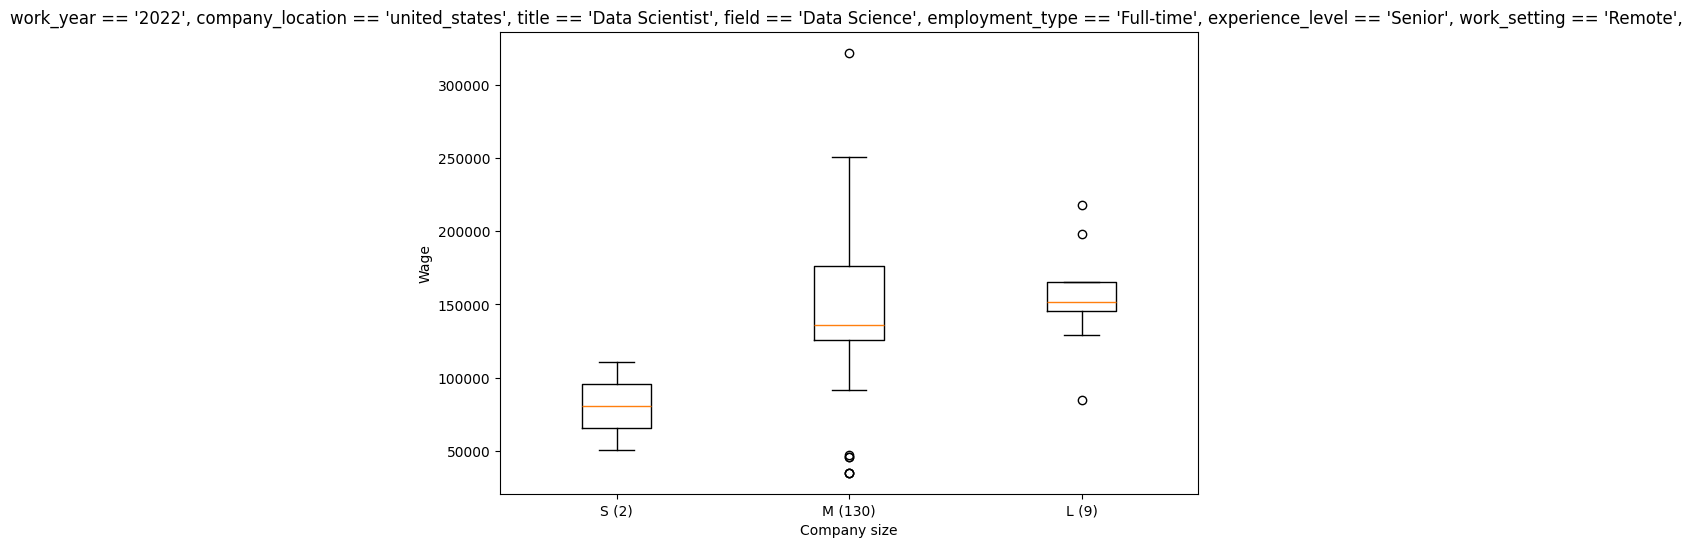

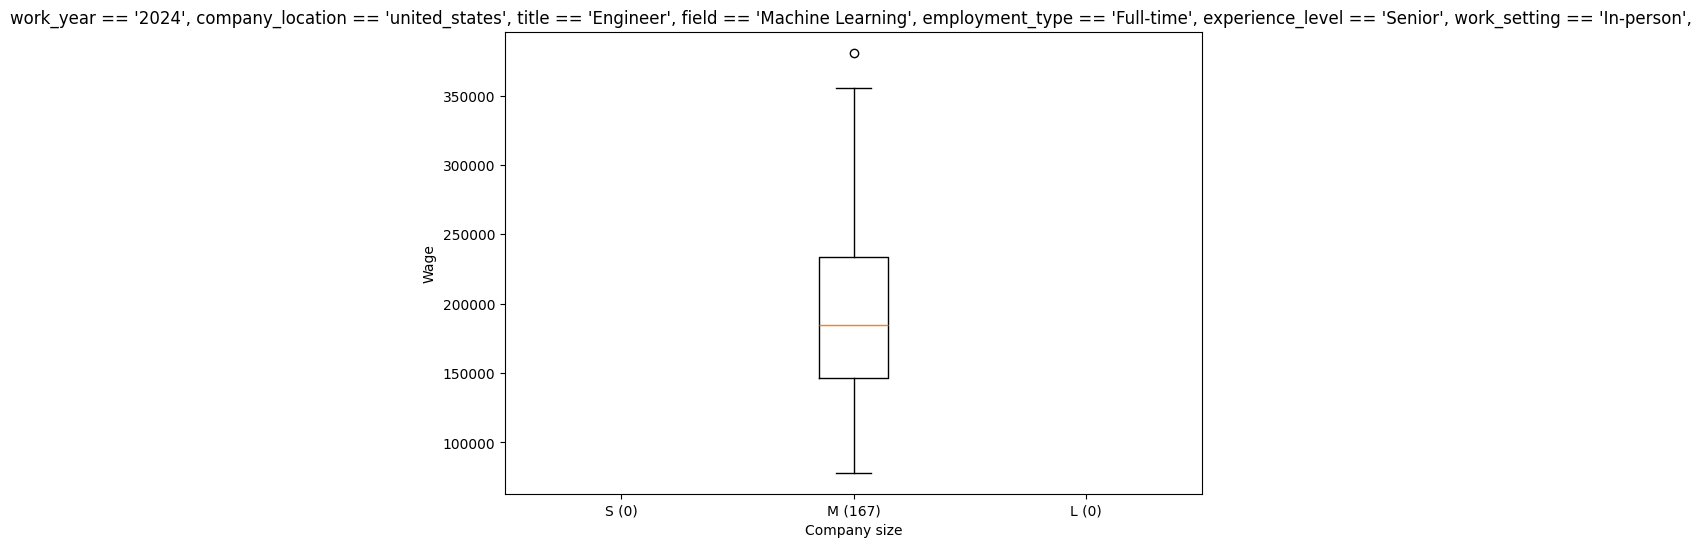

In [50]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

Outside the top ten of clustered listings we see a similar truth - company size is not as strong of a factor as initially thought. Plotting the boxplots shows a high irregularity between specific function/field... factors and company size. There's no consistent order where the for example small companies always pay better than large companies. As such we might consider ommitting this feature from a predictive model.

## 6.6 Experience level vs Wage
This is in essence a repeat question of 6.5 with different query parameters. Helper queries are written in such a way that the code can be reused by passing an extra parameter. 

In [51]:
key_for_question = 'experience_level'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type company_size work_setting  count
763       2023    united_states        Engineer              Data       Full-time            M    In-person   1042
729       2023    united_states  Data Scientist      Data Science       Full-time            M    In-person    864
787       2023    united_states        Engineer  Machine Learning       Full-time            M    In-person    641
713       2023    united_states    Data Analyst                         Full-time            M    In-person    590
730       2023    united_states  Data Scientist      Data Science       Full-time            M       Remote    485

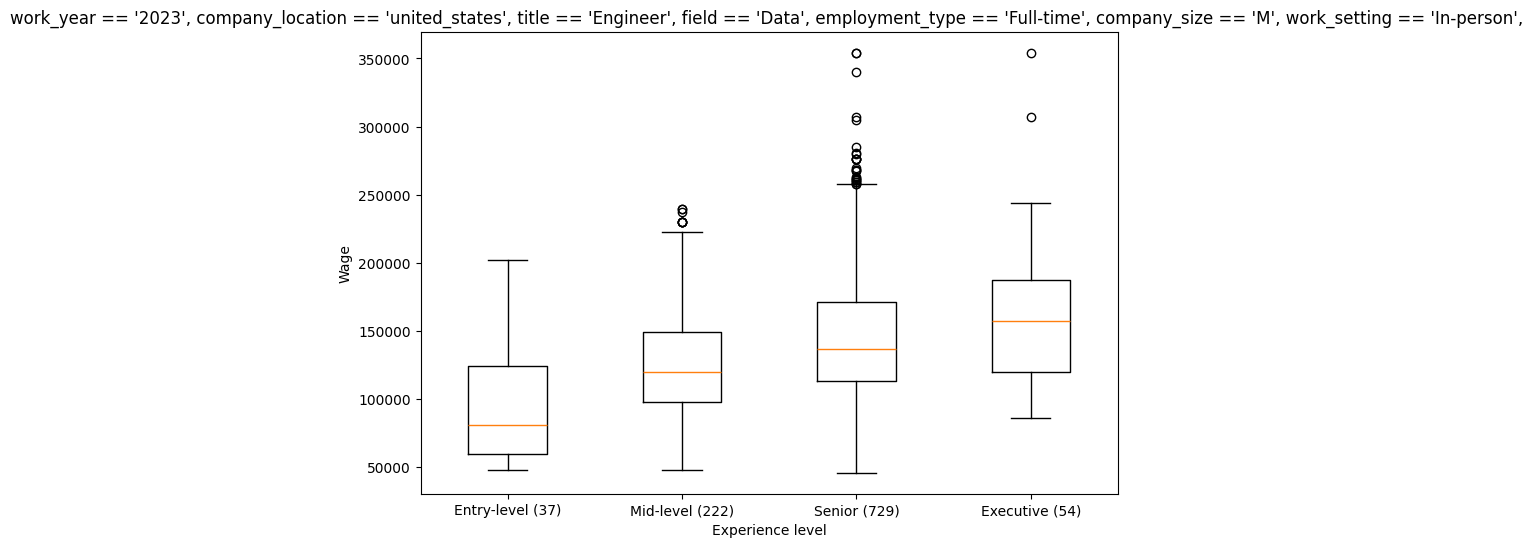

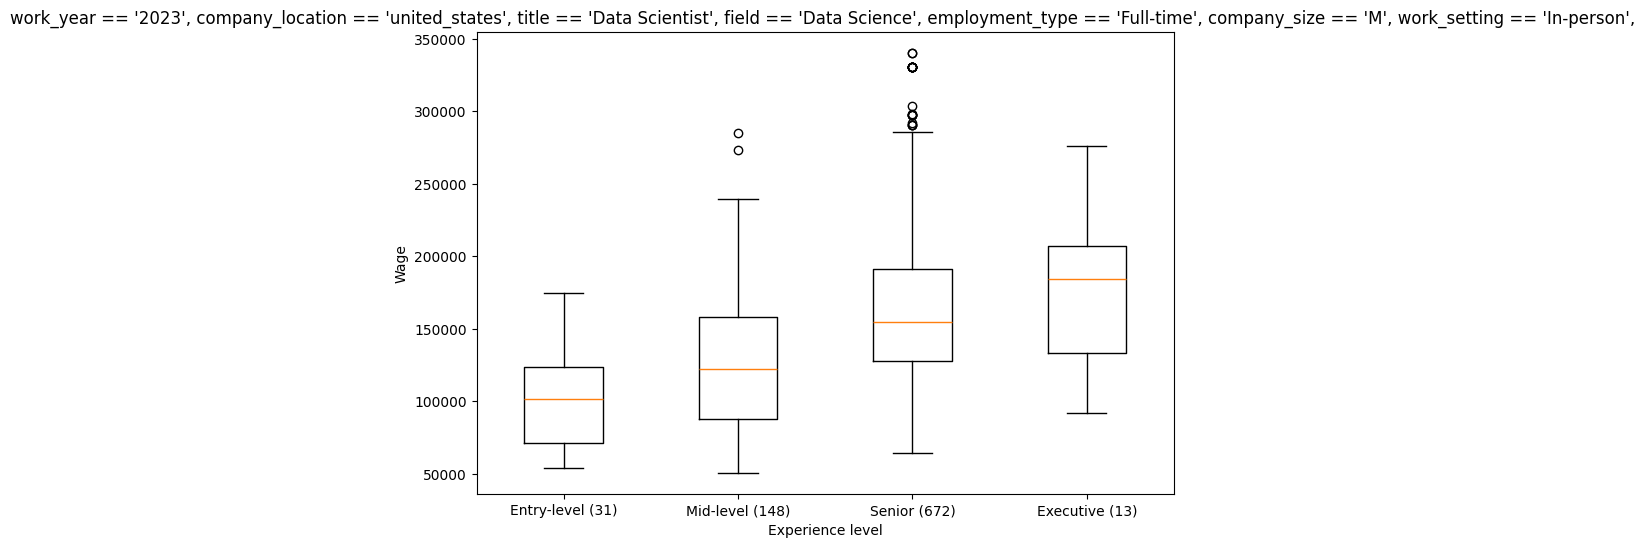

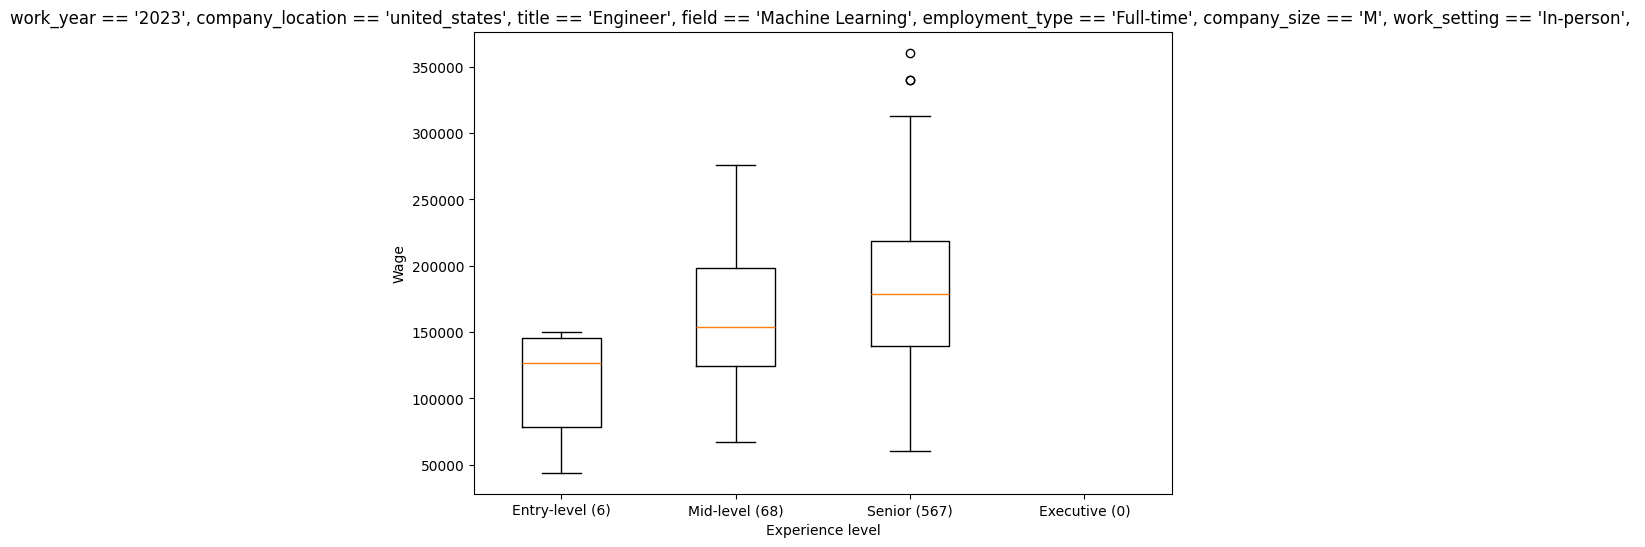

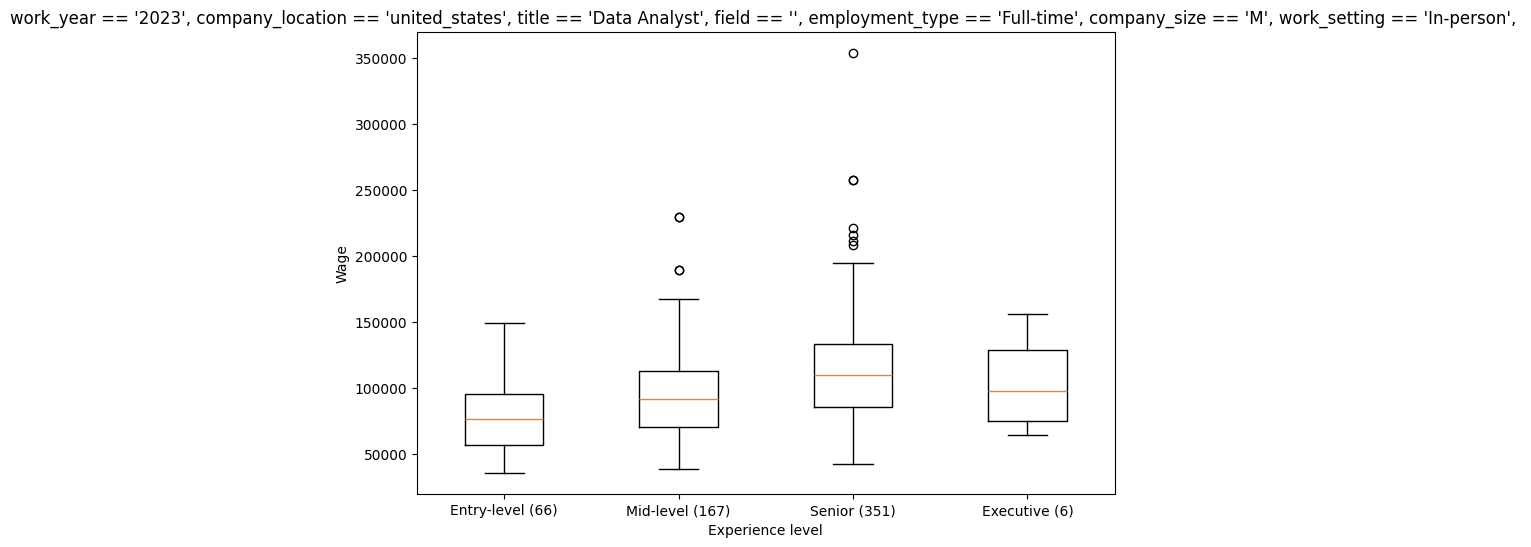

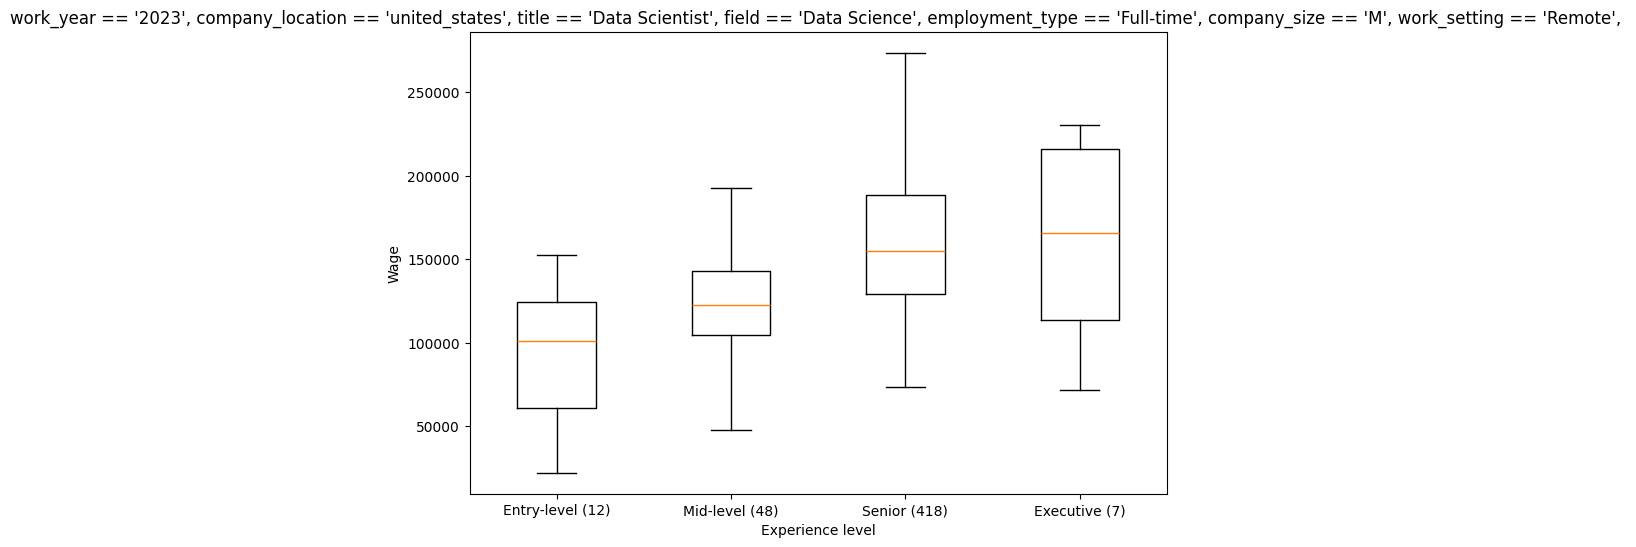

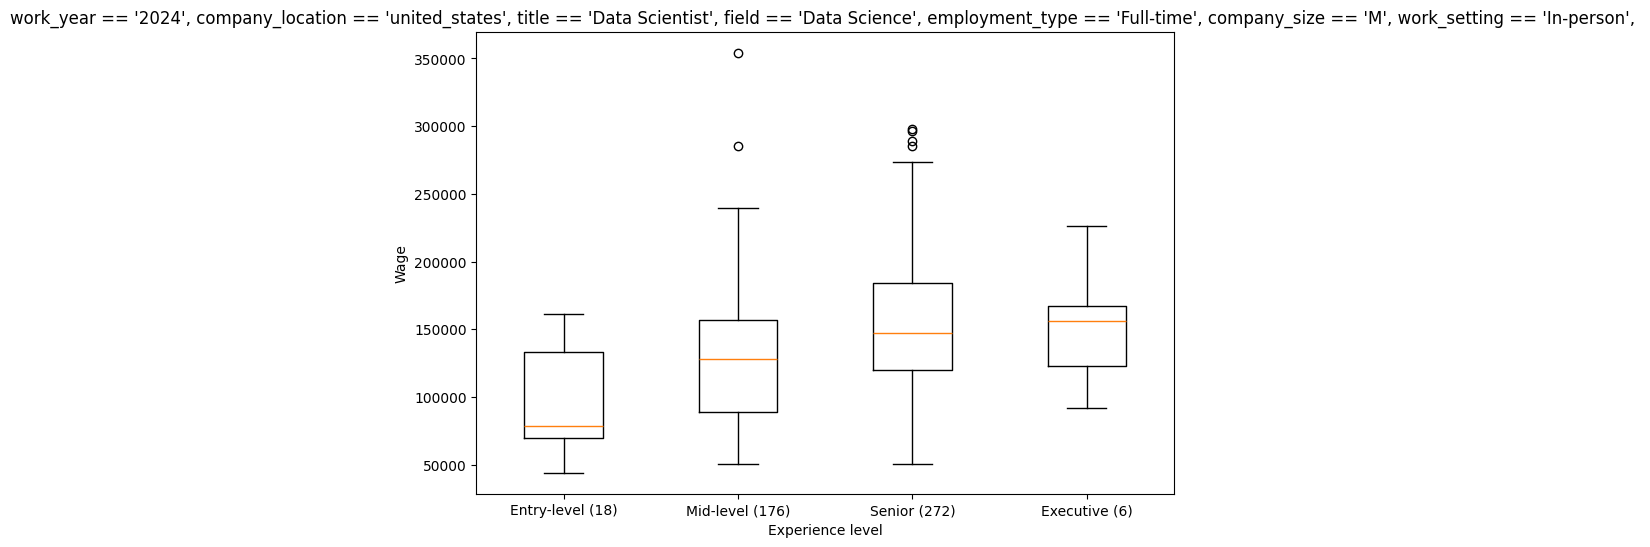

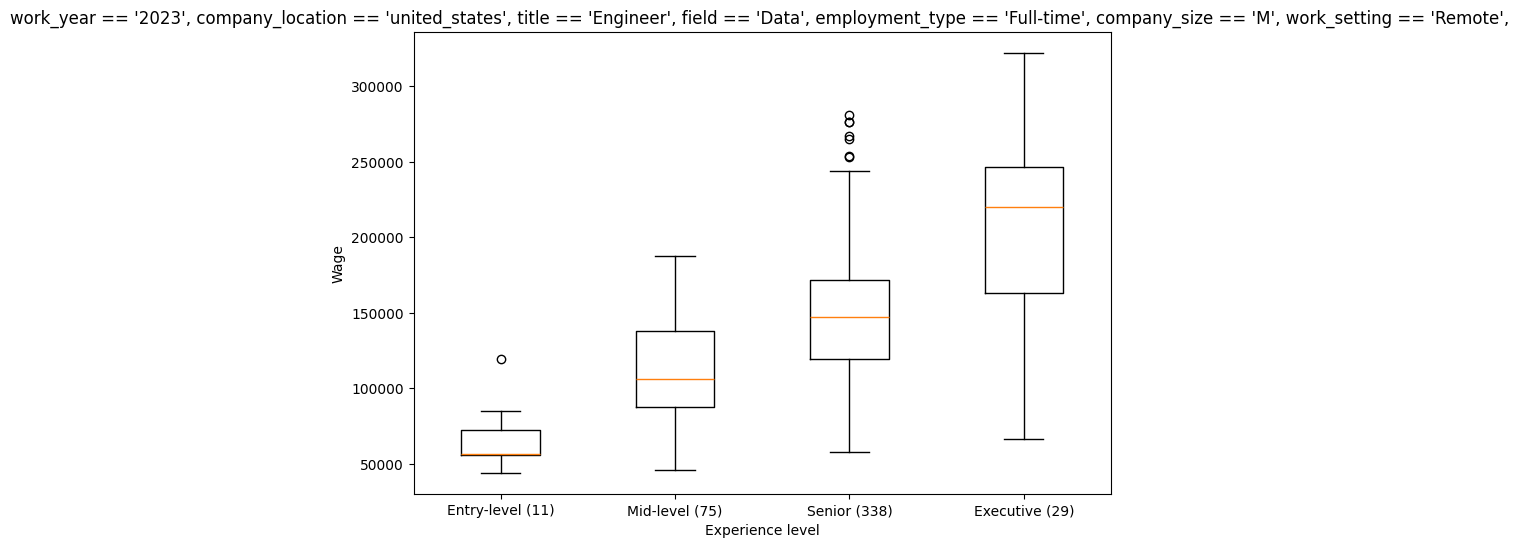

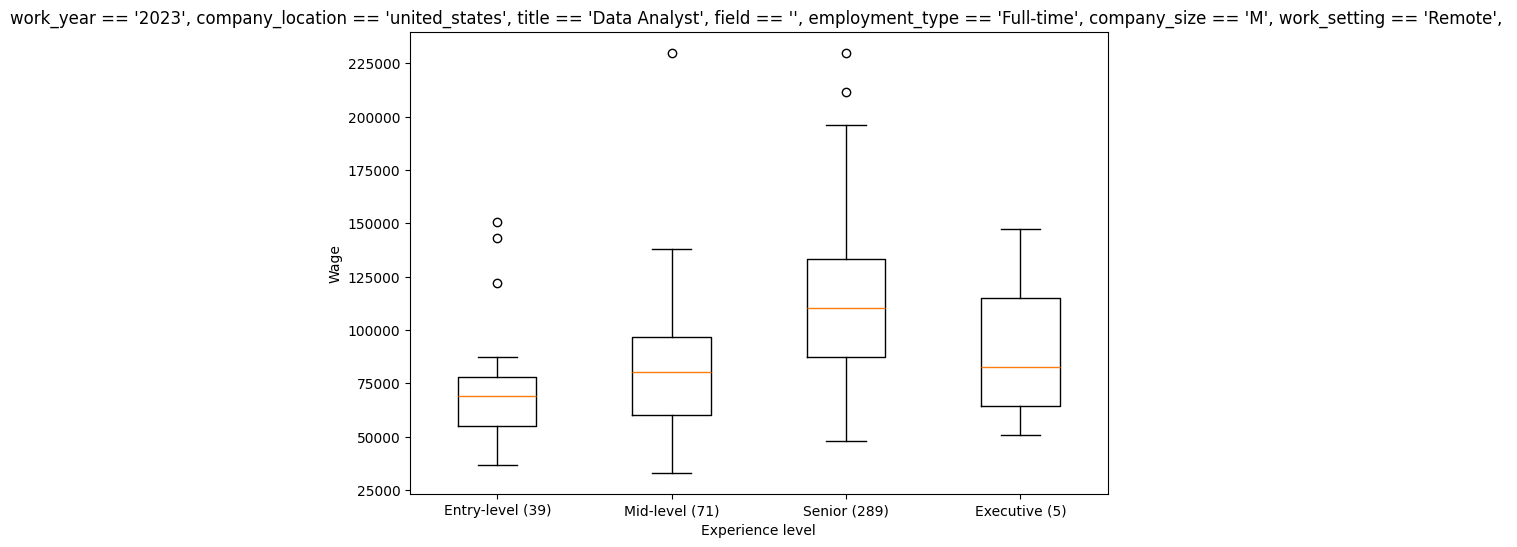

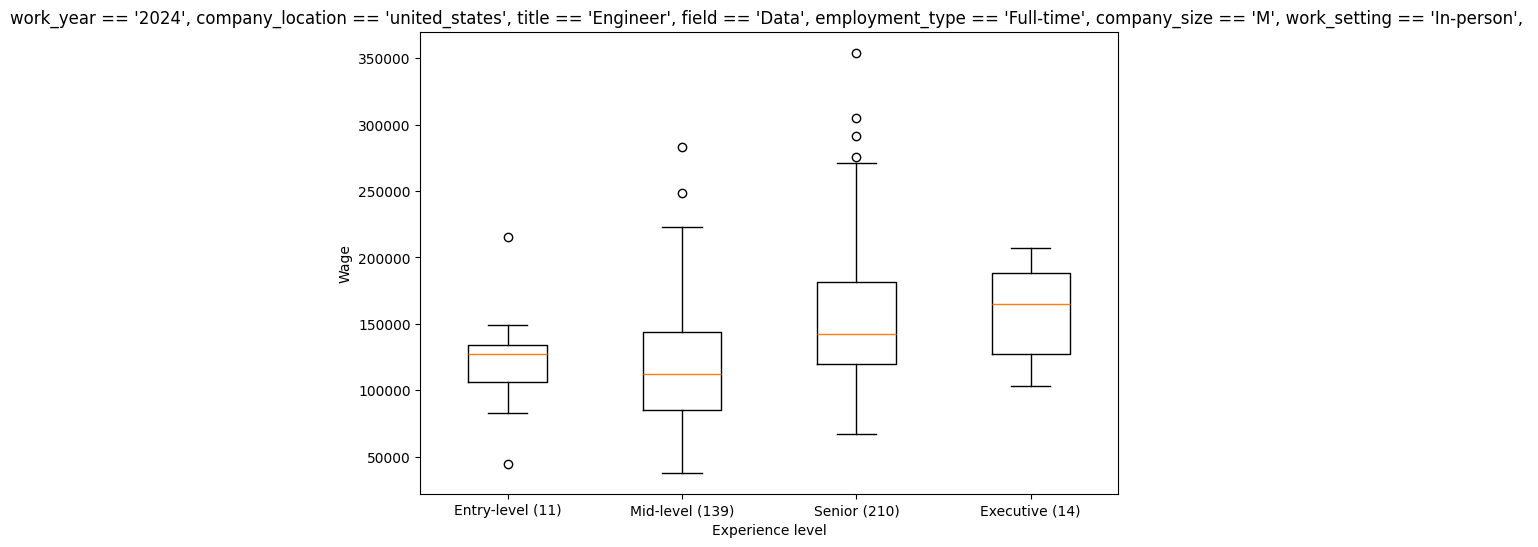

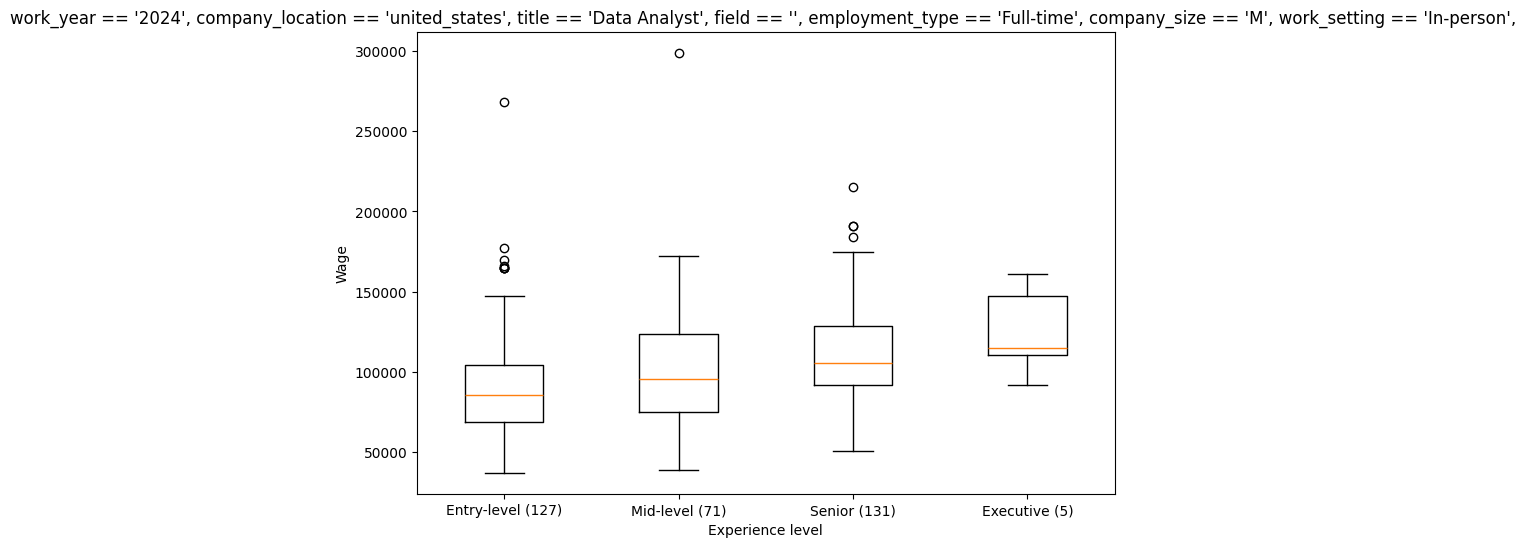

In [52]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()
    


There is a clear upward trend for higher wages as experience level increases; it's not always there, but overall we can say that more experience leads to higher wages. Let's see if this trend is also visible for randomly selected rows. 

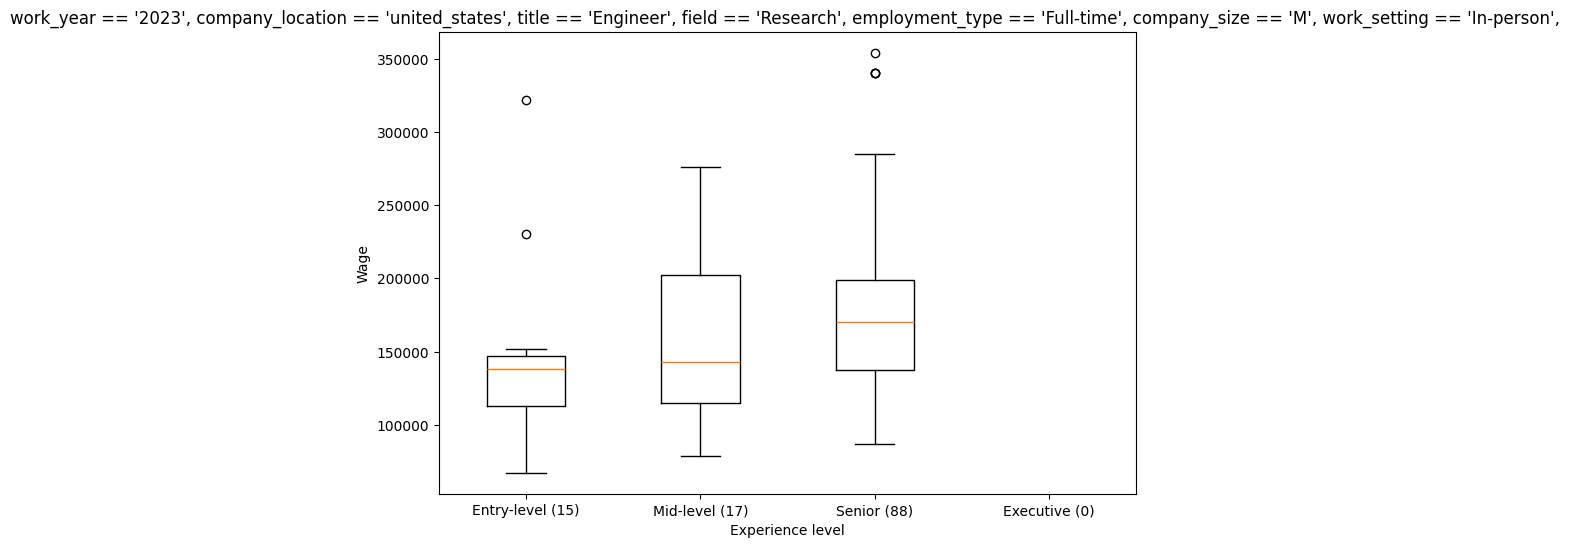

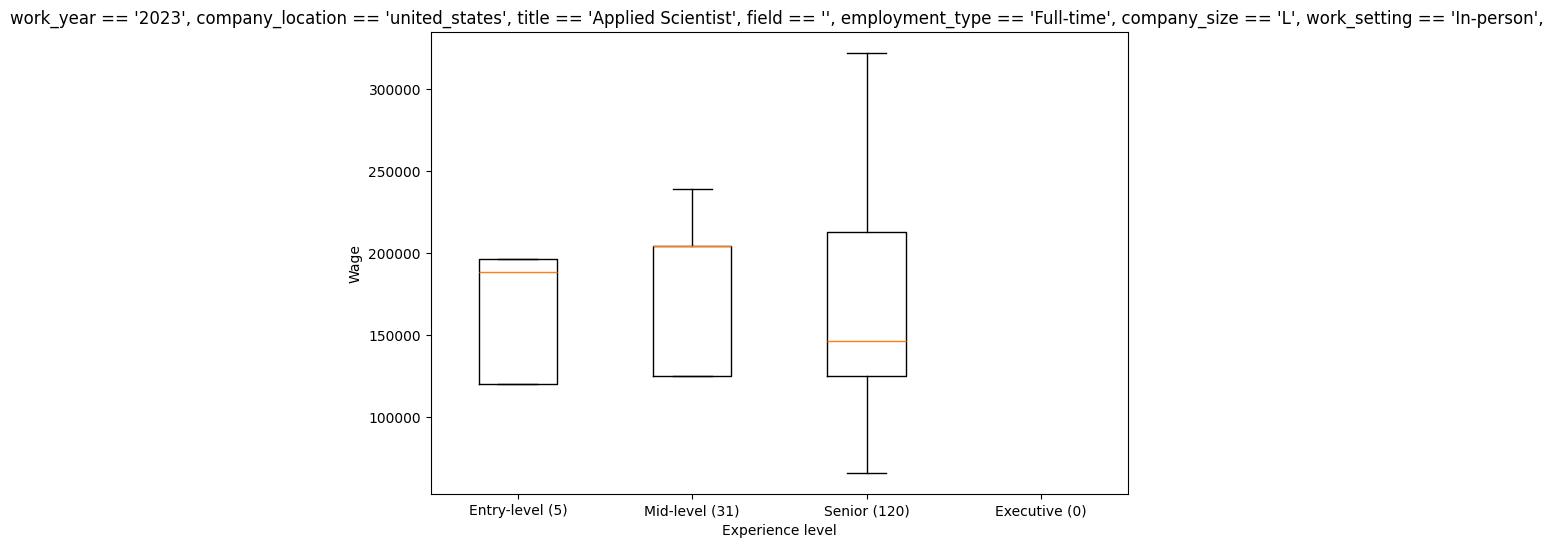

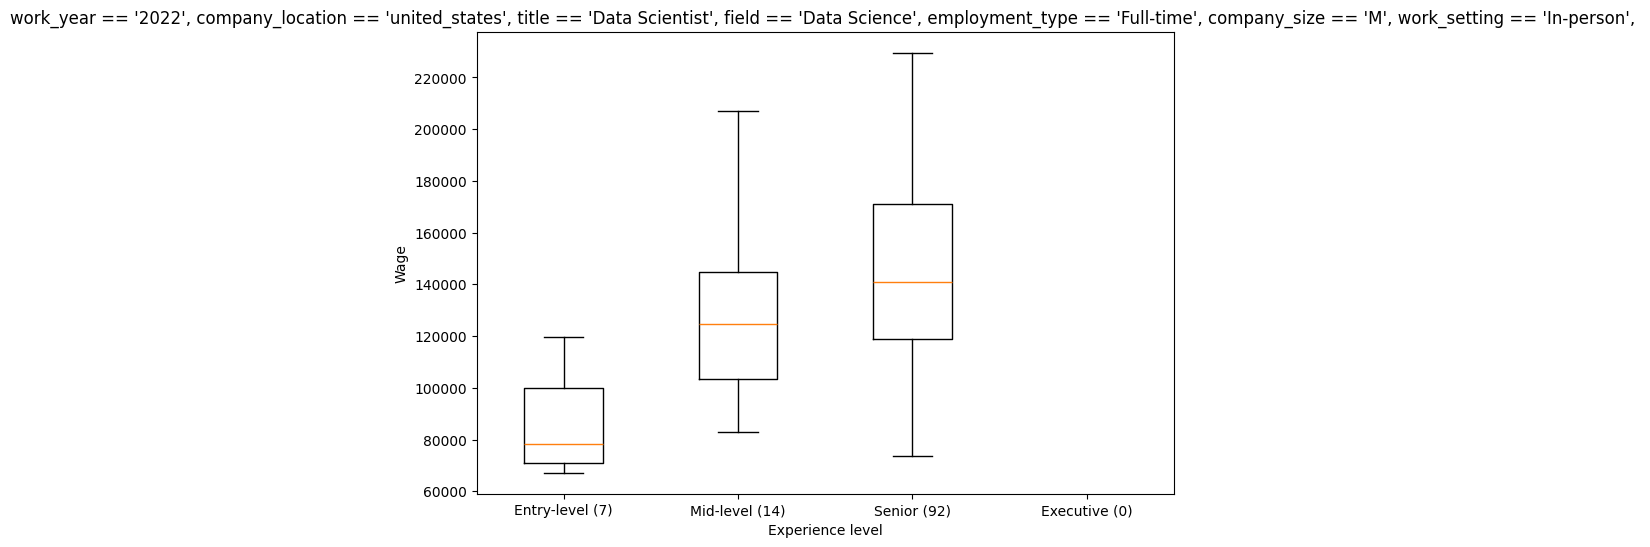

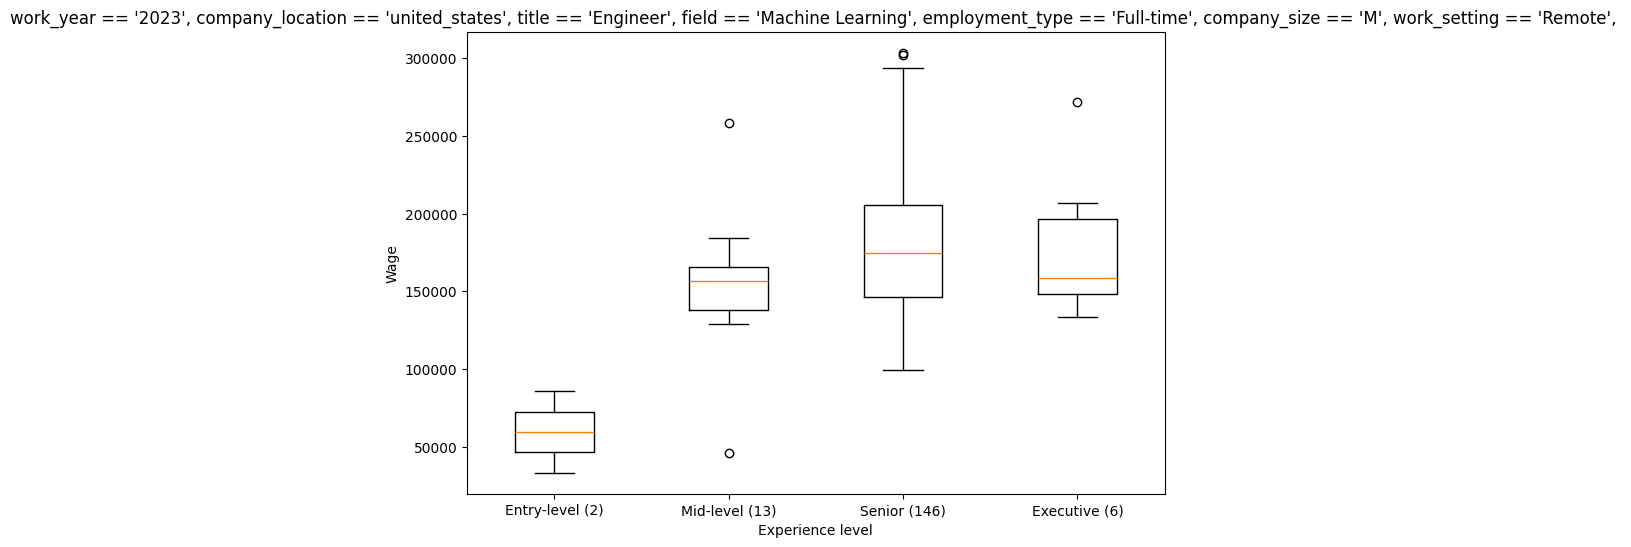

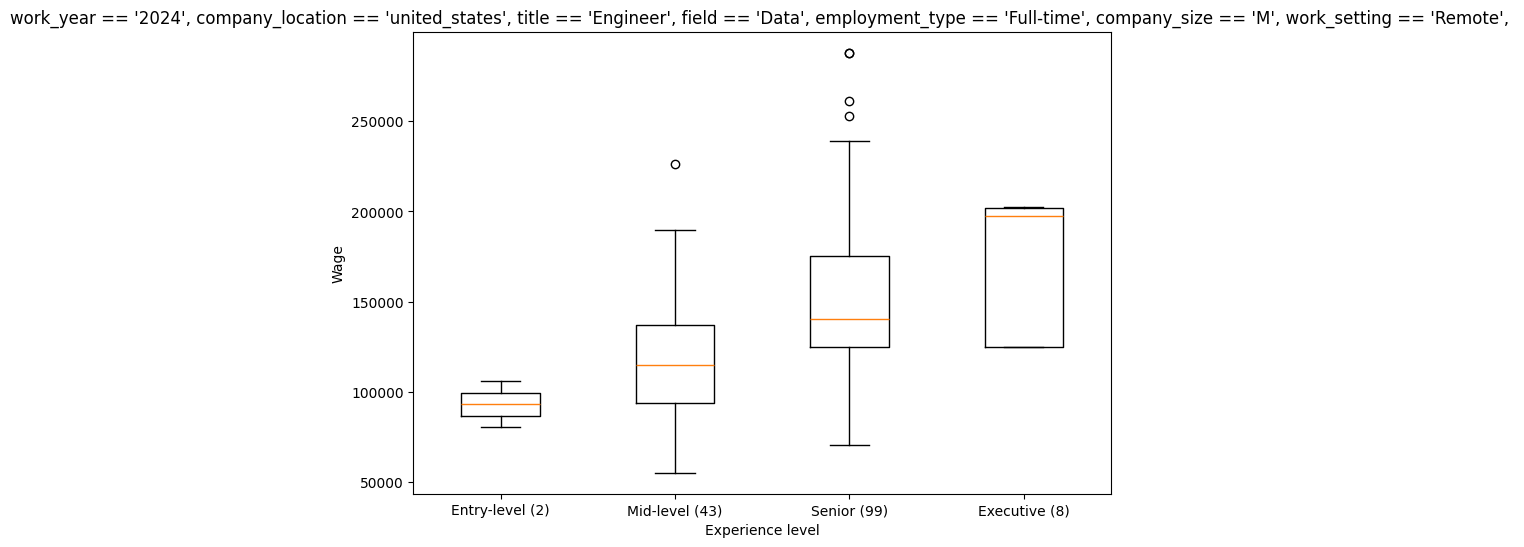

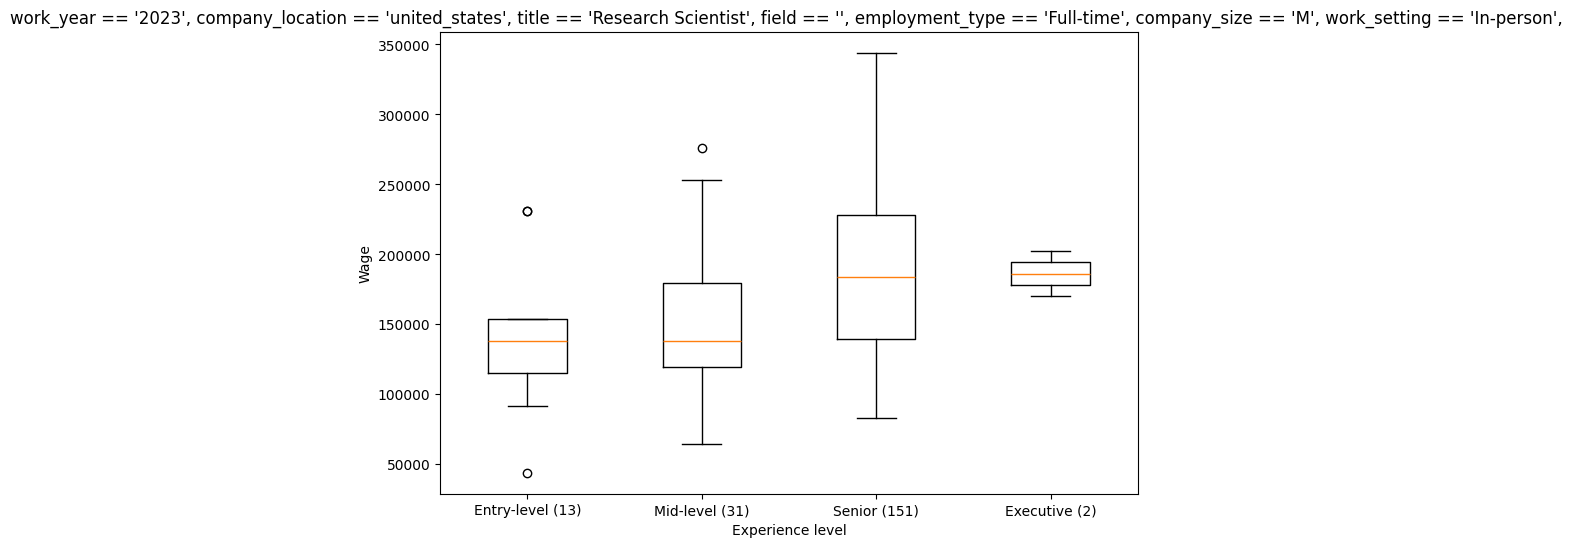

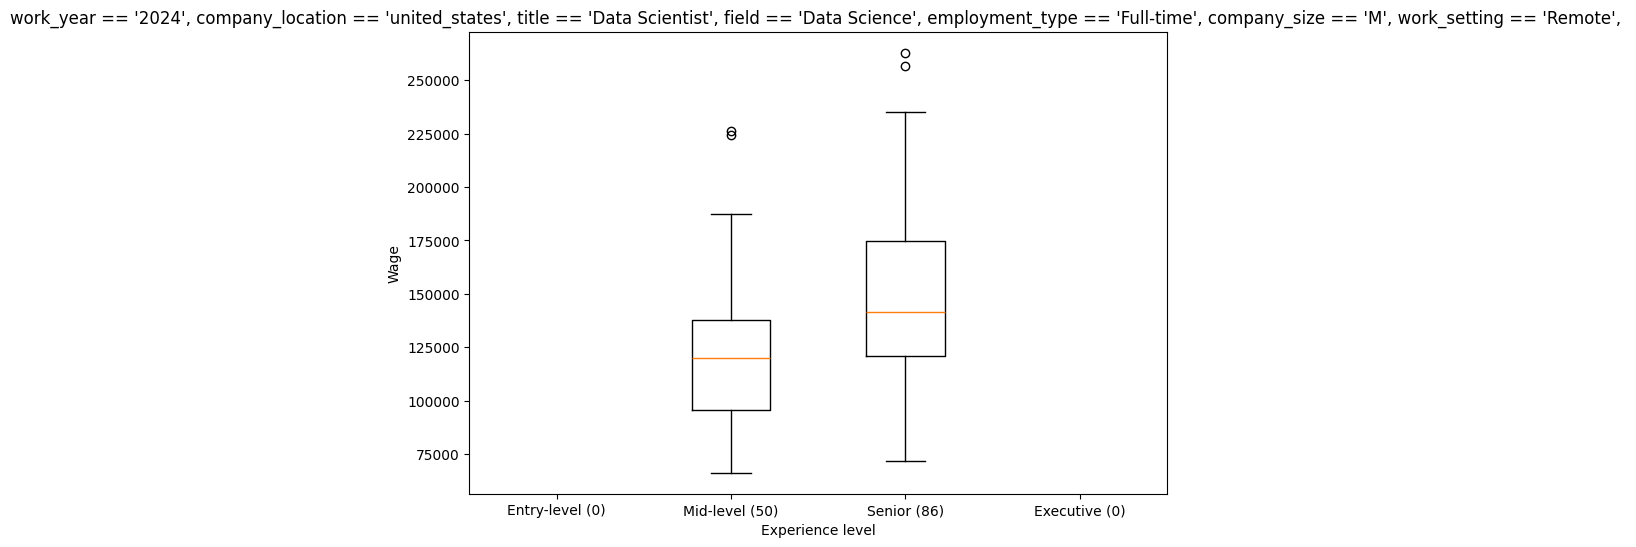

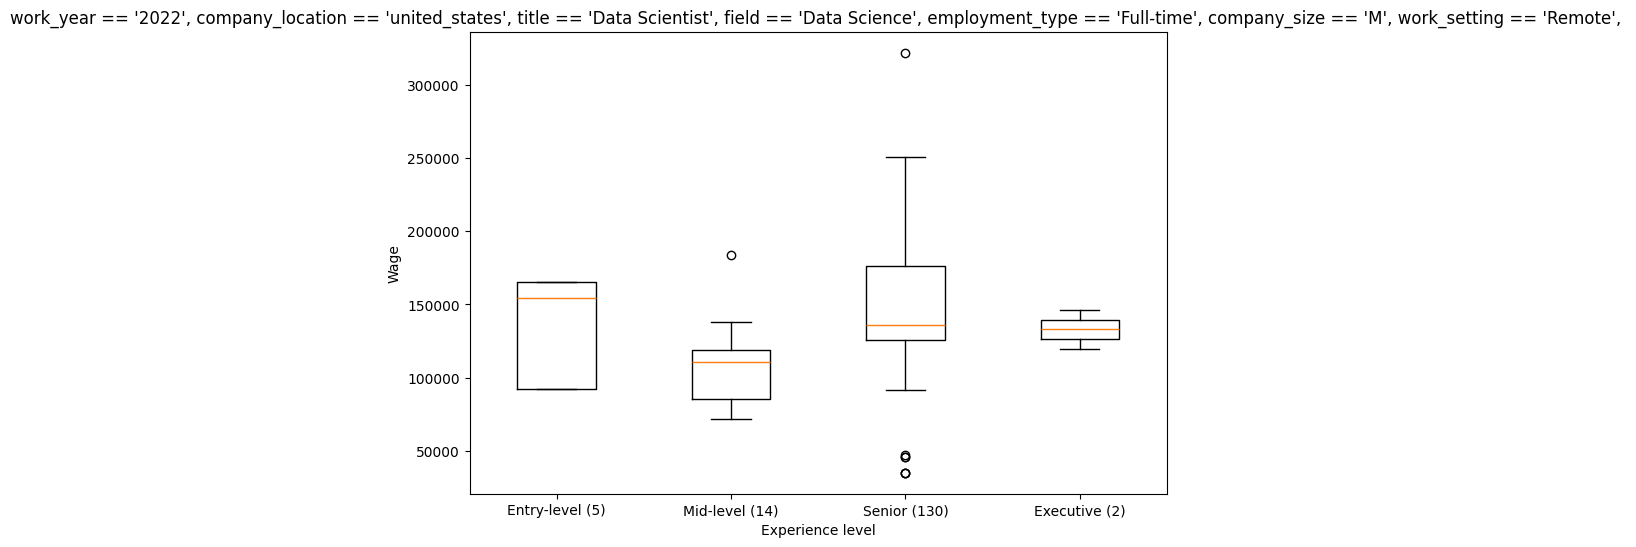

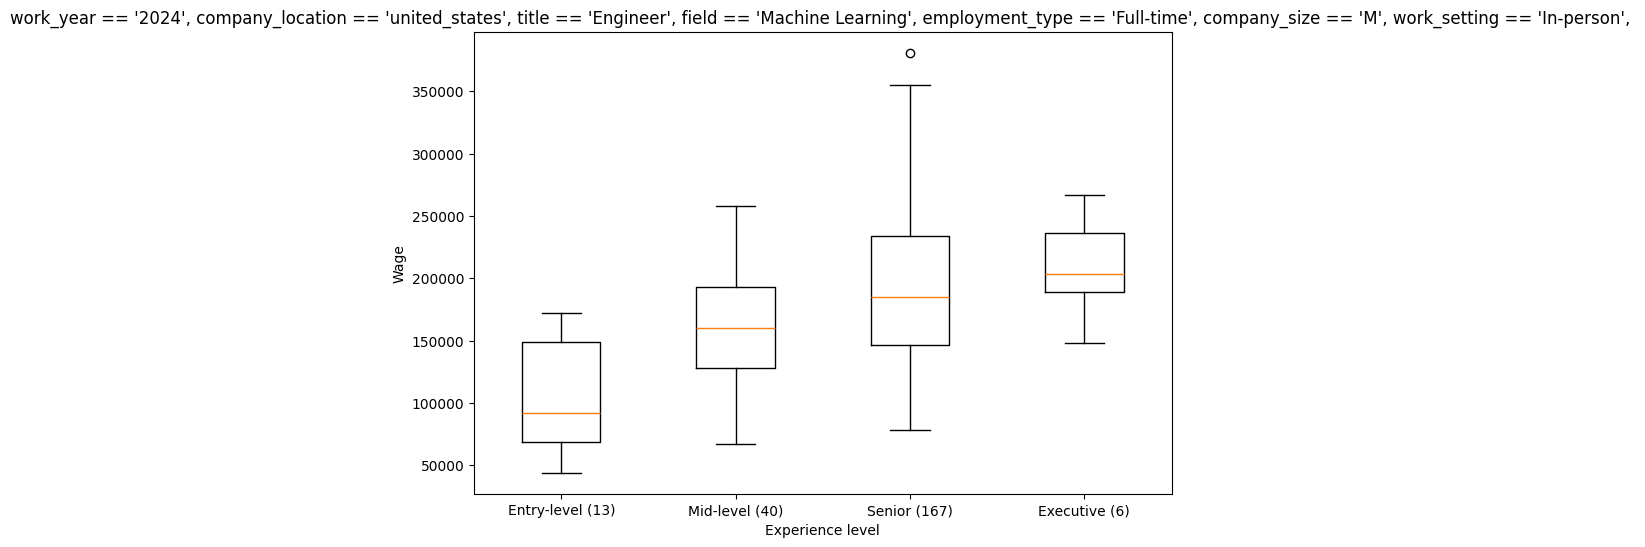

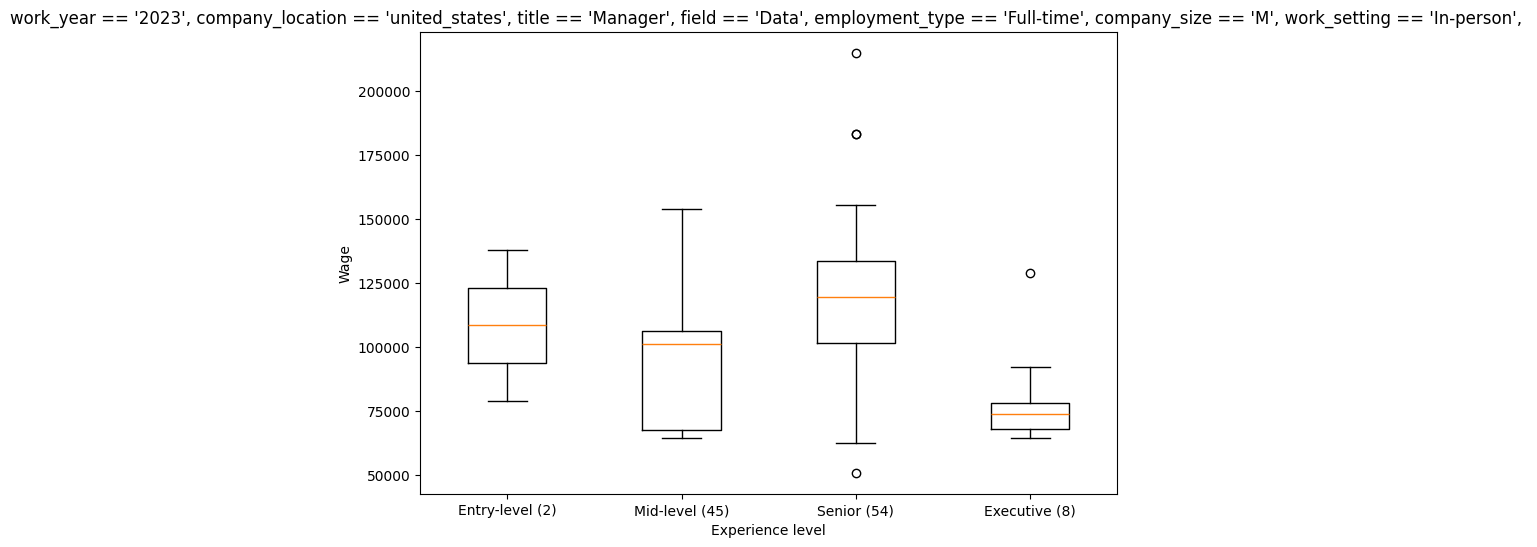

In [53]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

For randomly selected rows of the `exp_clusters` dataframe we see that the trend holds up - again with a handful exceptions. So unlike the company size this is a very valuable feature to implement in the model. 

## 6.7 On vs off site work
rinse and repeat of 6.5

In [54]:
key_for_question = 'work_setting'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type experience_level company_size  count
762        2023    united_states  Data Scientist      Data Science       Full-time           Senior            M   1090
803        2023    united_states        Engineer              Data       Full-time           Senior            M   1067
831        2023    united_states        Engineer  Machine Learning       Full-time           Senior            M    713
742        2023    united_states    Data Analyst                         Full-time           Senior            M    640
1091       2024    united_states  Data Scientist      Data Science       Full-time           Senior            M    358

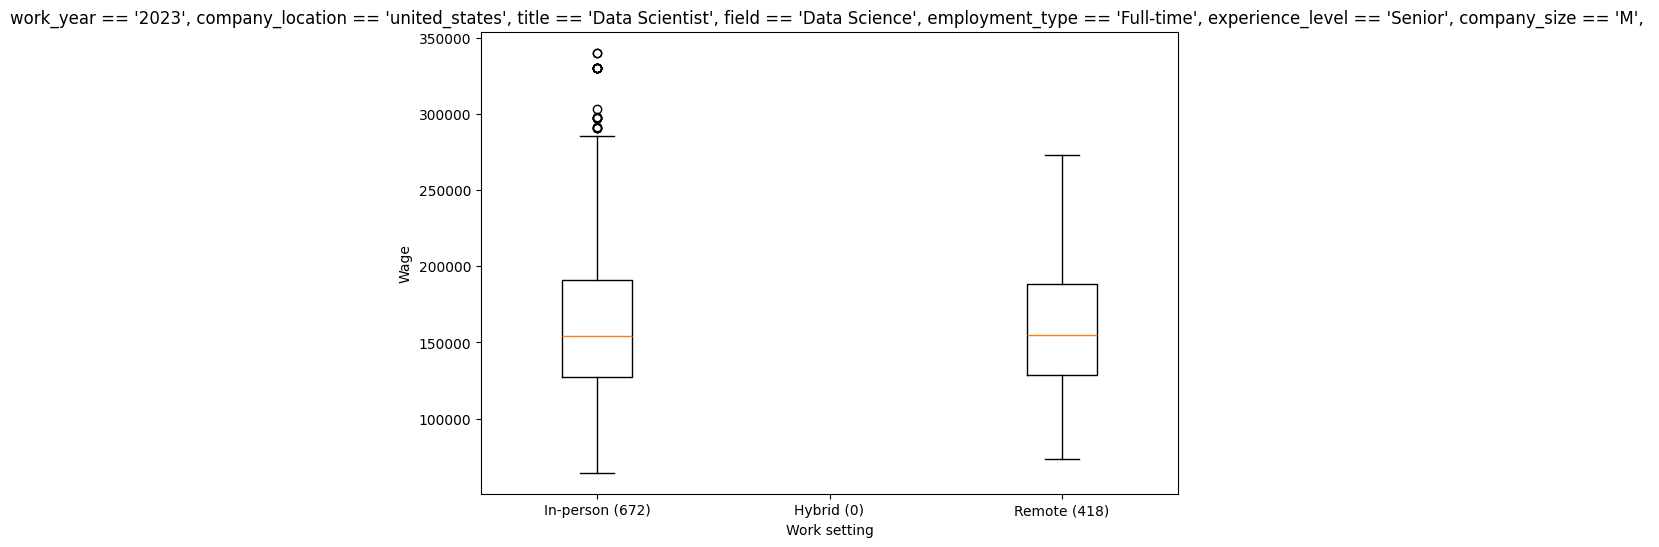

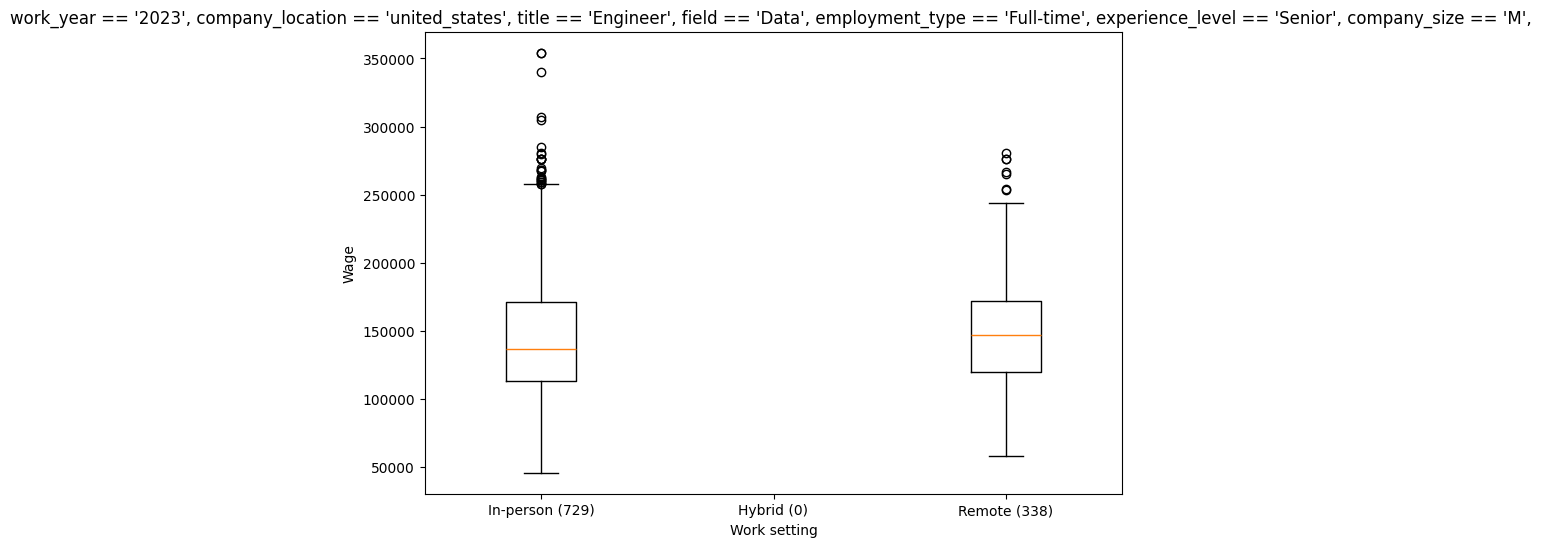

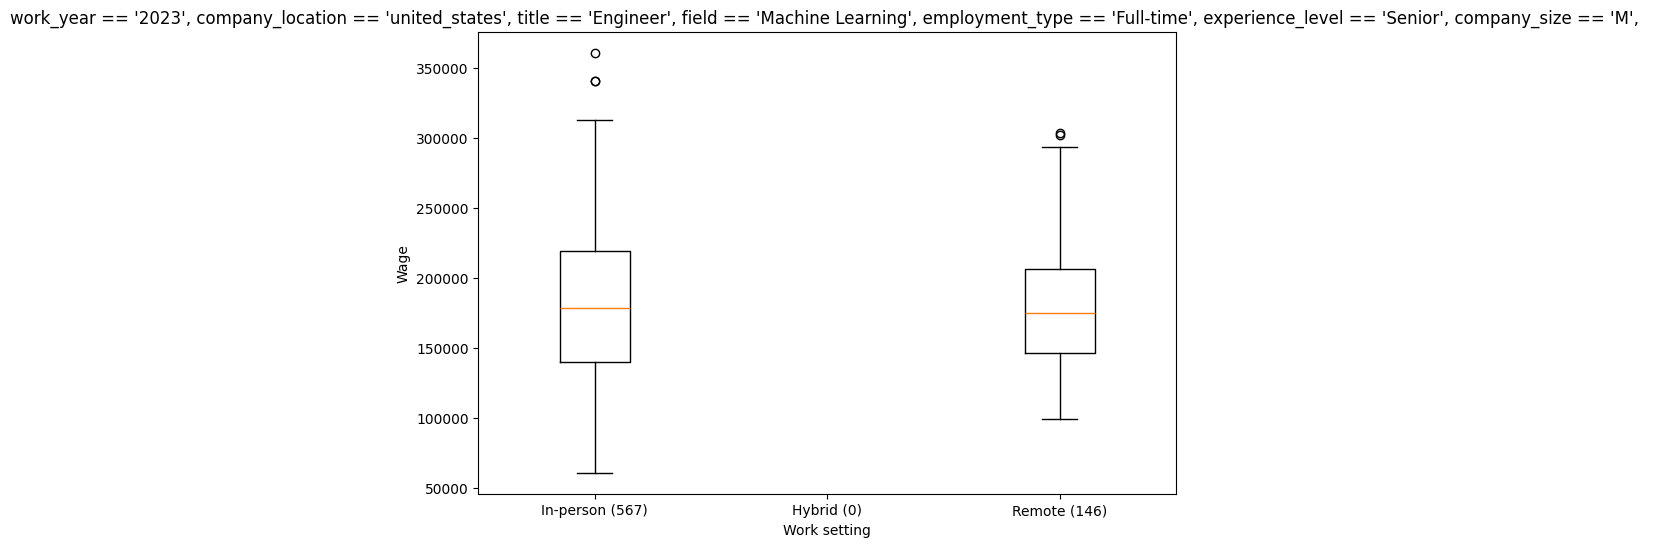

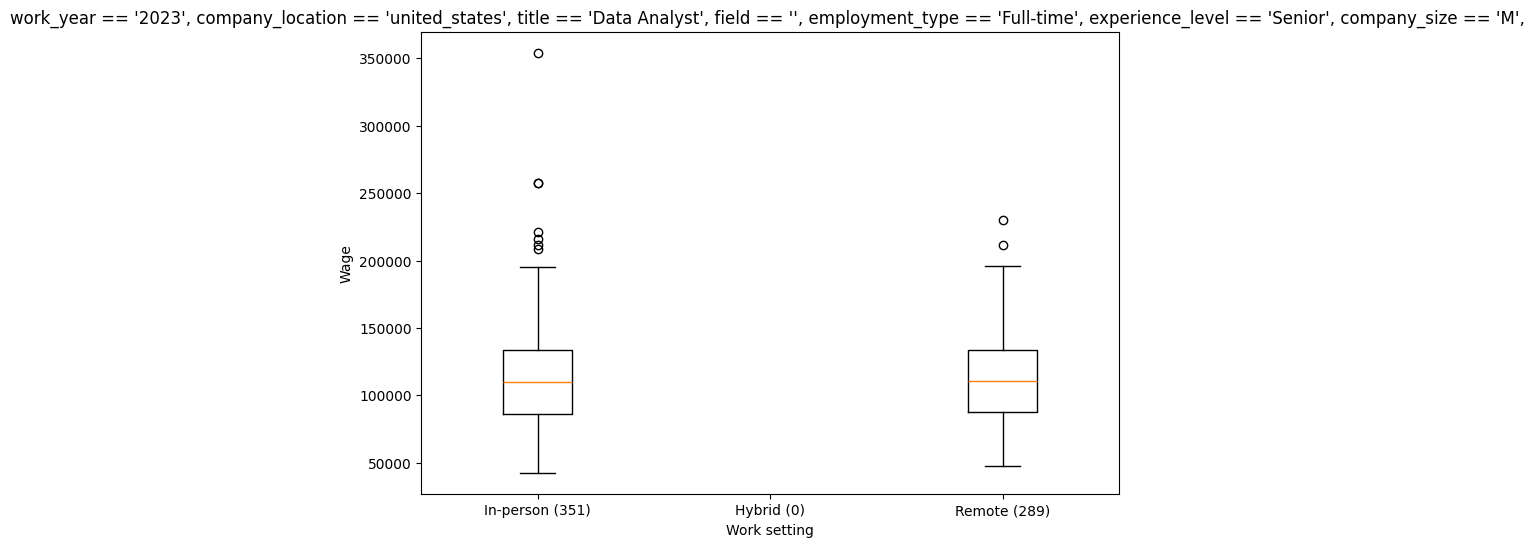

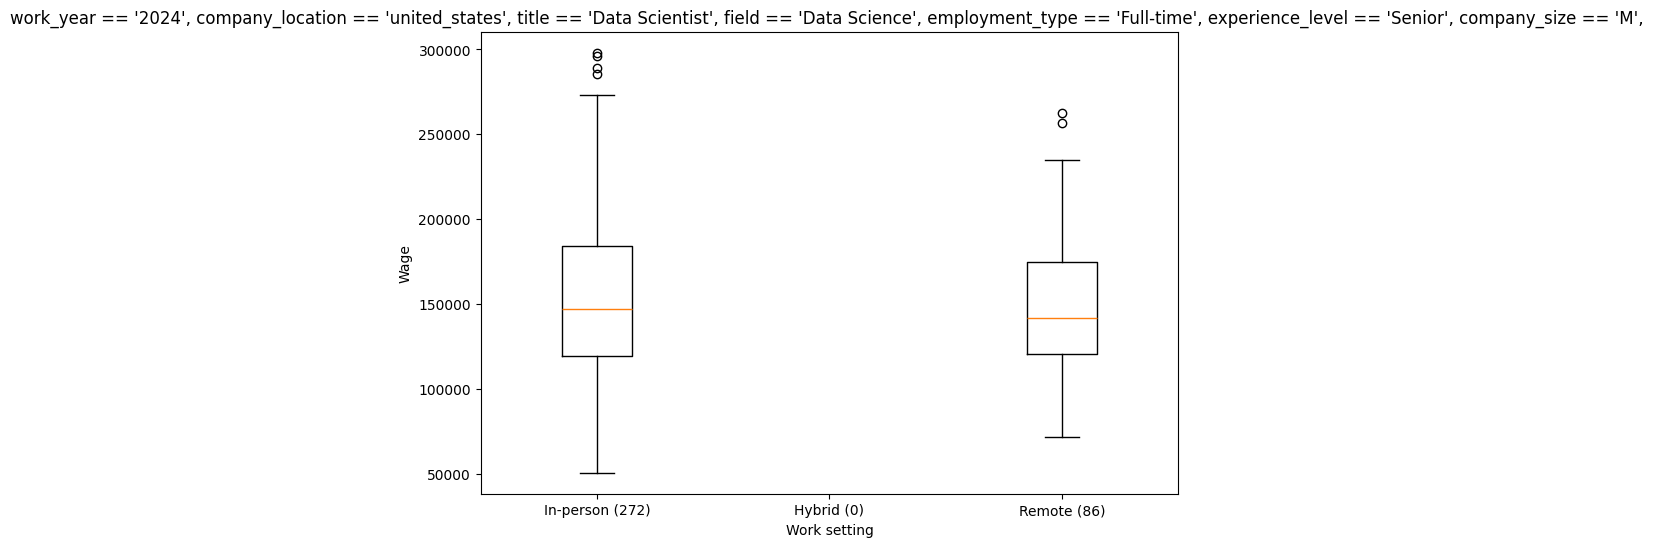

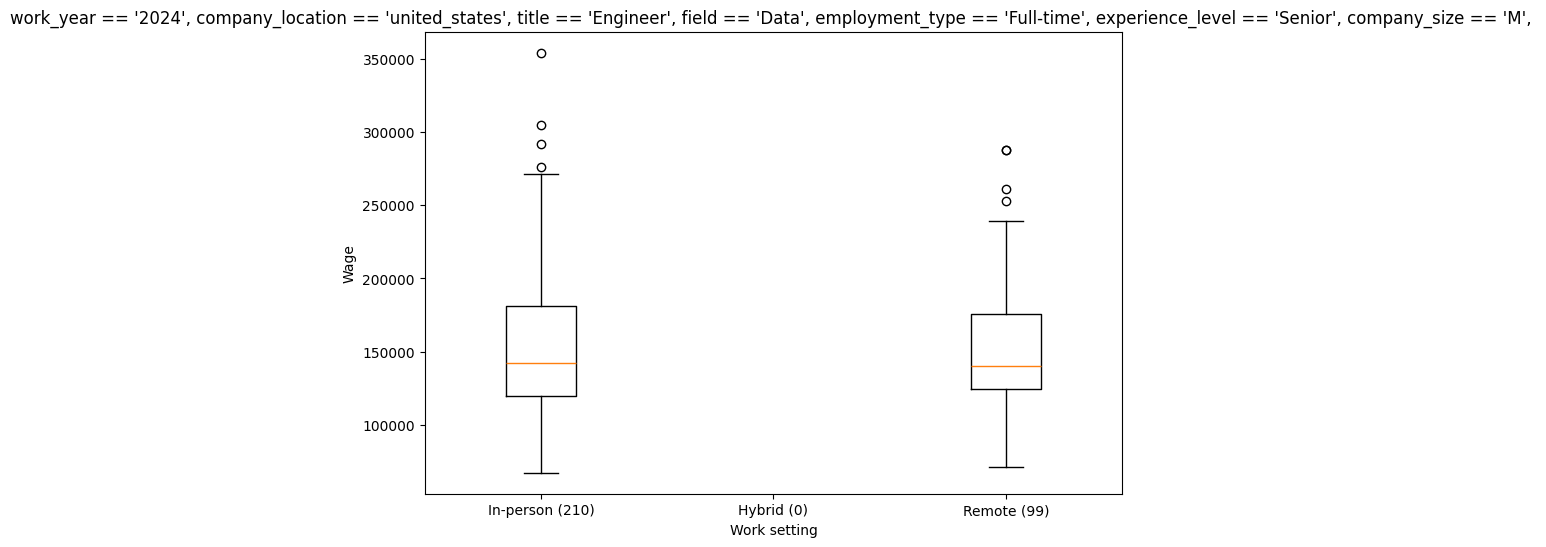

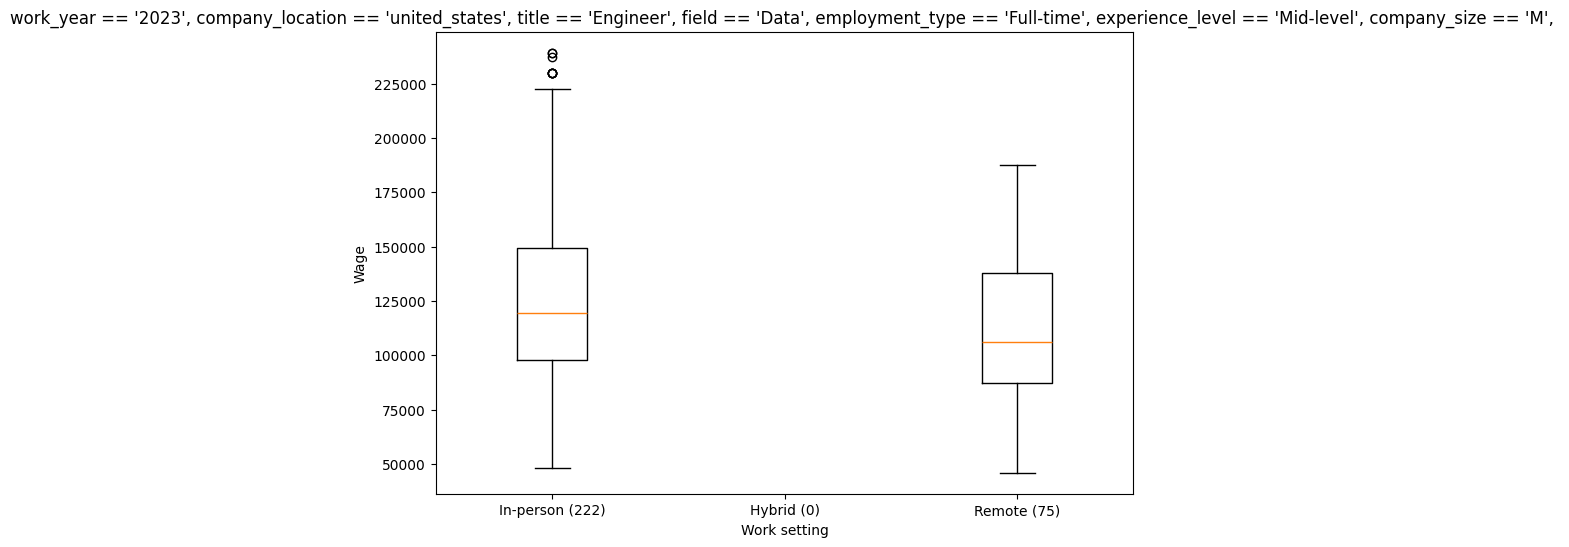

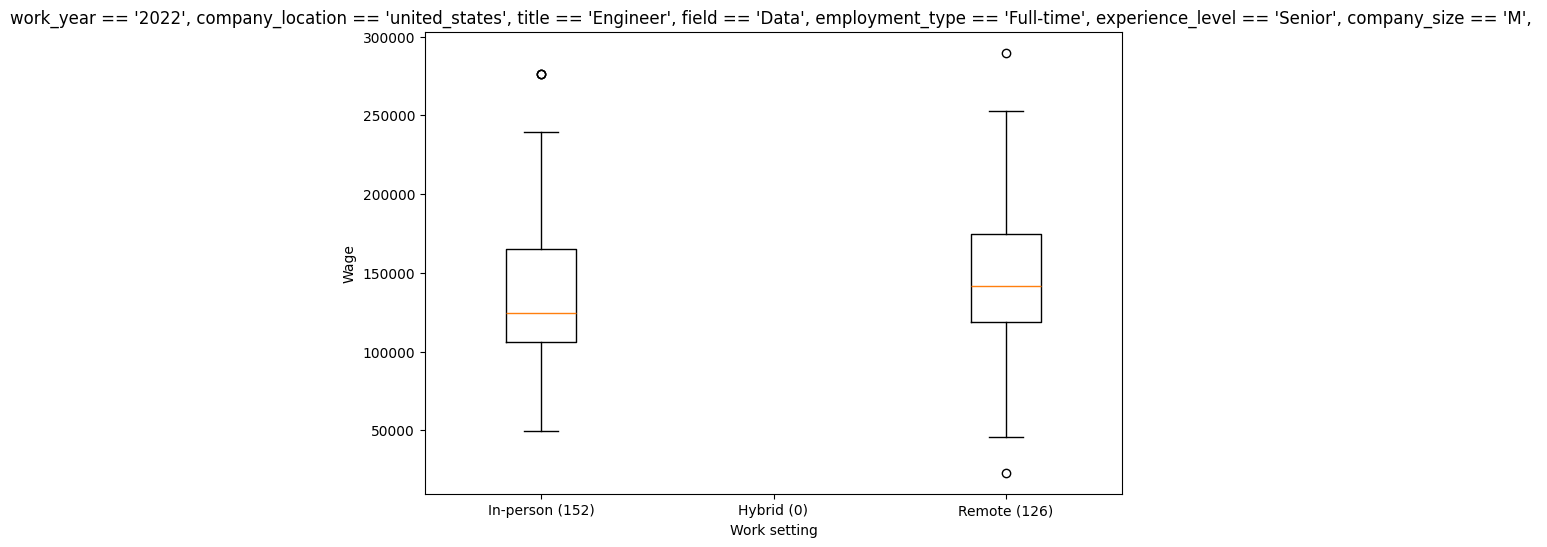

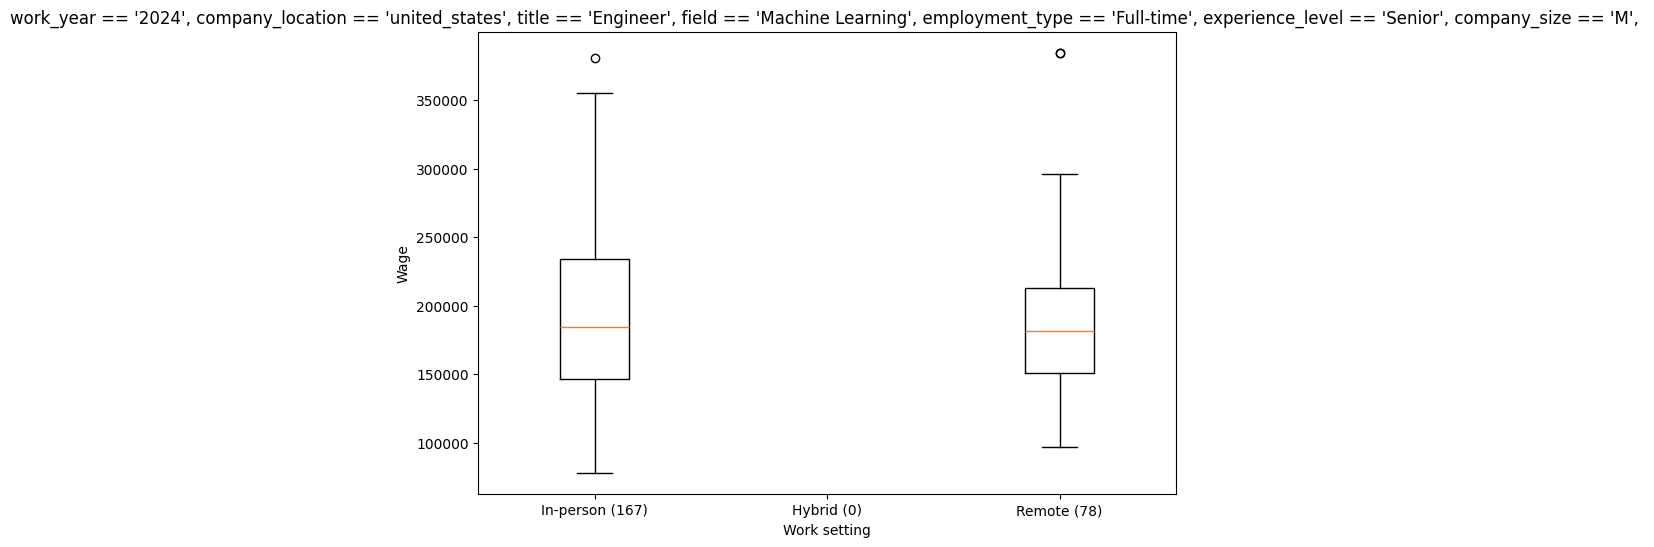

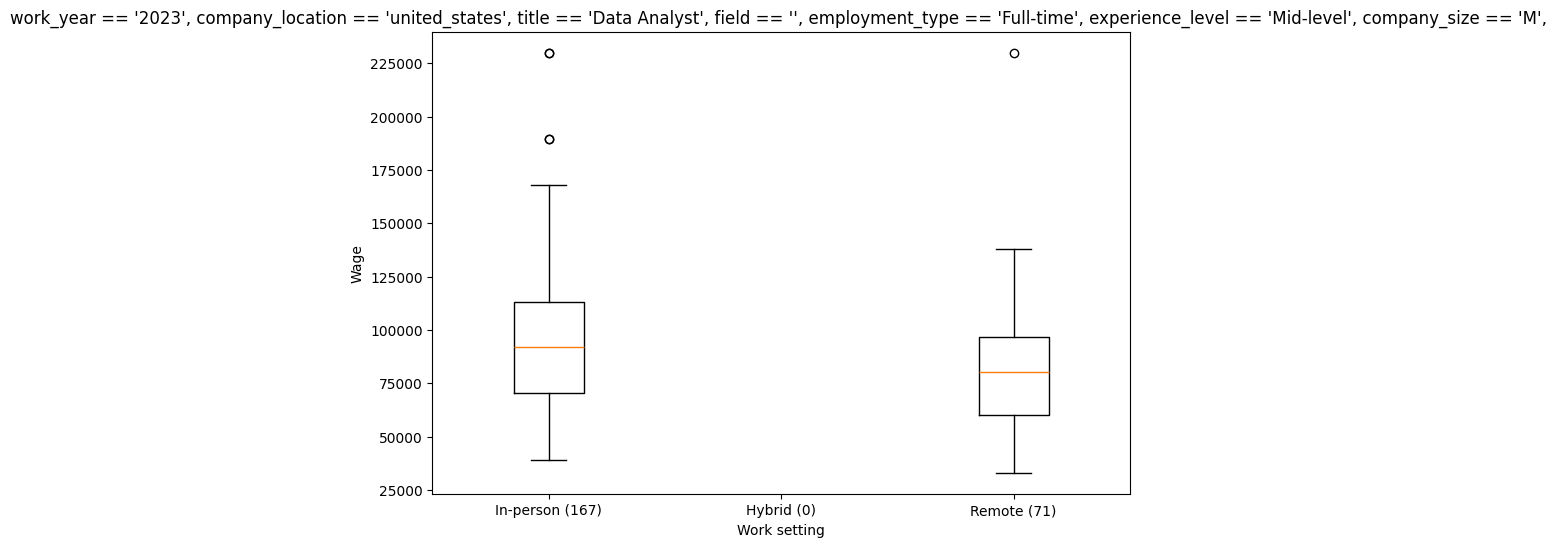

In [55]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

In the top ten most common listings there is no clear evidence that the work setting has an impact on wage. Let's check for ten random listings: 

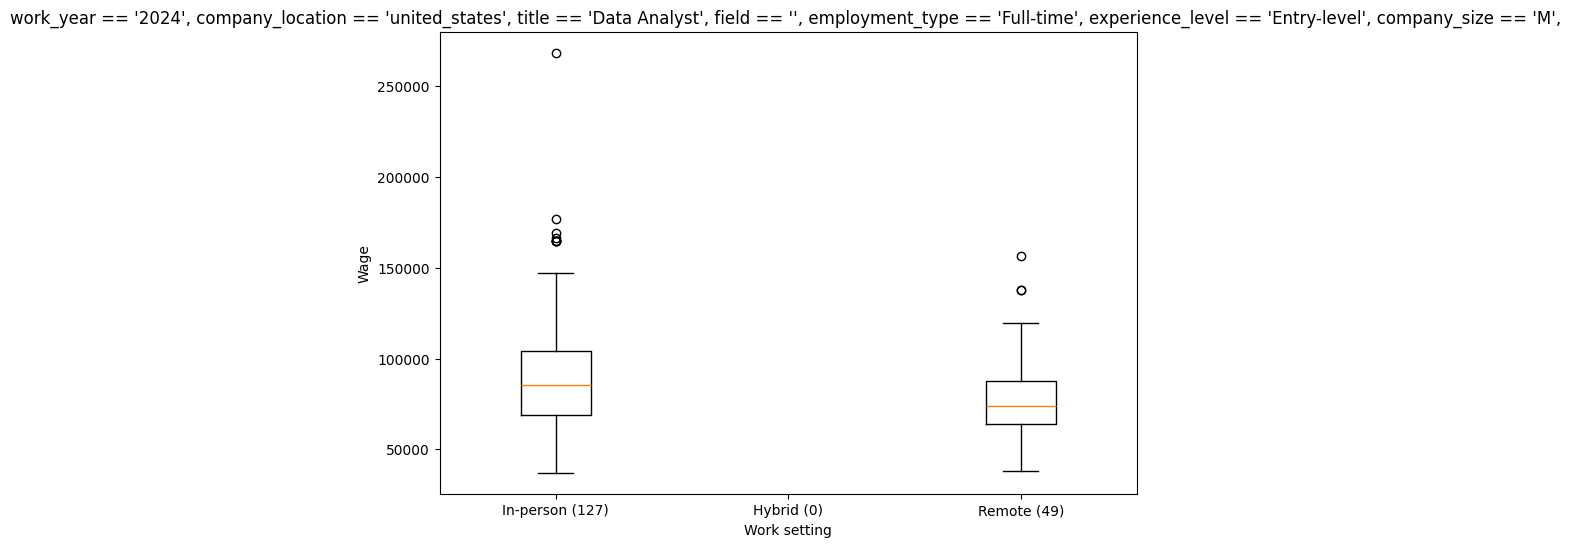

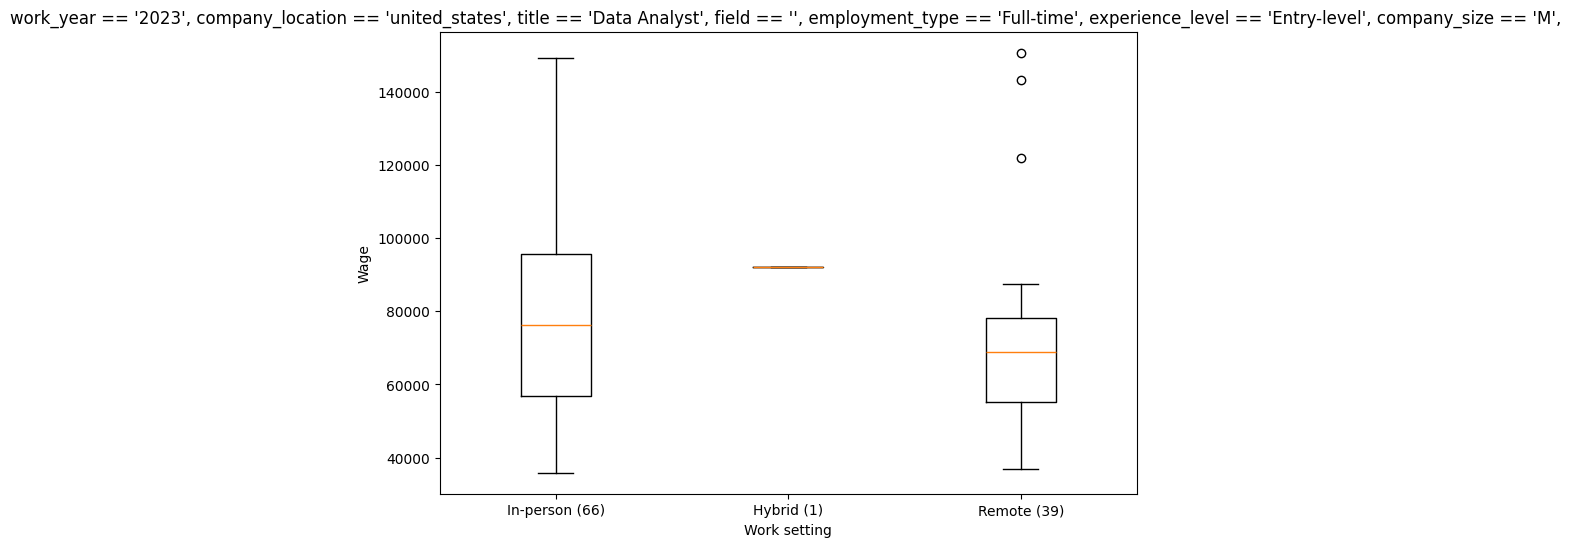

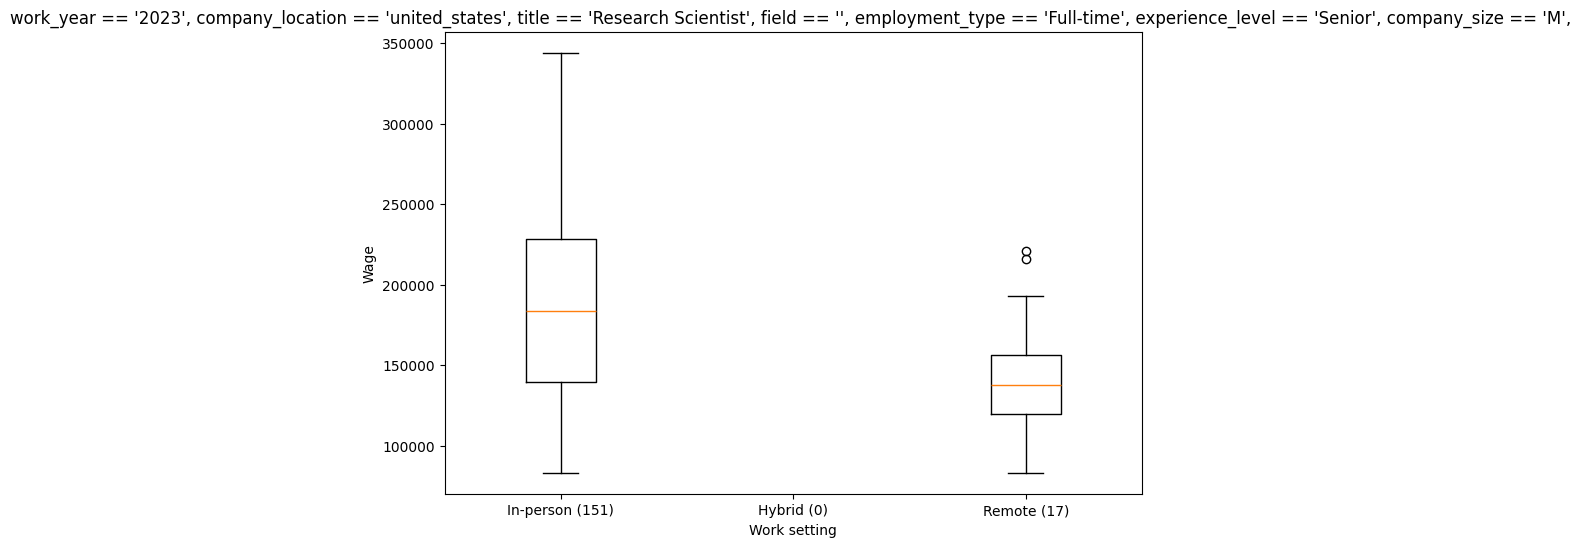

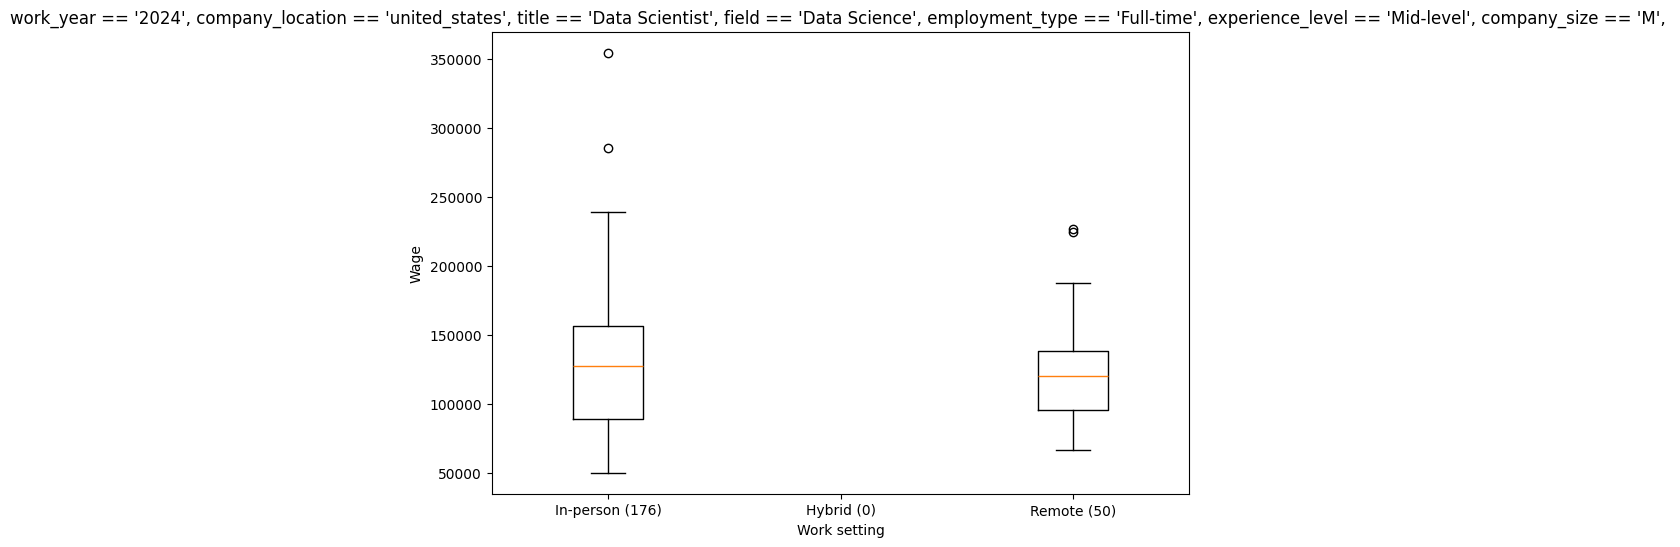

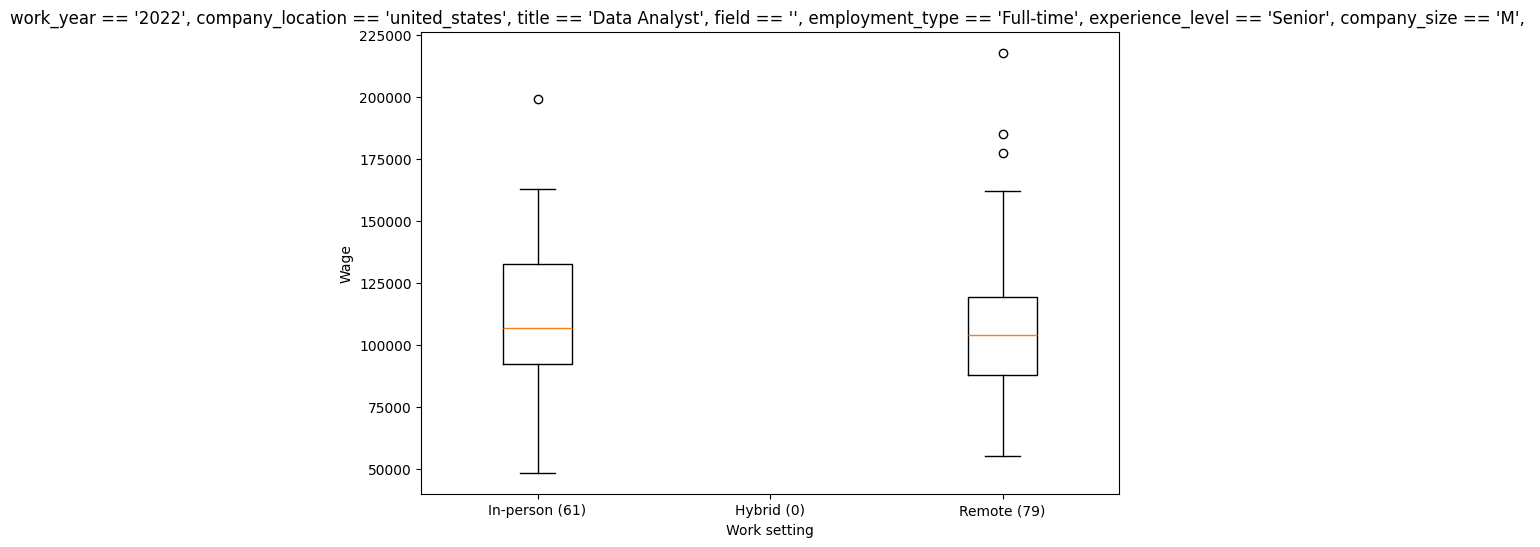

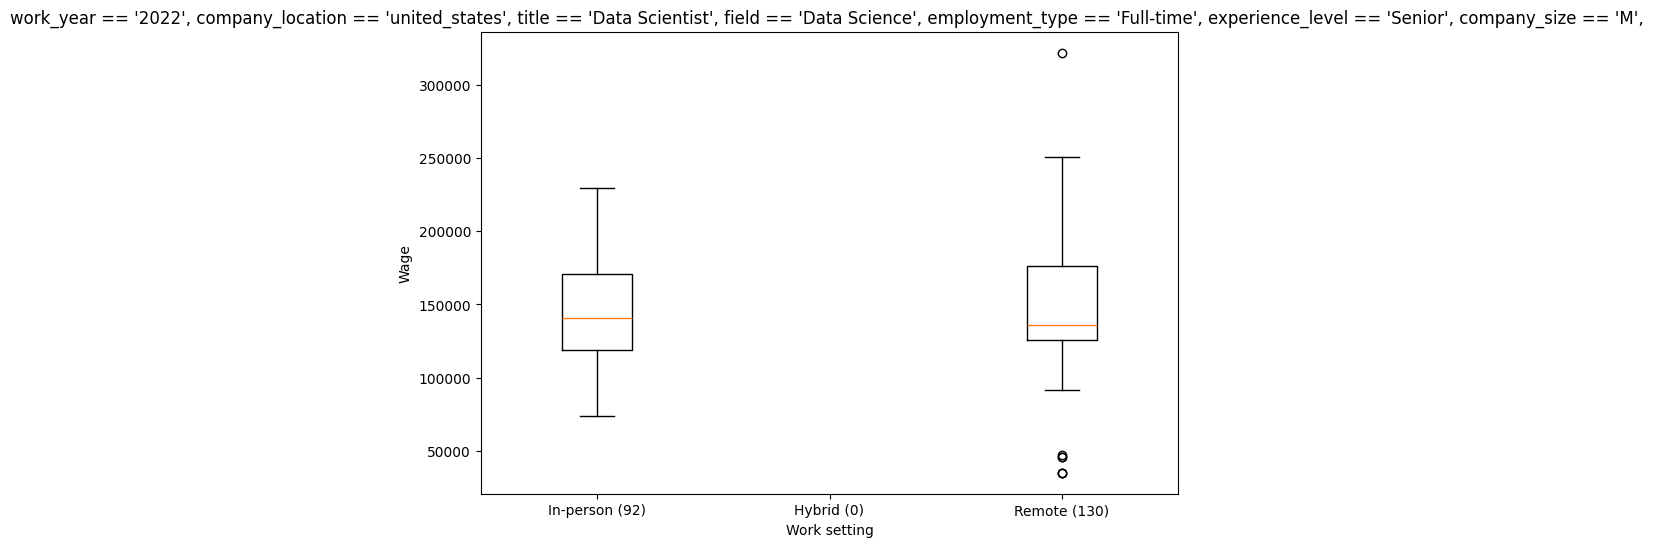

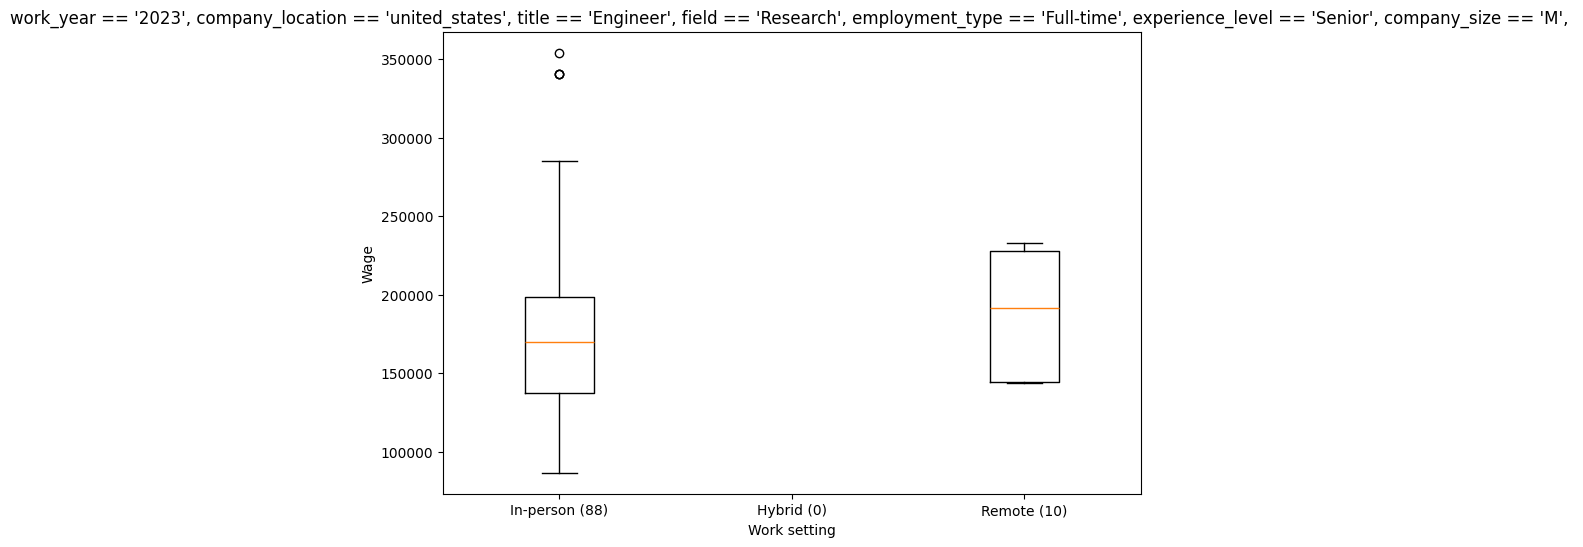

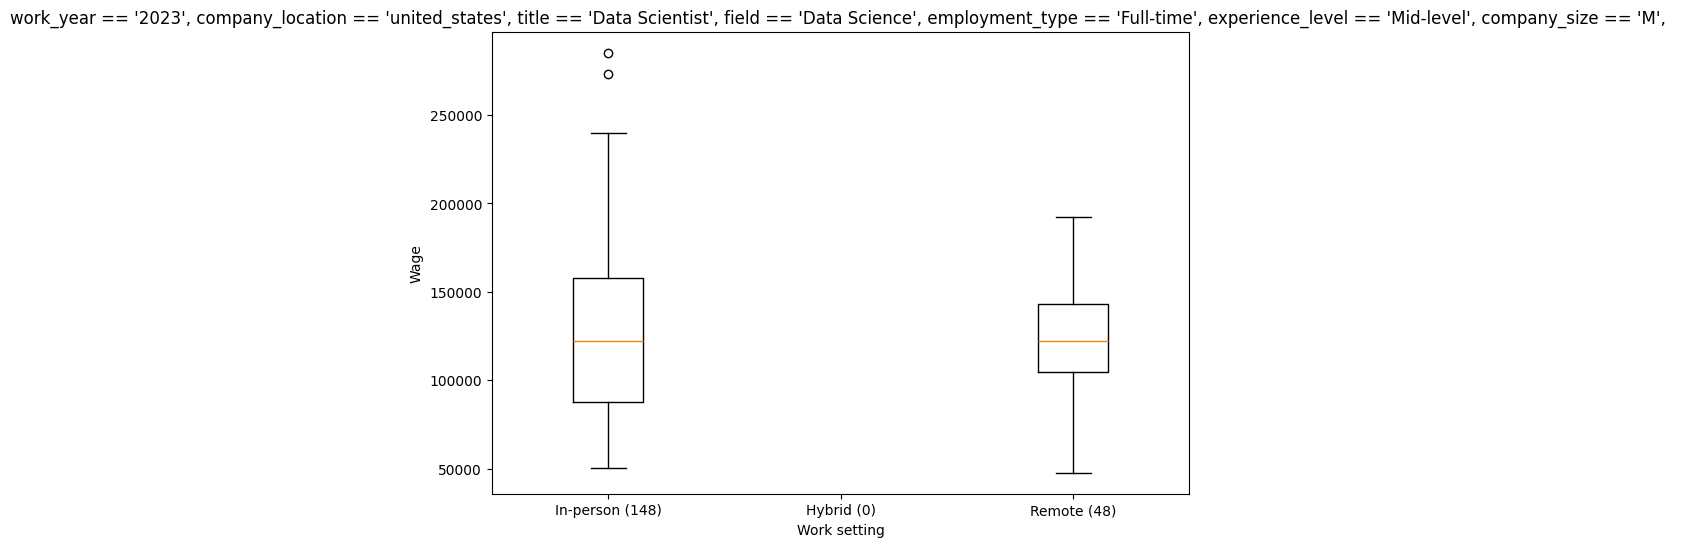

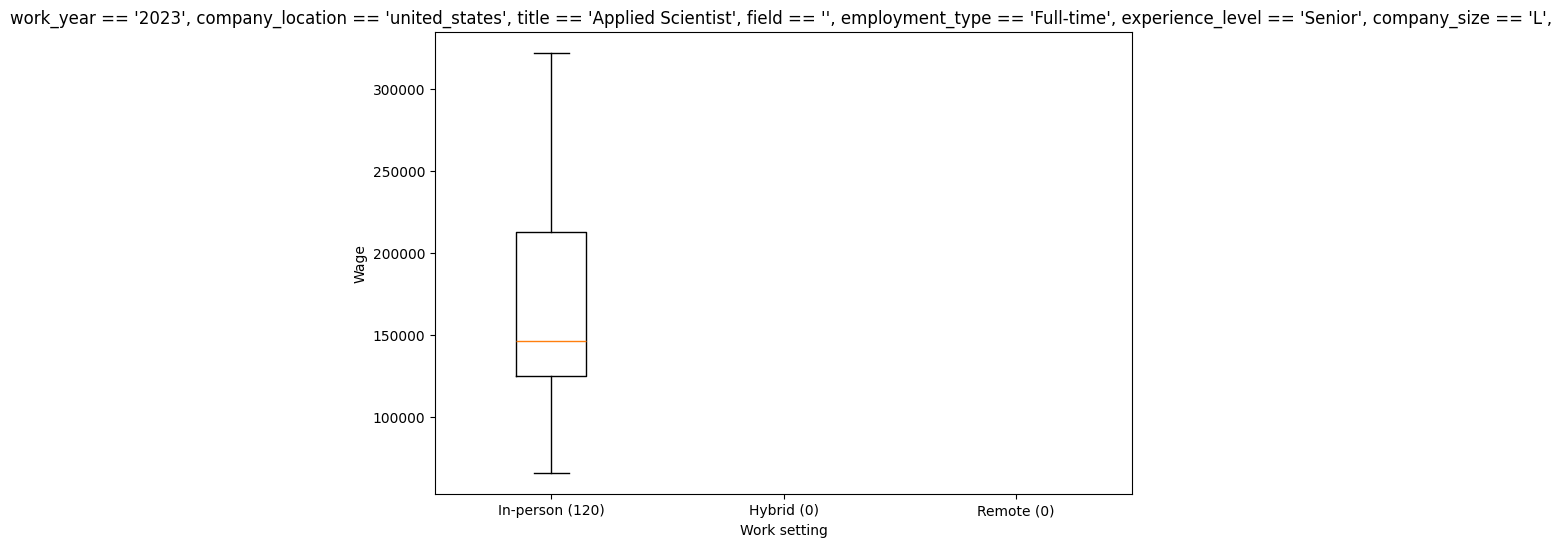

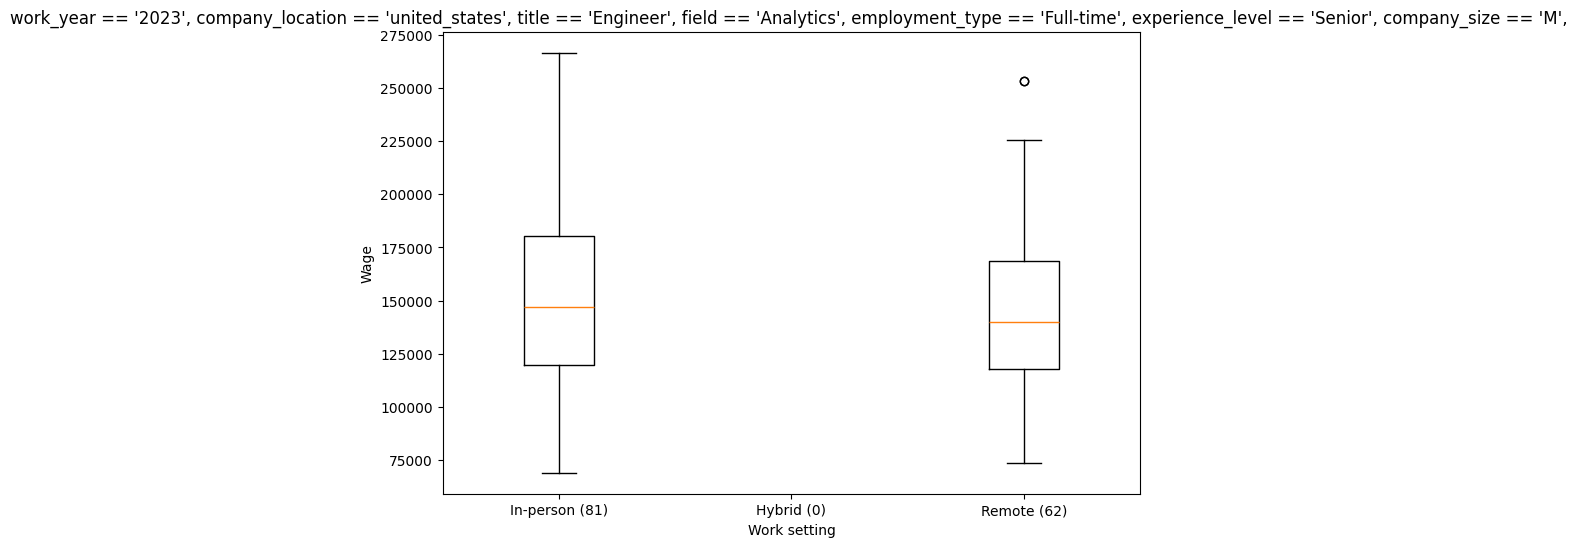

In [56]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

Randomly selecting rows does not make me wonder my preivous analysis - work_setting is no valuable feature. 

## 6.8 Impact dureation: halftime/fulltime.

In [57]:
df_processed.employment_type.unique()

array(['Full-time', 'Freelance', 'Contract', 'Part-time'], dtype=object)

In [58]:
key_for_question = 'employment_type'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field experience_level company_size work_setting  count
930       2023    united_states        Engineer              Data           Senior            M    In-person    729
872       2023    united_states  Data Scientist      Data Science           Senior            M    In-person    672
972       2023    united_states        Engineer  Machine Learning           Senior            M    In-person    567
873       2023    united_states  Data Scientist      Data Science           Senior            M       Remote    418
846       2023    united_states    Data Analyst                             Senior            M    In-person    351

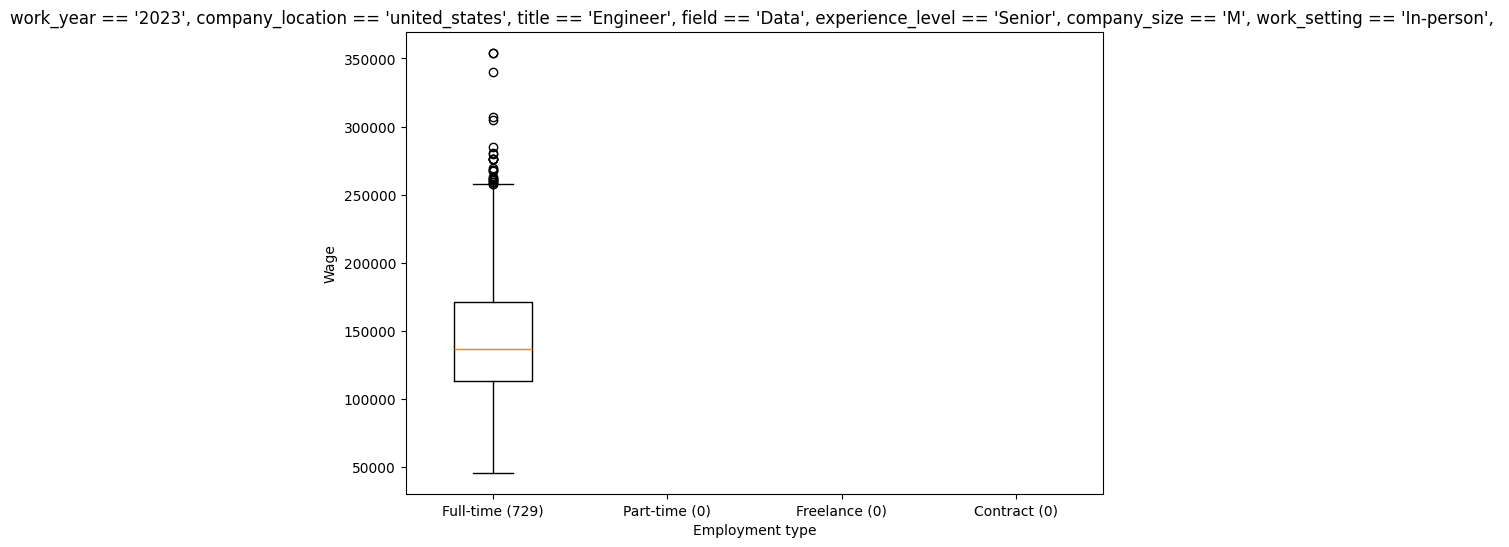

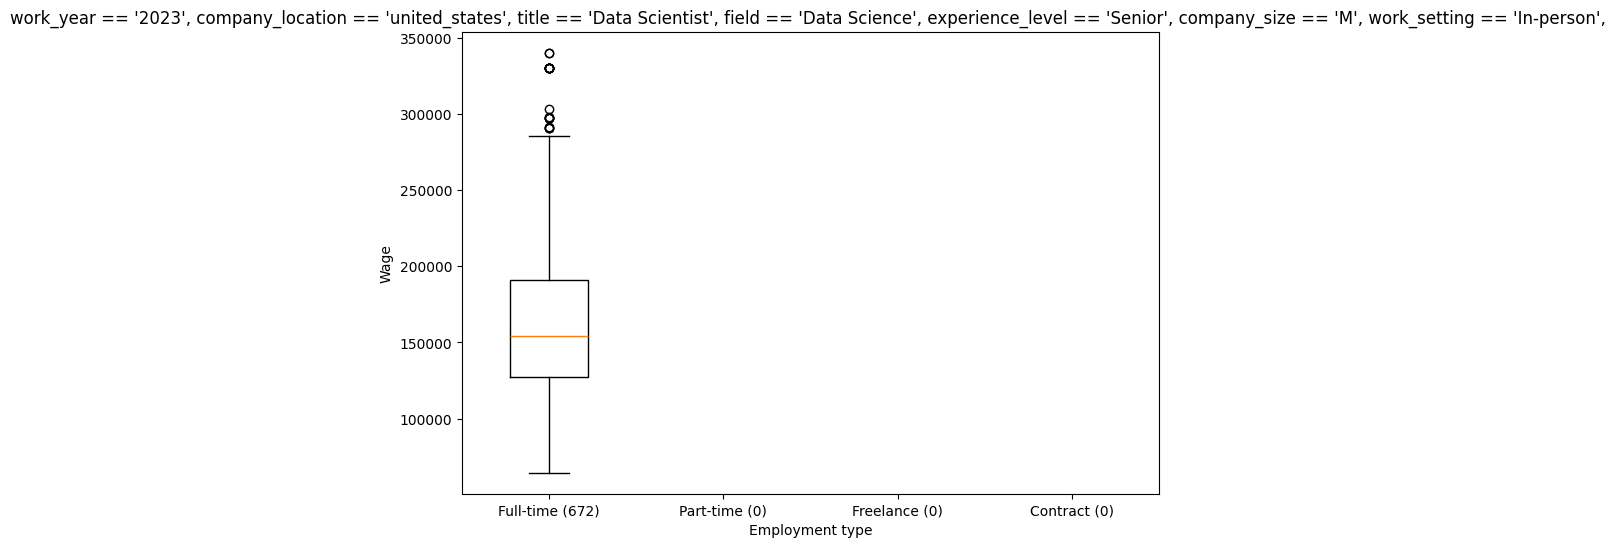

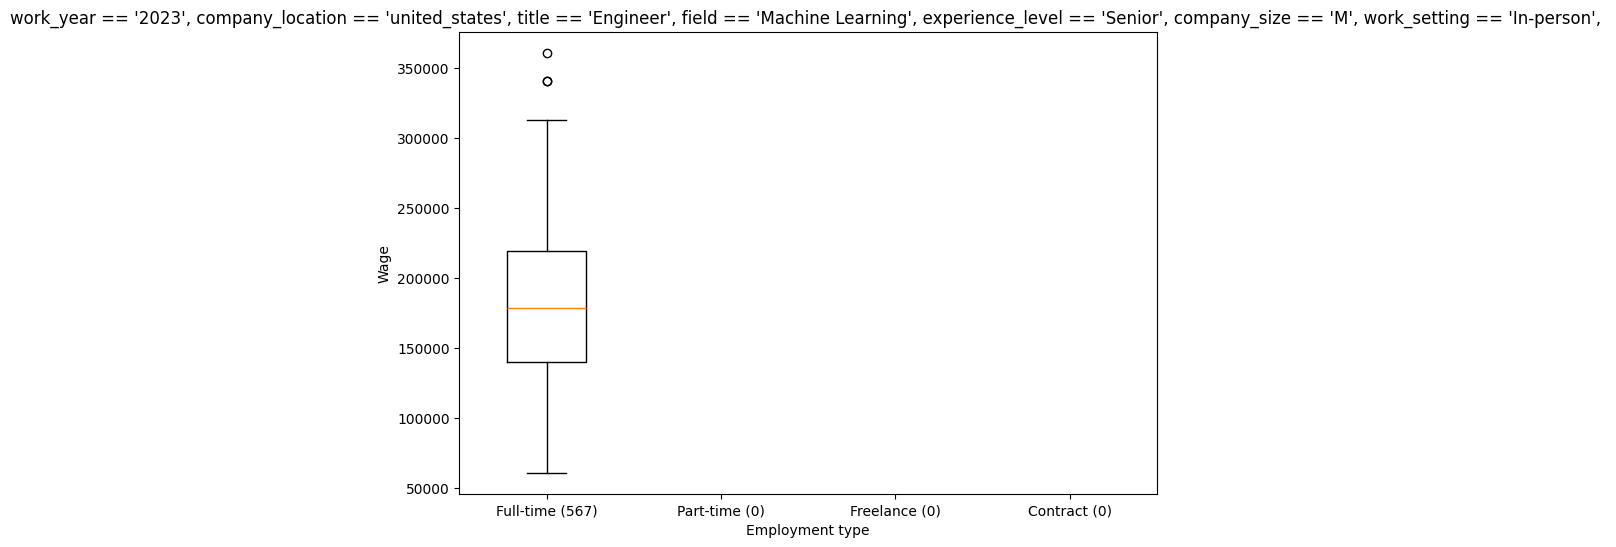

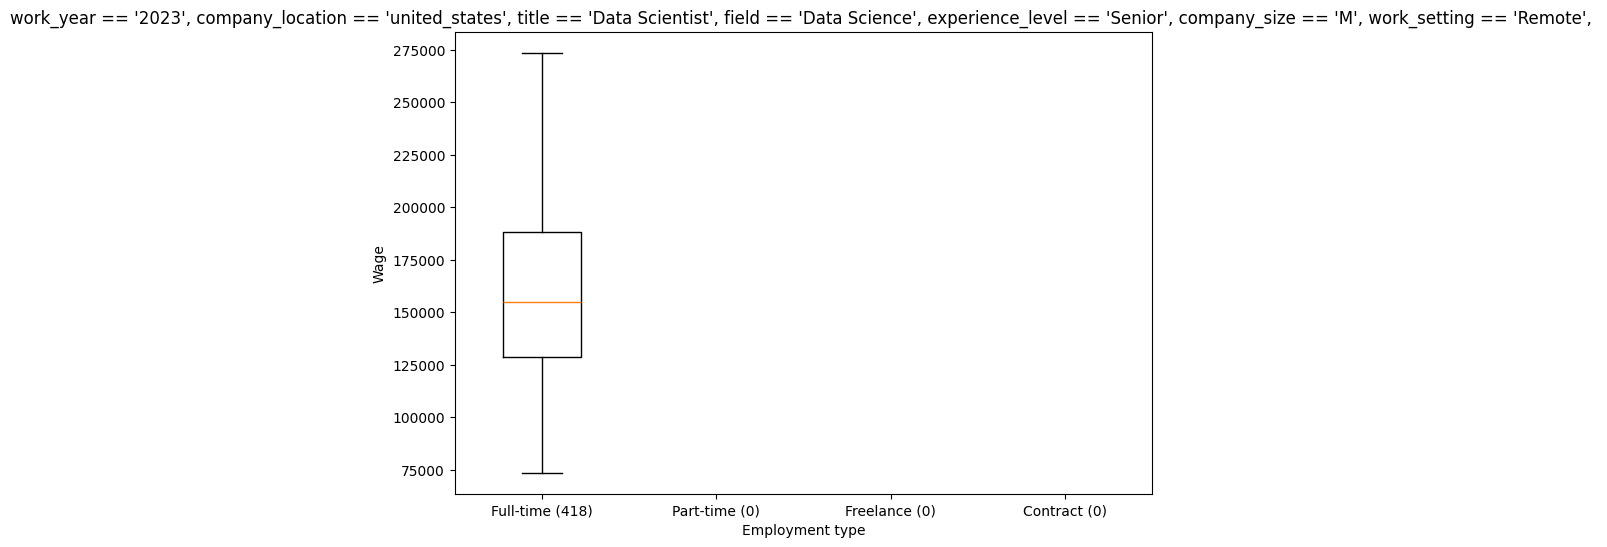

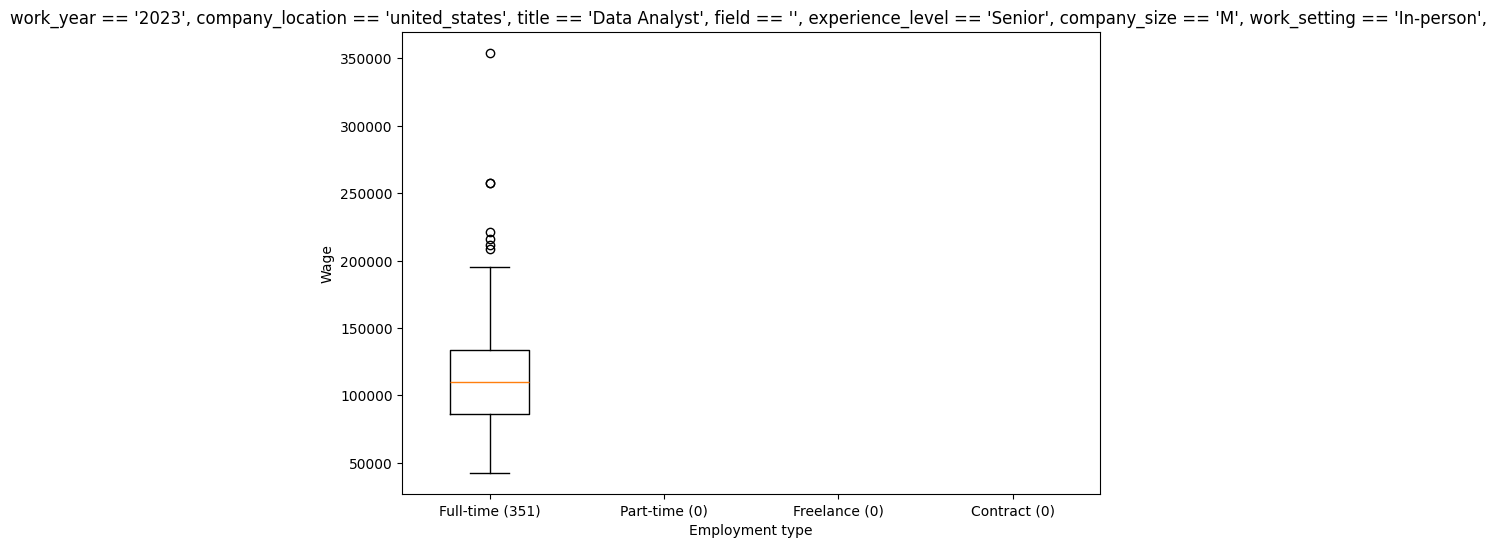

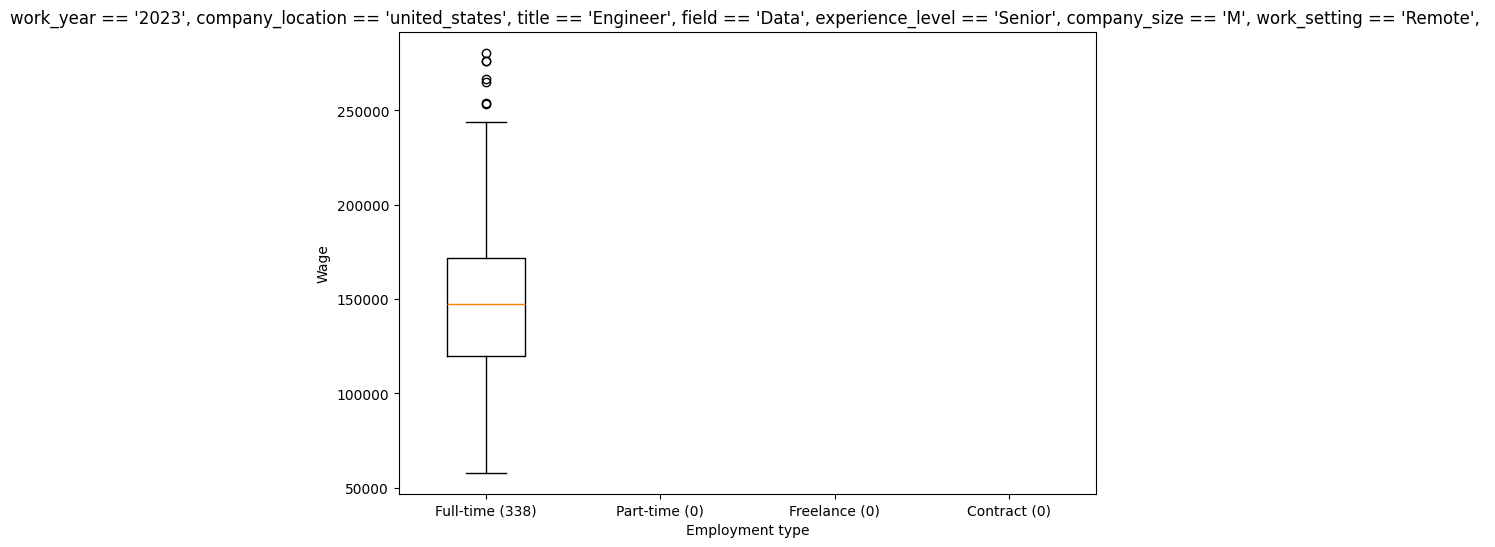

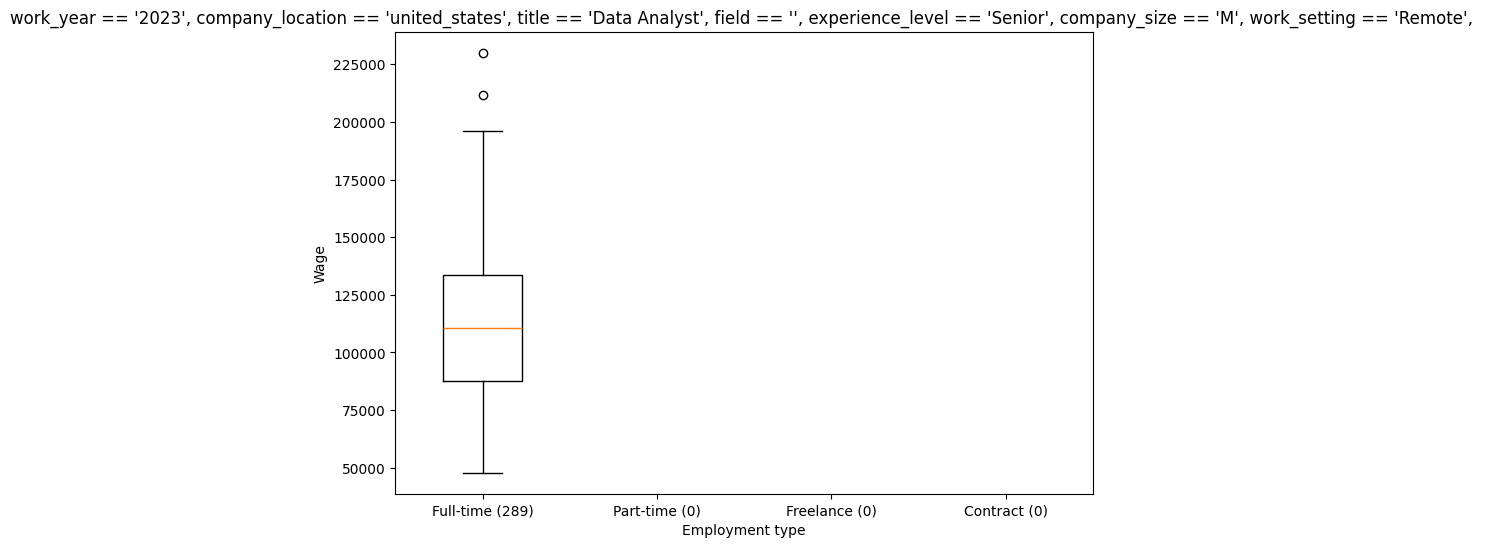

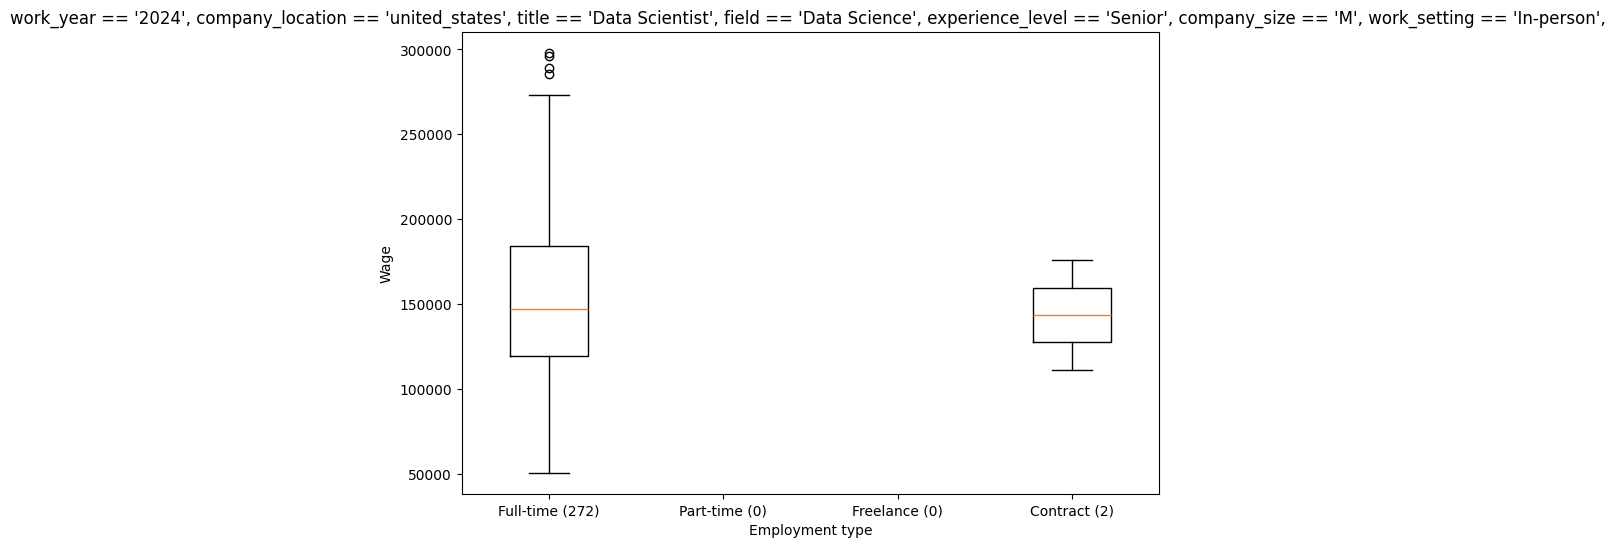

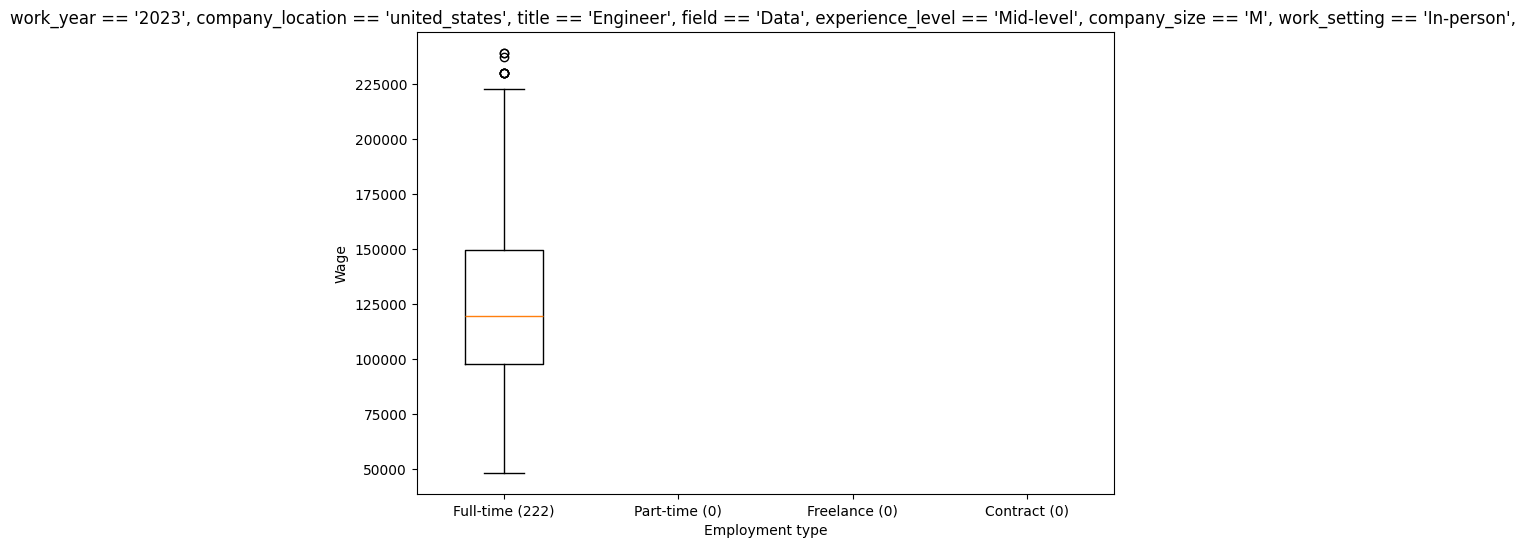

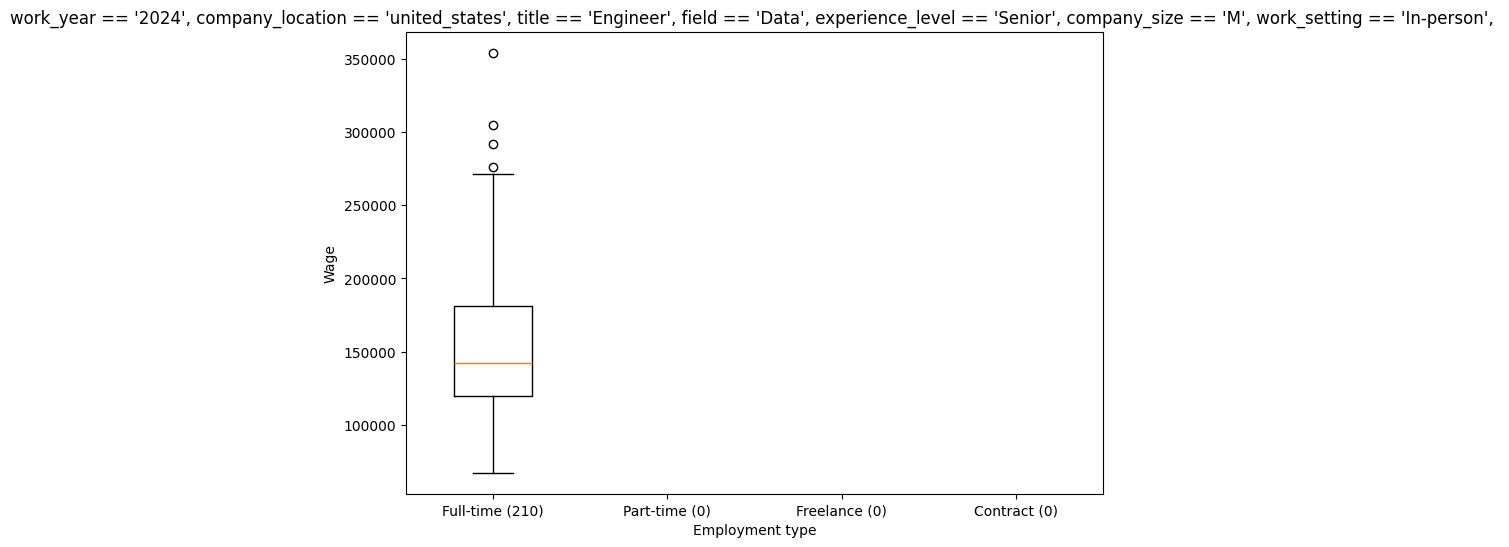

In [59]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

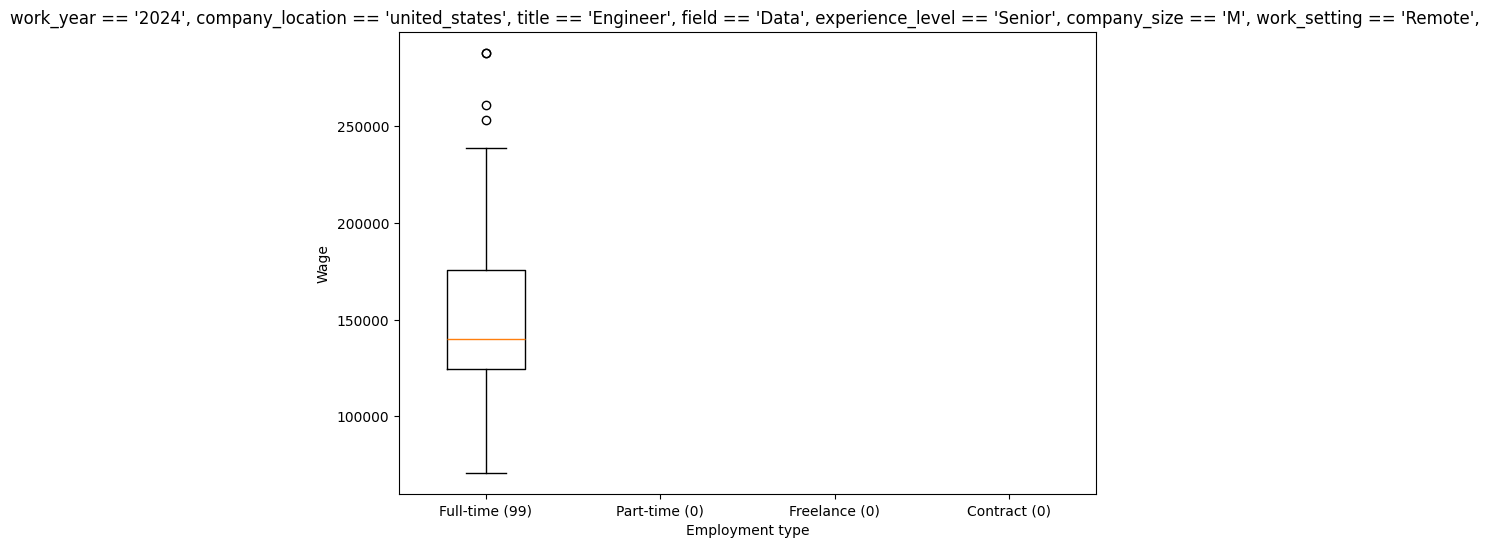

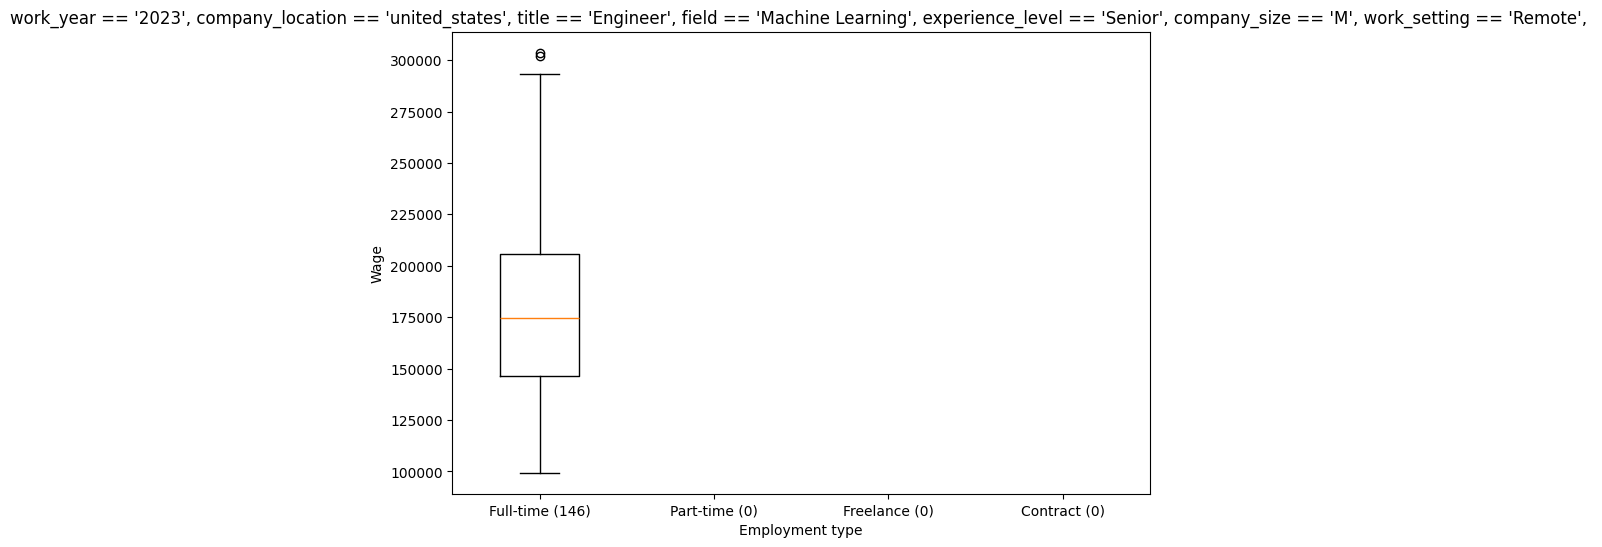

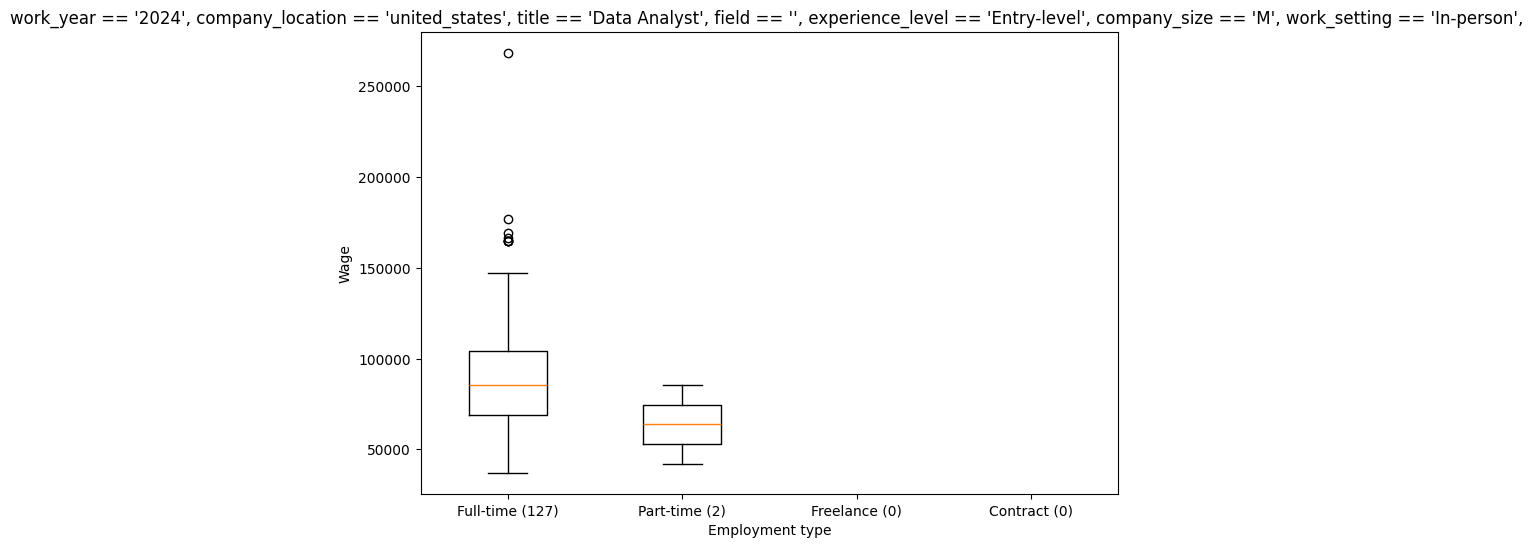

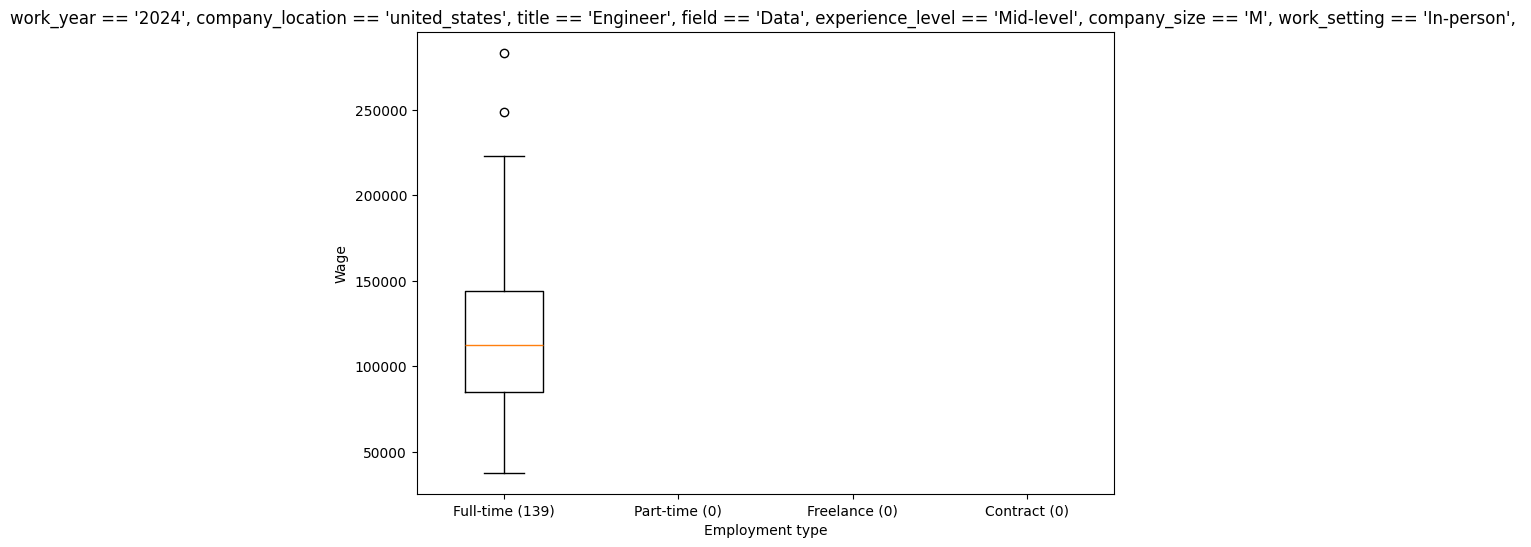

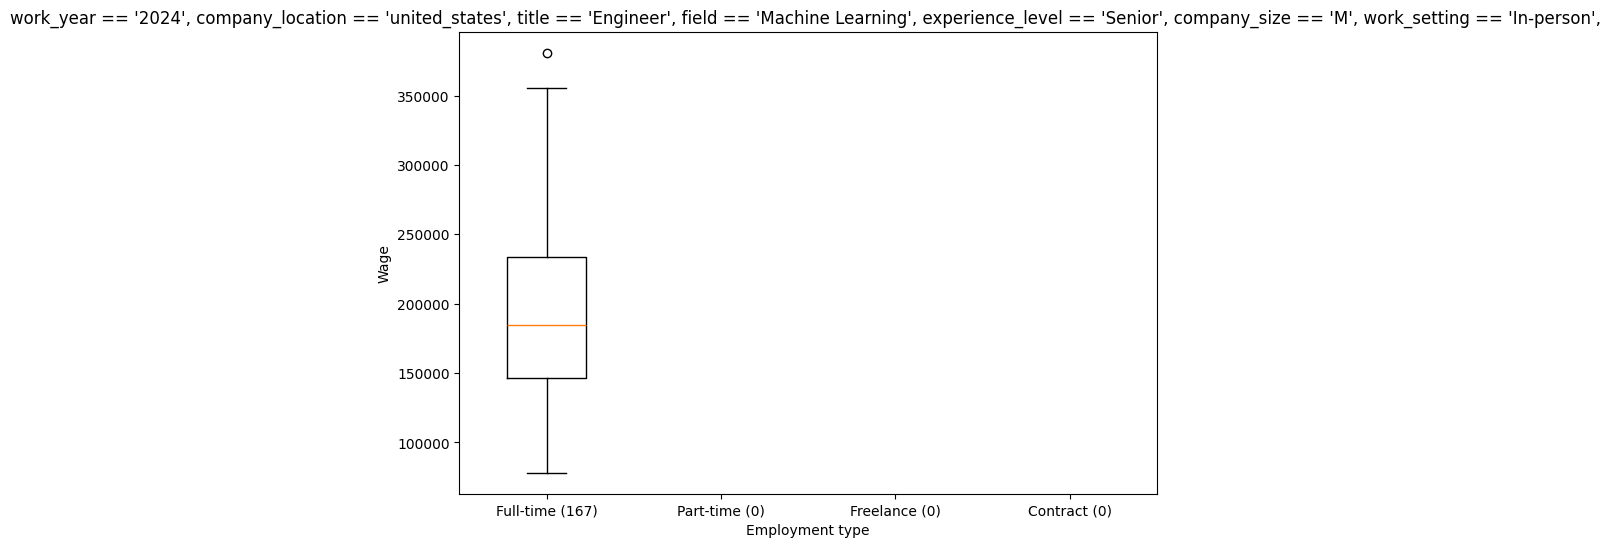

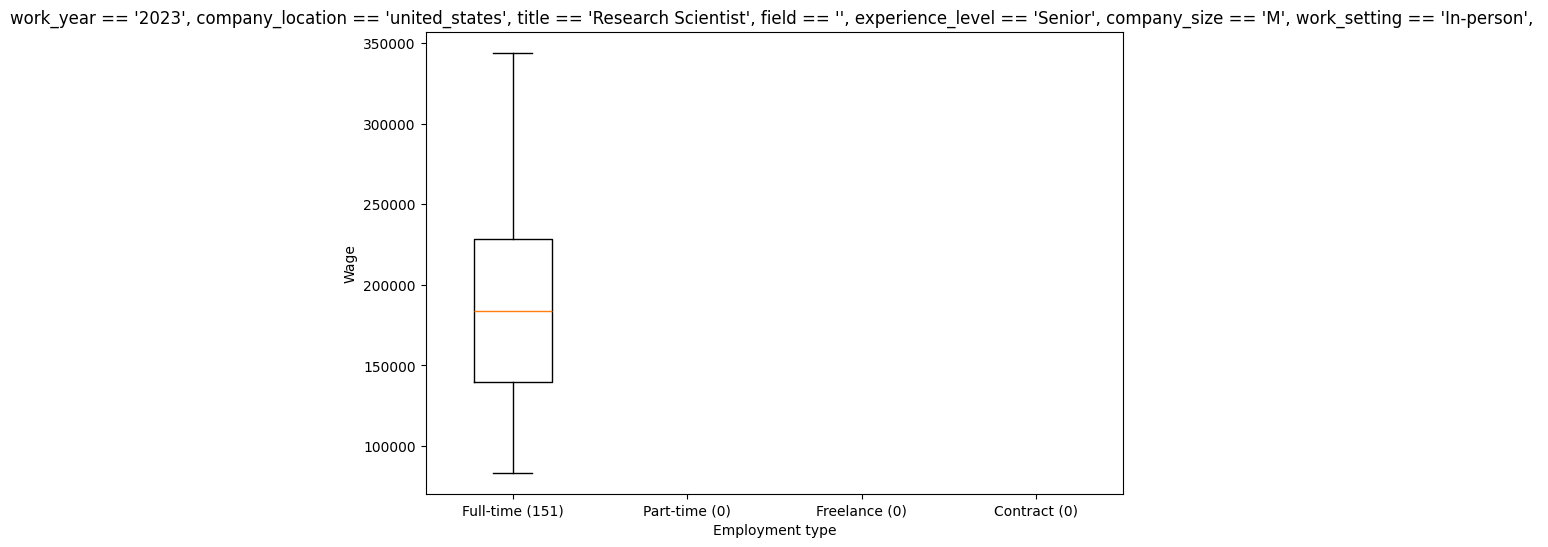

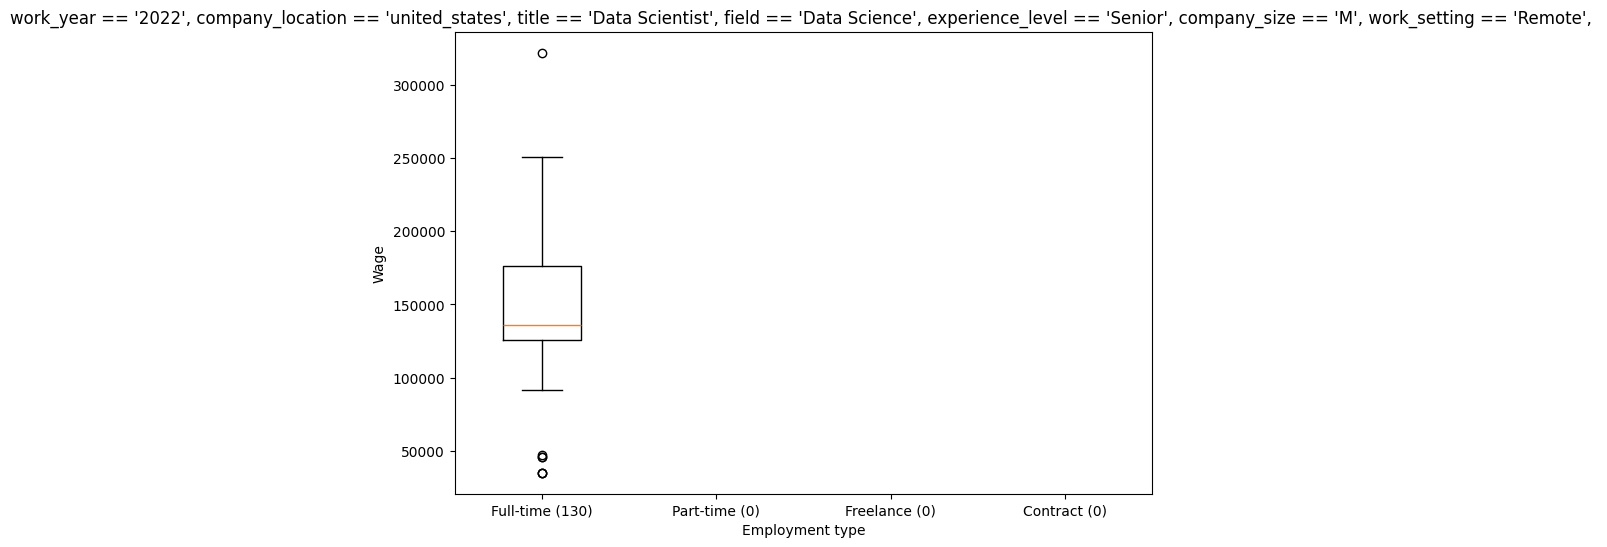

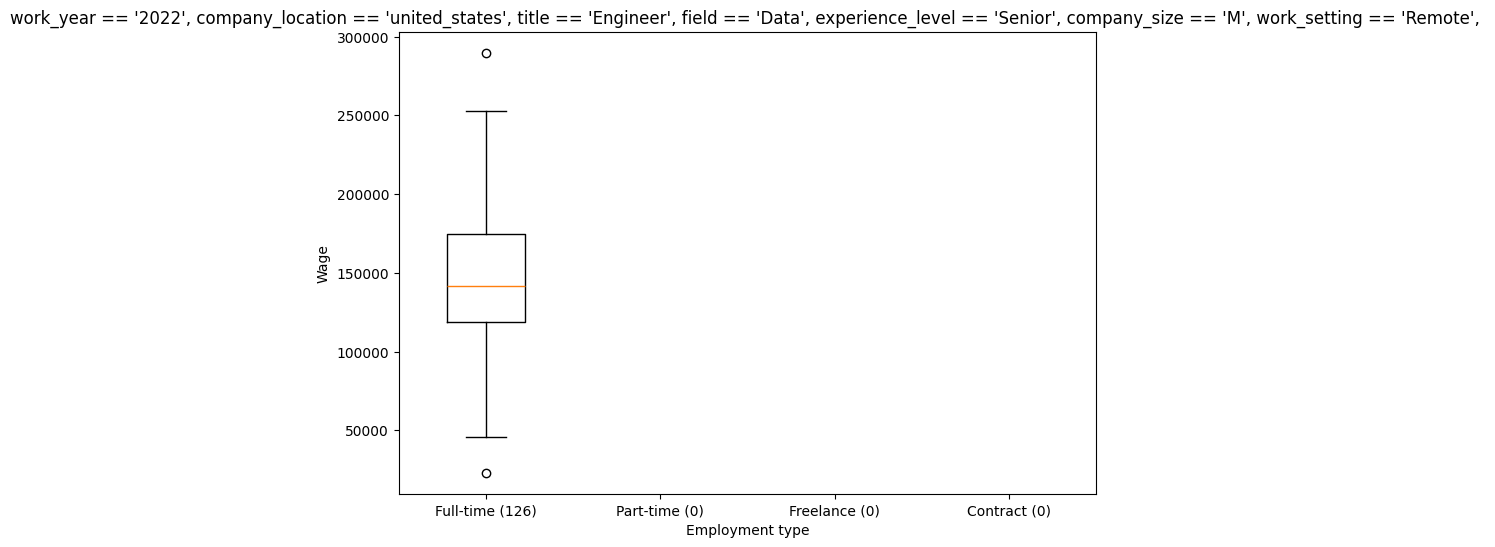

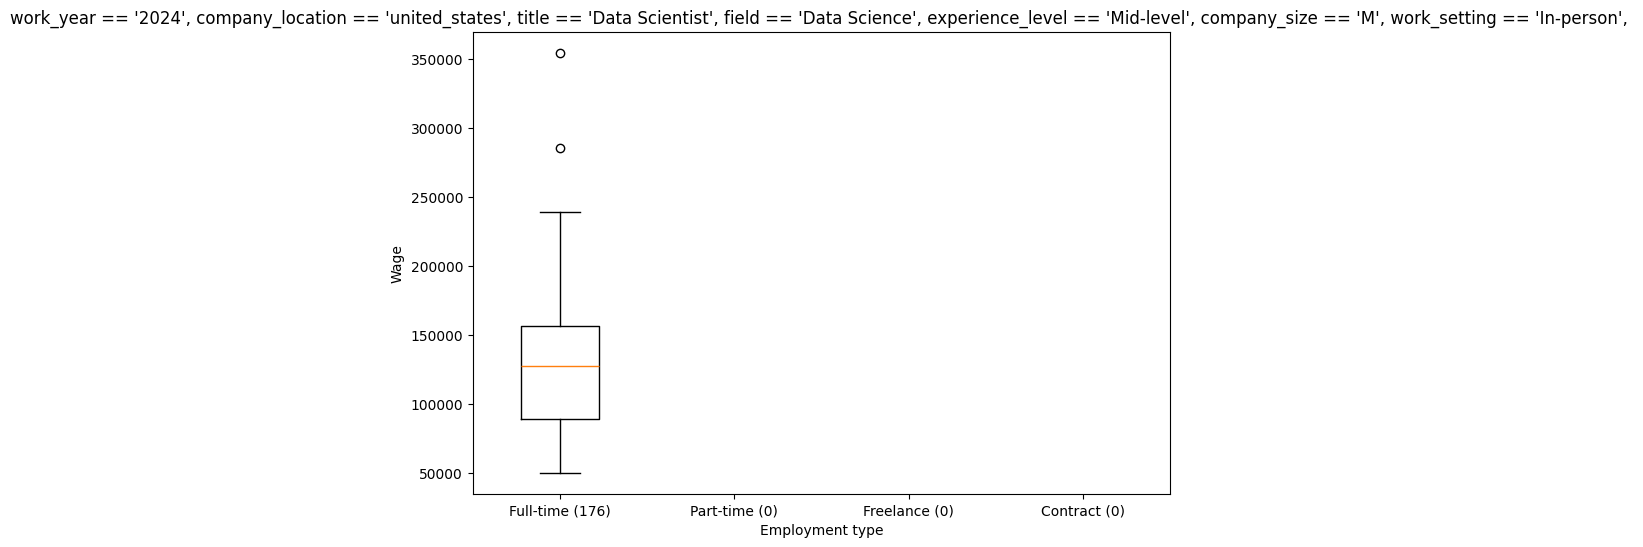

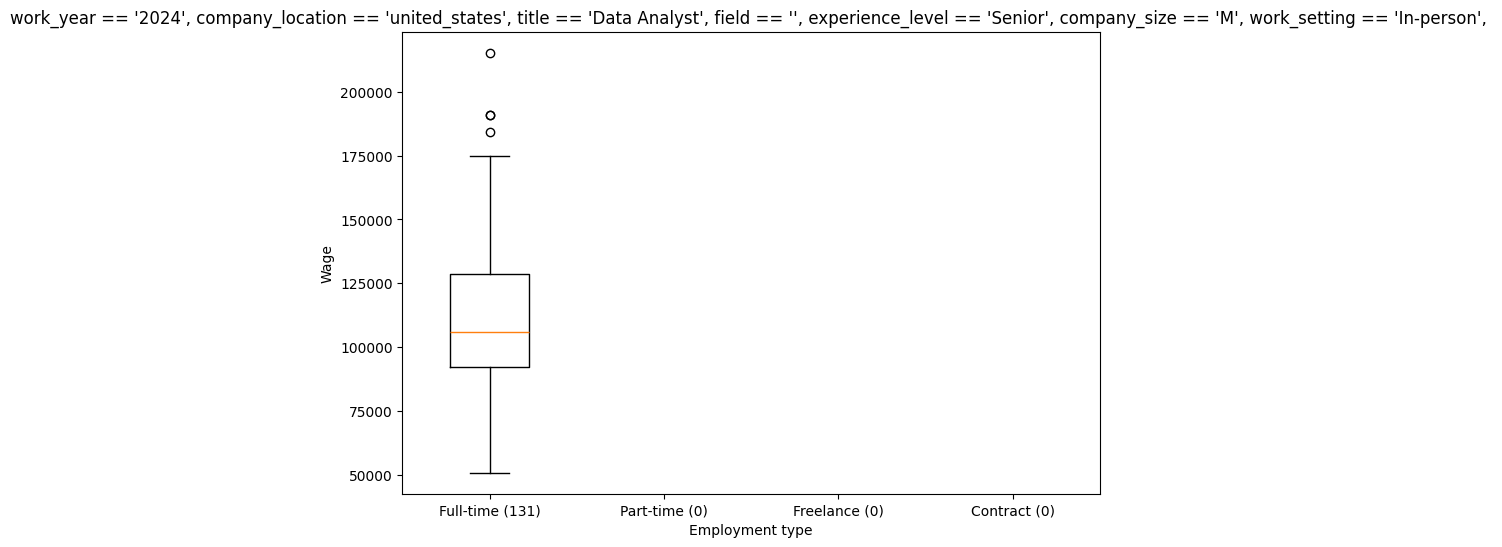

In [60]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

There are very little positions that are not full_time positions. This makes it hard to express with certainty if this really makes a difference. To fully answer 6.8 let's take a step back and look at the bigger picture for the US (has the most records) in 2023.

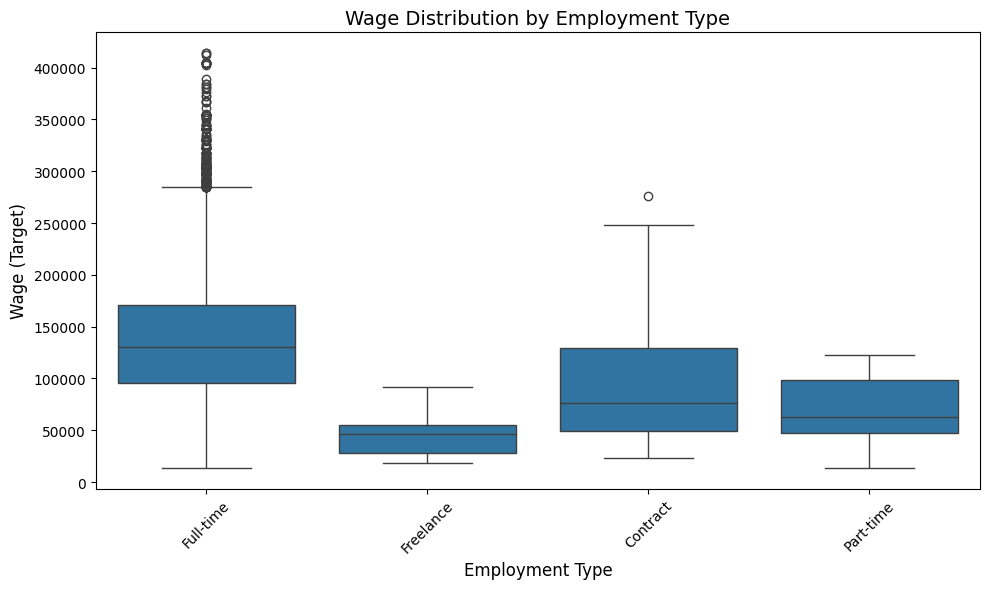

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='employment_type', y='target', data=df_processed)

# Set plot title and labels
plt.title('Wage Distribution by Employment Type', fontsize=14)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Wage (Target)', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

let's not bother with this feature too much: we can see it has an impact in the overall dataset - and it makes sense to assume that part-time pays less than full-time. With that in mind it can be added as a feature to the model - but we'll need to be careful about how we handle it; we can not make this an ordinal value (is contract more or less than full-time?) This should be OHE. 

## EDA CONCLUSIONS
- No missing data
- Data added by using WB research is usefull, but don't overestimate it - it is heavily leaning to high-income countries. 
- Job_title is a messy variable - splitting it up in field and title made sense to make it less inflated. It would be a good idea to have a better proces (manual) in place to pull these two apart by a skilled person. 
- On a global view it would seem that foreign employees earn less that domestic employees - we can add it as a feature by using the engineered feature and drop the residence column. The country column of the company location should be kept however as the wage discrepencey is not equal in all countries. So only having a binary (is_domestic) column would not be sufficient for the model. 
- USA is overrepresentative in the dataset. It's also clear that a handful of countries have only a tiny share in the overall dataset. 
- after splitting up job title in field and title; we see that data science, data, BI, AI and '' are the most common fields. (matrix in 4.3). Some fields are very rare: Analytics engineering... This ties in to a previous remark - it'd be good to have a more skilled person look at this and group some fields/titles together.
- Prelimenary high level plots showed that our data is not nicely distributed across categories. In every pie-chart made at the start of Q6 there were quite to extreme dominant parts. 
- work_year is a valuable feature
- company_size is not as valuable of a feature as I thought it would be - consider dropping it
- employment_type is very unequally distributed - but can be valuable for edge cases. 
- Outliers... it's a matter of how you look at them: Low income countries (World Bank data) are an outlier compared to the overall dataset (with the USA included); looking at those datapoints on their own, the outliers are gone when compared to their peers. Let's hope that adding the WBI-feature will help to reduce the impact of these outliers without any specific preprocessing done on them. 

# B. REGRESSION IMPLEMENTATION

I have implemented traditional models that all require OHE and ordinal encoding, yet I also looked for a model that has a different approach to handling categorical variables. For this I found catboost. Catboost does not require OHE or ordinals; it can handle categorical variables directly. 

In other words I have different dataframes being usied in my B-section. To compare 'apples to apples' I need to do something special to the train test split phase. The goal is to make sure the exact same records of both dataframes are in my test- and train set. Calling the `train_test_split()` function on both dataframes separately won't do this.

Since I'm not sure about the behaviour of catboost for ordinals - I want to feed the catboostregressor two dataframes: one with the df_processed data without applying any pipeline to it and one with the df_processed dataset with a pipeline applied to it that only does ordinal encoding. 

So to make sure I have the same records in both dataframes in my test- and train set, I will use the following method: 
1) perform train_test_split() as normal
2) go back to the original dataframe and mark the records that were assigned to the test set as 'test' and the records that were assigned to train as 'train' in an extra column called 'splitset'
3) make copies using `.copy()`
    - copy the original dataframe and run the full pipeline on it (including ordinal encoding and OHE-encoding)
    - copy the original dataframe and run the pipeline that only includes ordinal encoding on it (for catboost only)
    - copy the original dataframe and do not run any pipeline on it. (for catboost only)
4) split each of the three copied dataframes based on the value for the splitset column
5) drop the splitset column as a feature. 

Tadaam: you now have 3*2 dataframes (three different pipelines and two for train-test split) with the same records in the test- and train set. Now you're comparing apples to apples.


# 1 Implement a transformer Pipeline

In [62]:
df_processed.head()

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size     target  employee_of_country             field           title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category
0       2023        Mid-level       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  188140.00                 True  Machine Learning        Engineer                    USA                         USA                        H                         H
1       2023        Mid-level       Full-time             Data Scientist      united_states    In-person    united_states            M  155480.00                 True      Data Science  Data Scientist                    USA                         USA                        H                         H
2       2024           Senior       Full-time             Data Scientist     united_kingdom    In-person   united_kingdom            M   36800.00                 True      Data Science  Data Scientist                    GBR                         GBR                        H                         H
3       2024           Senior       Full-time             Data Scientist      united_states       Remote    united_states            M   88113.92                 True      Data Science  Data Scientist                    USA                         USA                        H                         H
4       2024           Senior       Full-time             Data Scientist     united_kingdom       Remote   united_kingdom            M   59800.00                 True      Data Science  Data Scientist                    GBR                         GBR                        H                         H

- work_year ==> Ordinals            (ok)
- experience_level ==> ordinals     (ok)
- employment_type == OHE            (ok)
- job_title ==> DROP IT             (ok)
- employee_residence ==> DROP IT    (ok)
- work_setting ==> OHE              (ok)
- company_location ==> DROP         (ok)
- company_size ==> Ordinal          (ok)
- employee_of_country ==> OHE (binary single column)    (ok)
- field ==> OHE (DO consider taht later on there might be unseen fields - so do not make OHE with one cmissing column)  (ok)
- title ==> ibid                    (ok)
- comp_location_WBI_code ==> OHE ibid   (ok)
- employee_residence_WBI_code ==> DROP  (ok)
- location_income_category ==> Ordinal  (ok)
- residence_income_category ==> Ordinal


In [88]:
def apple_to_apple_train_test_splitter(df, tt_ratio = 0.2, random_state = 42, targetname = 'target'):
    """
        takes a dataframe, shuffles it and returns a single dataframe with the records marked as train or test.

        parameters:
            df = pandas dataframe
            tt_ratio = float: the ratio of the test set compared ot the total set
            random_state = int: the random seed
            targetname = string: the name of the target column
    """
    #copy: safe to handle
    df = df.copy()
    df = df.sample(frac=1).reset_index(drop=True)
    #split it using tried and tested tools: 
    df_train, df_test, dfy_train, dfy_test = train_test_split(df.drop(columns=[targetname]), df[targetname], test_size=tt_ratio, random_state=random_state)
    #merge target and features back together
    df_train[targetname] = dfy_train.values
    df_test[targetname] = dfy_test.values
    #mark the records as train or test
    df_train['splitset'] = 'train'
    df_test['splitset'] = 'test'
    #merge the two sets back together
    df = pd.concat([df_train, df_test])
    return df

df_marked = apple_to_apple_train_test_splitter(df_processed, 0.2, 2025, 'target')


In [63]:
df_pipeline = df_processed.copy()
targets = df_pipeline['target']
df_pipeline.drop(columns=['job_title', 'employee_residence', 'company_location', 'comp_location_WBI_code', 'employee_residence_WBI_code'])
df_pipeline.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size     target  employee_of_country             field           title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category
0       2023        Mid-level       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M  188140.00                 True  Machine Learning        Engineer                    USA                         USA                        H                         H
1       2023        Mid-level       Full-time             Data Scientist      united_states    In-person    united_states            M  155480.00                 True      Data Science  Data Scientist                    USA                         USA                        H                         H
2       2024           Senior       Full-time             Data Scientist     united_kingdom    In-person   united_kingdom            M   36800.00                 True      Data Science  Data Scientist                    GBR                         GBR                        H                         H
3       2024           Senior       Full-time             Data Scientist      united_states       Remote    united_states            M   88113.92                 True      Data Science  Data Scientist                    USA                         USA                        H                         H
4       2024           Senior       Full-time             Data Scientist     united_kingdom       Remote   united_kingdom            M   59800.00                 True      Data Science  Data Scientist                    GBR                         GBR                        H                         H

In [64]:
#start with making all required transformers; if required use a custom ordering sequence for ordinal encoding: 
year_order = [2020, 2021, 2022, 2023, 2024]
size_order = ['S', 'M', 'L']
experience_order = ['Entry-level', 'Mid-level', 'Senior', 'Executive']
income_order = ['L', 'LM', 'UM', 'H']

preprocessor = ColumnTransformer(
    transformers=[
        ('ord_work_year', OrdinalEncoder(), ['work_year']),  # Ordinal encoding for work_year
        ('ord_experience_level', OrdinalEncoder(categories=[experience_order]), ['experience_level']),  # Ordinal encoding for experience_level
        ('ohe_employment_type', OneHotEncoder(drop='first'), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        ('ohe_work_setting', OneHotEncoder(drop=None), ['work_setting']),  # One-hot encode work_setting (keep all columns as there might be unseen data in the real world)
        ('ord_company_size', OrdinalEncoder(categories=[size_order]), ['company_size']),  # Ordinal encoding for company_size
        ('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        ('ohe_field', OneHotEncoder(drop=None), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        ('ohe_title', OneHotEncoder(drop=None), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('ohe_company_location', OneHotEncoder(drop=None), ['company_location']),  # One-hot encode company_location (keep all columns as there might be unseen data in the real world)
        ('ord_location_income_category', OrdinalEncoder(categories=[income_order]), ['location_income_category']),  # Ordinal encoding for location_income_category
        ('ord_residence_income_category', OrdinalEncoder(categories=[income_order]), ['residence_income_category'])  # Ordinal encoding for residence_income_category
    ]
)

The target was **not** scaled: for the task at hand there seems to be no need to scale the target: https://gist.github.com/kwinkunks/293784bec54455a4d950ebfa289d2bd0

In [65]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])


In [66]:
#add a scaler for all columns that use a transformer where an ord_ prefix was used. 
#TODO

In [67]:
transformed_data = pipeline.fit_transform(df_pipeline)
transformed_data = transformed_data.toarray()


In [68]:
# Extract feature names dynamically
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if transformer is not None:
        if isinstance(transformer, OrdinalEncoder):
            feature_names.extend(columns)  # Keep original column names for ordinal encoding
        elif isinstance(transformer, OneHotEncoder):
            # Get the feature names from the OneHotEncoder
            feature_names.extend(transformer.get_feature_names_out(columns).tolist())

In [69]:
# Create the transformed DataFrame with appropriate column names
transformed_df = pd.DataFrame(transformed_data, columns=feature_names)


In [70]:
transformed_df['target'] = targets
transformed_df.head(5)

work_year  experience_level  employment_type_Freelance  employment_type_Full-time  employment_type_Part-time  work_setting_Hybrid  work_setting_In-person  work_setting_Remote  company_size  employee_of_country_True  field_  field_Admin  field_Analytics  field_Analytics Engineering  field_Applied  field_Artificial Intelligence  field_Autonomous Vehicle  field_Big Data  field_Business  field_Business Intelligence  field_Cloud  field_Compliance  field_Computational  field_Computer Vision  field_Consultant Data  field_Data  field_Data Analytics  field_Data DevOps  field_Data Infrastructure  field_Data Integration  field_Data Management  field_Data Modeller  field_Data Operations  field_Data Pipeline  field_Data Quality  field_Data Reporting  field_Data Science  field_Data Science Tech  field_Data Strategy  field_Data Visualization  field_Decision  field_Deep Learning  field_ETL  field_Finance  field_Head Data  field_Head Data Science  field_Insight  field_Lead  field_Lead Data  field_ML  field_ML Ops  field_MLOps  field_Machine Learning  field_Managing  Data Science  field_Marketing  field_Marketing Data  field_NLP  field_Principal  field_Principal Data  field_Product  field_Prompt  field_Quantitative Research  field_Research  field_Robotics  field_Sales  field_Software Data  field_Staff  title_  title_Analyst  title_Applied Scientist  title_Architect  title_Associate  title_Biologist  title_Consultant  title_Data Analyst  title_Data Scientist  title_Developer  title_Director  title_Engineer  title_Lead  title_Manager  title_Modeler  title_Practitioner  title_Product Manager  title_Product Owner  title_Programmer  title_Research Scientist  title_Researcher  title_Scientist  title_Specialist  title_Strategist  title_Technician  company_location_algeria  company_location_american_samoa  company_location_argentina  company_location_armenia  company_location_australia  company_location_austria  company_location_bahamas  company_location_belgium  company_location_bosnia_and_herzegovina  company_location_brazil  company_location_canada  company_location_central_african_republic  company_location_china  company_location_colombia  company_location_croatia  company_location_czechia  company_location_denmark  company_location_ecuador  company_location_egypt  company_location_estonia  company_location_finland  company_location_france  company_location_germany  company_location_ghana  company_location_gibraltar  company_location_greece  company_location_honduras  company_location_hungary  company_location_india  company_location_indonesia  company_location_iran_islamic_  company_location_iraq  company_location_ireland  company_location_israel  company_location_italy  company_location_japan  company_location_kenya  company_location_korea_  company_location_latvia  company_location_lebanon  company_location_lithuania  company_location_luxembourg  company_location_malaysia  company_location_malta  company_location_mauritius  company_location_mexico  company_location_moldova_  company_location_netherlands  company_location_new_zealand  company_location_nigeria  company_location_oman  company_location_pakistan  company_location_philippines  company_location_poland  company_location_portugal  company_location_puerto_rico  company_location_qatar  company_location_romania  company_location_russian_federation  company_location_saudi_arabia  company_location_singapore  company_location_slovenia  company_location_south_africa  company_location_spain  company_location_sweden  company_location_switzerland  company_location_thailand  company_location_turkiye  company_location_ukraine  company_location_united_arab_emirates  company_location_united_kingdom  company_location_united_states  company_location_viet_nam  location_income_category  residence_income_category     target
0        3.0               1.0                        0.0                        1.0                        0.0                  0.0                     1.0                  0.0       

# 2 Train test split / Random shuffle

Where it is needed, we'll be need train-test split. Do it here already and see where you need it down the line. 

In [72]:
random_state = 2025

X = transformed_df.drop('target', axis=1) 
y = transformed_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

#X_train and y_train will be used to train and optimize the model
#X_test and y_test will be used to evaluate and compare the model (this is 100% unseen data for the model)!!

# 3 implementing models

## 3.1 Lineair regression: 
we'll be using lineari regression with cross validation (the dataframe was shuffled).

In [73]:
#init phase: 
linear_regressor = LinearRegression()
#fitting
cv_scores = cross_val_score(linear_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')     ## full set with cross validation. 
print(f"Cross-validation scores (MSE): {- cv_scores}")
print(f"Mean MSE: {-cv_scores.mean()}")    #negative returns by CV, so - her again!



Cross-validation scores (MSE): [2.35212503e+09 2.45197711e+09 2.25943201e+09 2.27326916e+09
 2.29782181e+09]
Mean MSE: 2326925024.0871396


## 3.2 Ridge regression: 
we'll be using CV to select the optimal alpha as recommended by HOML ed.4 P158

In [74]:
alphas = np.linspace(0.1, 100.0, 20)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)       #HOML Ed4 P.158 ==> RidgeCV automatically performs cross-validation to find the optimal alpha value.
#ridge reg
ridge_cv.fit(X_train, y_train)          ##x train and y train separate from xtest an dy test
print(f"Best alpha found: {ridge_cv.alpha_}")



Best alpha found: 5.3578947368421055


c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_ridge.py:2375: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


## 3.3 Lasso regression: 
Sklearn documentation shows there's a lassoCV class too. We'll be using that

In [75]:
alphas = np.linspace(0.1, 100.0, 20)
lasso_cv = LassoCV(alphas=alphas)                                  #there's also a LassoCV: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LassoCV.html 
#lass reg
lasso_cv.fit(X_train, y_train)
print(f"Best alpha found: {lasso_cv.alpha_}")


c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 842666180389.5664, tolerance: 2913343542.358859
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1457221423984.3281, tolerance: 2950675219.3223314
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78305703325.78711, tolerance: 2935651786.3567142
  model = cd_fast.enet_coordinate_des

Best alpha found: 10.615789473684211


## 3.4 Elasticnet regression: 
there's also a CV option availble to find the optimal L1ratio

In [76]:
l1_ratios = np.linspace(0.01, 1.0, 50)
elastic_cv = ElasticNetCV(l1_ratio=l1_ratios)                 #https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.ElasticNetCV.html
#elastic net with autotuning of l1_ratio
elastic_cv.fit(X_train, y_train)
print(f"Best ratio found: {elastic_cv.l1_ratio_}")


Best ratio found: 1.0


## 3.5 Polynomial regression:

In [ ]:
#runs out of memory at 3 already - I know why: too many features. However when I used Catboost I saw that the most weight was given to exactly those
#features that cause the model to explode. 
degrees_to_test = np.arange(2, 15) 
scoring = []
# Loop over each degree and calculate the cross-validation score
for degree in degrees_to_test:
    # Apply PolynomialFeatures transformation
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X_train)  # Transform X_train to polynomial features
    
    # Fit the model
    model = LinearRegression()
    
    # Calculate cross-validation score (negative MSE here)
    scores = cross_val_score(model, X_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Store the mean score (lower is better)
    scoring.append(np.mean(scores))

# Find the degree with the lowest mean score
optimal_degree = degrees_to_test[np.argmin(scoring)]
print(f"The optimal degree is: {optimal_degree}")

# Plot the mean cross-validation scores vs degree
plt.plot(degrees_to_test, scoring, marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Negative MSE (Lower is Better)')
plt.title('Optimal Degree Selection for Polynomial Regression')
plt.grid(True)
plt.show()


## 3.6 Random Forest regressor
A model like this makes much more sense for the data we have - EDA showed there's not always a lineair relationschip; and sometimes a feature belonging to class X has another impact on the feature behaviuor of class Y. We'll use a grid search for this. 

In [77]:
rf_model = RandomForestRegressor()
parameters = {
    'n_estimators': range(10, 300, 20),
    'criterion': ('friedman_mse', 'absolute_error'),
    'max_features': (None, 'sqrt', 'log2')
}

gs = GridSearchCV(rf_model, parameters, error_score='raise', cv=5)
gs.fit(X_train, y_train)

# test_estimators = np.linspace(10, 300, 20, dtype=int)
# estimator_results_mean = []
# estimator_results_std = []
# for estimator in test_estimators:
#     model = RandomForestRegressor(n_estimators=estimator, random_state=random_state)
#     cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
#     mse_scores = -cv_scores
#     estimator_results_mean.append(np.mean(mse_scores))
#     estimator_results_std.append(np.std(mse_scores))
print(gs.best_score_)
gs.best_estimator_



KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_estimators, estimator_results_mean, label='Mean MSE', color='blue', marker='o', linestyle='-', markersize=6)
# plt.plot(test_estimators, estimator_results_std, label='Std MSE', color='red', marker='x', linestyle='-', markersize=6)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean / Std MSE', fontsize=14)
plt.title('Random Forest Performance vs Number of Estimators', fontsize=16)

# Adding a legend
plt.legend()


## 3.7 CatBoost
This should handle strings in the dataset without the required pipeline - might be interesting to see how it performs on the dataset. From the article here it looks like it might handle the data much better than the random forest regressor due to not needing to use OHE- or ordinal encoding: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329. It also has a built in feature importance tool - is an interesting addition to the EDA phase of the project.

docs: https://catboost.ai/docs/en/concepts/python-reference_catboostregressor

In [80]:
y = df_pipeline['target']
X = df_pipeline.drop(columns=['target', 'comp_location_WBI_code', 'employee_residence_WBI_code', 'job_title'])
# Identify categorical features (column indices)
cat_features = ['experience_level', 'employment_type', 'employee_residence', 
                'work_setting', 'company_location', 'company_size', 'employee_of_country', 
                'field', 'title', 'location_income_category', 'residence_income_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          depth=6,
                          cat_features=cat_features,
                          verbose=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

0:	learn: 58147.4324785	total: 171ms	remaining: 1m 25s
100:	learn: 46802.8371460	total: 2.67s	remaining: 10.6s
200:	learn: 46268.5434205	total: 5.23s	remaining: 7.78s
300:	learn: 45743.2189989	total: 8.43s	remaining: 5.57s
400:	learn: 45382.0784164	total: 11.1s	remaining: 2.73s
499:	learn: 45027.3964080	total: 13.6s	remaining: 0us
RMSE: 47557.5809934554


In [81]:
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

                   Feature Id  Importances
0                       title    28.619076
1            company_location    20.314080
2            experience_level    16.659743
3                       field    16.161094
4          employee_residence     4.175635
5                work_setting     4.136235
6                company_size     2.878357
7                   work_year     2.792652
8   residence_income_category     1.782761
9    location_income_category     1.082603
10            employment_type     1.061305
11        employee_of_country     0.336458


In [ ]:
y = df_pipeline['target']
X = df_pipeline.drop(columns=['target', 'comp_location_WBI_code', 'employee_residence_WBI_code', 'field', 'title'])
# Identify categorical features (column indices)
cat_features = ['experience_level', 'employment_type', 'employee_residence', 
                'work_setting', 'company_location', 'company_size', 'employee_of_country', 
                'job_title', 'location_income_category', 'residence_income_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          depth=6,
                          cat_features=cat_features,
                          verbose=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


0:	learn: 57962.1064525	total: 21.1ms	remaining: 10.5s
100:	learn: 47084.4697666	total: 2.37s	remaining: 9.36s
200:	learn: 46592.8846989	total: 4.99s	remaining: 7.43s
300:	learn: 46117.1072209	total: 7.6s	remaining: 5.02s
400:	learn: 45673.8700198	total: 10.2s	remaining: 2.52s
499:	learn: 45355.0595880	total: 12.8s	remaining: 0us
RMSE: 47848.858827057644


In [87]:
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

                   Feature Id  Importances
0                   job_title    39.175994
1            company_location    24.474304
2            experience_level    14.943878
3                work_setting     4.690946
4          employee_residence     4.656285
5                company_size     3.862839
6                   work_year     3.400299
7    location_income_category     1.971277
8   residence_income_category     1.438705
9             employment_type     0.786822
10        employee_of_country     0.598652


In [ ]:
# Make predictions on the test data
y_pred_linear = linear_regressor.predict(X_test)
y_pred_ridge = ridge_regressor.predict(X_test)
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_poly = poly_regressor.predict(X_test)


In [ ]:

# Evaluate the models using metrics
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Evaluating each model
mse_linear, r2_linear = evaluate_model(y_test, y_pred_linear)
mse_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge)
mse_lasso, r2_lasso = evaluate_model(y_test, y_pred_lasso)
mse_poly, r2_poly = evaluate_model(y_test, y_pred_poly)